In [1]:
import pandas as pd
import numpy as np
import os
import glob
import seaborn as sns
import matplotlib.pyplot as plt
import gc
import math
import shap
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
pd.set_option('display.max_columns', None)
import bamboolib as bam
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
from sys import stdout
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble  import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_validate
import pandas as pd
import numpy as np
import glob



### Read Data

In [2]:
from sklearn.preprocessing import OneHotEncoder
## Read Clean Data From Folder
path = r'C_data'
db_dir = glob.glob(path + "/*.csv")

li = []

for i in db_dir:
    df = pd.read_csv(i, index_col=None, header=0)
    li.append(df)
ori_db = pd.concat(li, ignore_index=True)
wtpc = pd.read_csv('Design Capacity WTP.csv')
master_db = pd.merge(ori_db,wtpc[['wtp','Water Source','Lembangan']],on='wtp',how='left')
master_db['Date'] = pd.to_datetime(master_db['Date'])

### Data Cleaning

In [3]:

path = r'CP_data'
db_dir = glob.glob(path + "/*.csv")

jam3 = pd.read_csv('CP_data\ChemPare_SgSel_2021_NEW_2022_Rasa_SSP1.csv', index_col=None, header=0)
jam3 = jam3.drop('Unnamed: 0', axis=1)

#jam3 = jam3[jam3['Date']<'2022-01-01']

chem = [
        'Soda_Ash',
        'Liquid_Chlorine',
        'Liquid_Polyaluminium_Chloride',
        'Hydrated_Lime',
        'Aluminium_Sulphate']

wtp_exclude_lst = ['Bernam River Headworks (Old)',
 'Bukit Tampoi New',
 'Salak Tinggi',
 'Sungai Serai',
 'Bernam River Headworks (New)','Sungai Selangor Fasa 2 Stream D','Sungai Selangor Fasa 3 Stage 1']

jam4 = jam3.copy().fillna(0)
jam4 = jam4.loc[~((jam4['wtp'] == 'Sungai Selangor Fasa 2 Stream D') & (jam4['Date'] < '2021-03-03'))]
for i in wtp_exclude_lst:
    jam4 = jam4[(jam4['wtp'] != i) ]

jam4['Soda_Ash'] = jam4.apply(lambda row: row['Soda_Ash_T'] + row['Soda Ash'], axis=1)
jam4['Liquid_Chlorine'] = jam4.apply(lambda row: row['Liquid_Chlorine_T'] + row['Liquid Chlorine'], axis=1)
jam4['Liquid_Polyaluminium_Chloride'] = jam4.apply(lambda row: row['Liquid Polyaluminium Chloride (mg/L)'] + row['Liquid Polyaluminium Chloride'], axis=1)
jam4['Hydrated_Lime'] = jam4.apply(lambda row: row['Hydrated Lime'] + row['Hydrated_Lime_Pow_T'], axis=1)
jam4['Aluminium_Sulphate'] = jam4.apply(lambda row: row['Liquid Aluminium Sulphate'] + row['Kibbled Aluminium Sulphate'], axis=1)
jam4['Sodium_Silico_Fluoride'] = jam4.apply(lambda row: row['Sodium Silico Fluoride'], axis=1)

jam4 = jam4.drop(['Sodium Aluminosilicate','Flopam FA 920 PWG','Raw Water Polyelectrolyte 4290 PWG / 4190 PWG / AN910 (mg/L)','Flopam FO 4290 PWG','Sodium_Silico_Fluoride','Microsand','Sodium Silico Fluoride','Kibbled Aluminium Sulphate','Liquid Aluminium Sulphate','Hydrated Lime','Hydrated_Lime_Pow_T','Soda_Ash_T','Soda Ash','Liquid_Chlorine_T','Liquid Chlorine','Liquid Polyaluminium Chloride (mg/L)','Liquid Polyaluminium Chloride'],axis = 1)
jam4['Date'] = pd.to_datetime(jam4['Date'])  # Convert to datetime format
jam4['Year'] = jam4['Date'].dt.year  
#remove outliers
jam4_2021 = jam4[jam4['Year'] == 2021]
jam4_2022 = jam4[jam4['Year'] == 2022]
# Columns to check for outliers
columns_to_check = [
    'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg',
    'Ammonia_avg', 'Manganese_avg', 'Soda_Ash', 'Liquid_Chlorine',
    'Liquid_Polyaluminium_Chloride', 'Hydrated_Lime', 'Aluminium_Sulphate'
]

def remove_outliers(df, group_col, value_col):
    Q1 = df.groupby(group_col)[value_col].quantile(0.25)
    Q3 = df.groupby(group_col)[value_col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return df[df.apply(lambda row: lower_bound[row[group_col]] <= row[value_col] <= upper_bound[row[group_col]], axis=1)]
#Apply the remove_outliers function for each column and update the DataFrame
for column in columns_to_check:
    jam4_2021 = remove_outliers(jam4_2021, 'wtp', column)

for column in columns_to_check:
    jam4_2022 = remove_outliers(jam4_2022, 'wtp', column)

jam4 = pd.concat([jam4_2021, jam4_2022])

# Create a one-hot encoder object
ohe = OneHotEncoder()

# Encode the 'wtp' column and create new columns for each category
wtp_encoded = ohe.fit_transform(jam4[['wtp']])
wtp_encoded_df = pd.DataFrame(wtp_encoded.toarray(), columns=ohe.get_feature_names(['wtp']))
jam4 = pd.concat([jam4, wtp_encoded_df], axis=1)

# Encode the 'wtp' column and create new columns for each category
# wtp_encoded = ohe.fit_transform(jam4[['Year']])
# wtp_encoded_df = pd.DataFrame(wtp_encoded.toarray(), columns=ohe.get_feature_names(['wtp']))
# jam4 = pd.concat([jam4, wtp_encoded_df], axis=1)

idv = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg','Year','pH_adjuster', 'Coagulant', 'Disinfectant','Design Capacity (MLD)',
       'wtp_Batang Kali',
       'wtp_Kuala Kubu Bharu', 'wtp_Rantau Panjang Old','wtp_Rantau Panjang New',
        'wtp_Rasa', 'wtp_Sungai Rangkap',
       'wtp_Sungai Selangor Fasa 1', 
       #'wtp_Sungai Selangor Fasa 2 Stream D',
       'wtp_Sungai Selangor Fasa 2 Stream C',
       #'wtp_Sungai Selangor Fasa 3 Stage 1',
       'wtp_Sungai Selangor Fasa 3 Stage 2', ]
exclude = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'Date']


tv = chem #[col for col in jam4.columns if col not in idv and col not in exclude]

# Create new columns for each chemical, where the value is 0 if the original value is 0, and 1 otherwise
from scipy.stats import mode

# def calculate_mode(x):
#     return mode(x)[0][0]

# jam4['Soda_Ash_mode'] = jam4.groupby(['wtp', 'Year', 'Month'])['Soda_Ash'].transform('median')
# jam4['Liquid_Chlorine_mode'] = jam4.groupby(['wtp', 'Year', 'Month'])['Liquid_Chlorine'].transform('median')
# jam4['Liquid_Polyaluminium_Chloride_mode'] = jam4.groupby(['wtp', 'Year', 'Month'])['Liquid_Polyaluminium_Chloride'].transform(calculate_mode)
# jam4['Hydrated_Lime_mode'] = jam4.groupby(['wtp', 'Year', 'Month'])['Hydrated_Lime'].transform('median')
# jam4['Aluminium_Sulphate_mode'] = jam4.groupby(['wtp', 'Year', 'Month'])['Aluminium_Sulphate'].transform('median')


# jam4[tv] = jam4[tv].fillna(0)
# for che in chem:
#     jam4[f'{che}_Used'] = jam4[che].apply(lambda x: 0 if x==0 else 1)

jam4['pH_adjuster'] = (jam4['Soda_Ash'] + jam4['Hydrated_Lime']).apply(lambda x: 0 if x==0 else 1)
jam4['Coagulant'] = (jam4['Liquid_Polyaluminium_Chloride'] + jam4['Aluminium_Sulphate']).apply(lambda x: 0 if x==0 else 1)
jam4['Disinfectant'] = (jam4['Liquid_Chlorine']).apply(lambda x: 0 if x==0 else 1)

wtpc = pd.read_csv('Design Capacity WTP.csv')
jam4 = pd.merge(jam4,wtpc[['wtp','Design Capacity (MLD)']], on = 'wtp', how = 'left')
jam5 = jam4.dropna()

### Modelling

In [4]:
X = jam5[idv].copy()
y = jam5[tv].copy()

# Feature scaling
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=88)

In [5]:
idv

['pH_avg',
 'Turbidity_avg',
 'Color_avg',
 'Iron_avg',
 'Ammonia_avg',
 'Manganese_avg',
 'Year',
 'pH_adjuster',
 'Coagulant',
 'Disinfectant',
 'Design Capacity (MLD)',
 'wtp_Batang Kali',
 'wtp_Kuala Kubu Bharu',
 'wtp_Rantau Panjang Old',
 'wtp_Rantau Panjang New',
 'wtp_Rasa',
 'wtp_Sungai Rangkap',
 'wtp_Sungai Selangor Fasa 1',
 'wtp_Sungai Selangor Fasa 2 Stream C',
 'wtp_Sungai Selangor Fasa 3 Stage 2']

In [6]:
tv

['Soda_Ash',
 'Liquid_Chlorine',
 'Liquid_Polyaluminium_Chloride',
 'Hydrated_Lime',
 'Aluminium_Sulphate']

In [7]:
jam4.columns

Index(['wtp', 'pH_avg', 'Date', 'Turbidity_avg', 'Color_avg', 'Iron_avg',
       'Ammonia_avg', 'Manganese_avg', 'Month', 'Flopam FO 4190 PWG',
       'Soda_Ash', 'Liquid_Chlorine', 'Liquid_Polyaluminium_Chloride',
       'Hydrated_Lime', 'Aluminium_Sulphate', 'Year', 'wtp_Batang Kali',
       'wtp_Kuala Kubu Bharu', 'wtp_Rantau Panjang New',
       'wtp_Rantau Panjang Old', 'wtp_Rasa', 'wtp_Sungai Rangkap',
       'wtp_Sungai Selangor Fasa 1', 'wtp_Sungai Selangor Fasa 2 Stream C',
       'wtp_Sungai Selangor Fasa 3 Stage 2', 'pH_adjuster', 'Coagulant',
       'Disinfectant', 'Design Capacity (MLD)'],
      dtype='object')

In [8]:
jam5[jam5['wtp'] == 'Rasa']['Hydrated_Lime']

68      7.0
69      7.0
70      7.0
71      7.0
72      7.0
       ... 
2642    7.0
2643    7.0
2644    7.0
2645    7.0
2646    7.0
Name: Hydrated_Lime, Length: 309, dtype: float64

In [9]:
#Random Forest Optimization
def etopt(Xr_train, y_train, Xr_test, y_test,X,y):
    score = {"fea":[],"CV_mean_MSE":[],"CV_mean_rscore":[]}
    max_depth = [1,10,25,50,100]
    n_estimators = [1,10,25,50,100]
    scoring = ['neg_root_mean_squared_error', 'r2','neg_mean_absolute_percentage_error']
    for i in max_depth:
        for j in n_estimators:
            rf = MultiOutputRegressor(ExtraTreesRegressor(n_estimators=j, max_depth=i, random_state=0))#.fit(Xr_train, y_train)
            
            cv_results = cross_validate(rf, X, y, cv=10, scoring=scoring, return_train_score=False)
            #rs = round(rf.score(Xr_train,y_train)*100,2)
            #rf_pr = rf.predict(Xr_test)
            #ms = round(mean_squared_error(y_test,rf_pr),2)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            #score["rscore"].append(rs)
            #score["MSE"].append(ms)
            score['CV_mean_MSE'].append(round(-np.mean(cv_results["test_neg_root_mean_squared_error"]), 2))
            score['CV_mean_rscore'].append(round(np.mean(cv_results["test_r2"]), 2))
            del rf
            gc.collect()
    return score

# rfoptsc = rfopt(X_train, y_train, X_test, y_test,X,y)
# cal = pd.DataFrame(rfoptsc)
# cal['Error'] = np.sqrt(cal['CV_mean_MSE'])
# cal

In [310]:
from sklearn.ensemble import RandomForestRegressor

def rfopt(Xr_train, y_train, Xr_test, y_test, X, y):
    score = {"fea":[],"CV_mean_MSE":[],"CV_mean_rscore":[]}
    max_depth = [10,15,25,50,100]
    n_estimators = [10,15,25,50,100]
    scoring = ['neg_root_mean_squared_error', 'r2','neg_mean_absolute_percentage_error']
    for i in max_depth:
        for j in n_estimators:
            rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=j, max_depth=i, random_state=0))
            
            cv_results = cross_validate(rf, X, y, cv=10, scoring=scoring, return_train_score=False)
            score["fea"].append(f"max_depth{i} n_est:{j}")
            score['CV_mean_MSE'].append(round(-np.mean(cv_results["test_neg_root_mean_squared_error"]), 2))
            score['CV_mean_rscore'].append(round(np.mean(cv_results["test_r2"]), 2))
            del rf
            gc.collect()
    return score


In [289]:
from sklearn.ensemble import GradientBoostingRegressor

def gbopt(Xr_train, y_train, Xr_test, y_test, X, y):
    score = {"fea":[],"CV_mean_MSE":[],"CV_mean_rscore":[]}
    max_depth = [1,10,25,50,100]
    n_estimators = [1,10,25,50,100]
    learning_rate = [0.001,0.01]
    scoring = ['neg_root_mean_squared_error', 'r2','neg_mean_absolute_percentage_error']
    for i in max_depth:
        for j in n_estimators:
            for k in learning_rate:
                gb = MultiOutputRegressor(GradientBoostingRegressor(n_estimators=j, max_depth=i, learning_rate=k, random_state=0))
                cv_results = cross_validate(gb, X, y, cv=10, scoring=scoring, return_train_score=False)
                score["fea"].append(f"max_depth{i} n_est:{j} lr:{k}")
                score['CV_mean_MSE'].append(round(-np.mean(cv_results["test_neg_root_mean_squared_error"]), 2))
                score['CV_mean_rscore'].append(round(np.mean(cv_results["test_r2"]), 2))
                del gb
                gc.collect()
    return score


In [290]:
from sklearn.tree import DecisionTreeRegressor

# Decision Tree Optimization
def dtropt(Xr_train, y_train, Xr_test, y_test,X,y):
    score = {"fea":[],"CV_mean_MSE":[],"CV_mean_rscore":[]}
    max_depth = [1, 5, 10,50, 100]
    min_samples_split = [2, 5, 10, 20]
    min_samples_leaf = [1, 2, 4, 8, 16]
    scoring = ['neg_root_mean_squared_error', 'r2','neg_mean_absolute_percentage_error']
    for i in max_depth:
        for j in min_samples_split:
            for k in min_samples_leaf:
                dt = MultiOutputRegressor(DecisionTreeRegressor(max_depth=i, min_samples_split=j, min_samples_leaf=k, random_state=0))
                
                cv_results = cross_validate(dt, X, y, cv=10, scoring=scoring, return_train_score=False)
                score["fea"].append(f"max_depth{i} min_samples_split:{j} min_samples_leaf:{k}")
                score['CV_mean_MSE'].append(round(-np.mean(cv_results["test_neg_root_mean_squared_error"]), 2))
                score['CV_mean_rscore'].append(round(np.mean(cv_results["test_r2"]), 2))
                del dt
                gc.collect()
    return score

In [311]:
rfoptsc = rfopt(X_train, y_train, X_test, y_test,X,y)
# gboptsc = gbopt(X_train, y_train, X_test, y_test,X,y)
# dtroptsc = dtropt(X_train, y_train, X_test, y_test,X,y)
#etoptsc = etopt(X_train, y_train, X_test, y_test,X,y)

rf_df = pd.DataFrame(rfoptsc)
rf_df['model'] = 'Random Forest'
# gb_df = pd.DataFrame(gboptsc)
# gb_df['model'] = 'Gradient Boosting'
# dt_df = pd.DataFrame(dtroptsc)
# dt_df['model'] = 'Decision Tree'
# et_df = pd.DataFrame(etoptsc)
# et_df['model'] = 'Extra Tree'



In [312]:
results_df = pd.concat([ rf_df]) #rf_df,,gb_df,dt_df
results_df['Error'] = np.sqrt(results_df['CV_mean_MSE'])

In [313]:
print(results_df[results_df['CV_mean_rscore'] >0.60])

                       fea  CV_mean_MSE  CV_mean_rscore          model  \
0     max_depth10 n_est:10         1.86            0.64  Random Forest   
1     max_depth10 n_est:15         1.86            0.63  Random Forest   
2     max_depth10 n_est:25         1.83            0.67  Random Forest   
3     max_depth10 n_est:50         1.83            0.64  Random Forest   
4    max_depth10 n_est:100         1.82            0.61  Random Forest   
6     max_depth15 n_est:15         1.85            0.63  Random Forest   
7     max_depth15 n_est:25         1.85            0.61  Random Forest   
8     max_depth15 n_est:50         1.83            0.63  Random Forest   
10    max_depth25 n_est:10         1.87            0.64  Random Forest   
11    max_depth25 n_est:15         1.86            0.66  Random Forest   
12    max_depth25 n_est:25         1.84            0.63  Random Forest   
13    max_depth25 n_est:50         1.84            0.64  Random Forest   
14   max_depth25 n_est:100         1.8

In [10]:
max_depth = 10
rf = MultiOutputRegressor(RandomForestRegressor(n_estimators=25, max_depth=max_depth, random_state=0)).fit(X_train, y_train)
rf_2 = MultiOutputRegressor(RandomForestRegressor(n_estimators=25, max_depth=max_depth, random_state=0))
rf_pr = rf.predict(X_test)

rfdic = [rf.estimators_[i].feature_importances_ for i in range(len(rf.estimators_))]

scoring = ['neg_root_mean_squared_error', 'r2','neg_mean_absolute_percentage_error']
cv_results = cross_validate(rf_2, X, y, cv=10, scoring=scoring, return_train_score=False)

rap = pd.DataFrame({'Feature': idv})
RDF = pd.DataFrame(rfdic).T
RDF = RDF.rename(columns=dict(zip(RDF.columns,tv)))
RDF = pd.concat([rap,RDF],axis=1)
print(RDF)


# Print results
print(f'CV Mean RMSE: {round(-np.mean(cv_results["test_neg_root_mean_squared_error"]), 2)}')
print(f'CV RMSE Std: {round(np.std(cv_results["test_neg_root_mean_squared_error"]), 2)}')
print(f'CV Mean R2: {round(np.mean(cv_results["test_r2"]), 2)}')
print(f'CV R2 Std: {round(np.std(cv_results["test_r2"]), 2)}')
print(f"R Square Result {round(rf.score(X_train,y_train)*100,2)}%")
print(f"MSE {round(mean_squared_error(y_test,rf_pr),2)}")

                                Feature      Soda_Ash  Liquid_Chlorine  \
0                                pH_avg  4.611366e-02         0.626985   
1                         Turbidity_avg  2.795587e-02         0.032579   
2                             Color_avg  3.713182e-02         0.193398   
3                              Iron_avg  1.154128e-02         0.009704   
4                           Ammonia_avg  1.718461e-02         0.003903   
5                         Manganese_avg  6.266868e-03         0.080050   
6                                  Year  2.516371e-01         0.006299   
7                           pH_adjuster  0.000000e+00         0.000000   
8                             Coagulant  1.600576e-02         0.017555   
9                          Disinfectant  0.000000e+00         0.000000   
10                Design Capacity (MLD)  4.591113e-01         0.025491   
11                      wtp_Batang Kali  3.758989e-06         0.000566   
12                 wtp_Kuala Kubu Bhar

In [11]:
# Remove the 'Year' row in the 'Feature' column
RDF = RDF.loc[RDF['Feature'] != 'Year']


# Define the values to exclude in the 'Feature' column
include_values = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']

# Filter out the rows that contain the exclude values in the 'Feature' column
RDF = RDF[RDF['Feature'].isin(include_values)]


# Compute the values in each column so that they sum up to one
RDF['Soda_Ash'] = RDF['Soda_Ash'] / RDF['Soda_Ash'].sum()
RDF['Liquid_Chlorine'] = RDF['Liquid_Chlorine'] / RDF['Liquid_Chlorine'].sum()
RDF['Liquid_Polyaluminium_Chloride'] = RDF['Liquid_Polyaluminium_Chloride'] / RDF['Liquid_Polyaluminium_Chloride'].sum()
RDF['Hydrated_Lime'] = RDF['Hydrated_Lime'] / RDF['Hydrated_Lime'].sum()
RDF['Aluminium_Sulphate'] = RDF['Aluminium_Sulphate'] / RDF['Aluminium_Sulphate'].sum()




In [12]:
RDF

         Feature  Soda_Ash  Liquid_Chlorine  Liquid_Polyaluminium_Chloride  \
0         pH_avg  0.315428         0.662341                       0.023211   
1  Turbidity_avg  0.191224         0.034417                       0.018664   
2      Color_avg  0.253990         0.204304                       0.891077   
3       Iron_avg  0.078945         0.010252                       0.019275   
4    Ammonia_avg  0.117546         0.004123                       0.033720   
5  Manganese_avg  0.042867         0.084564                       0.014052   

   Hydrated_Lime  Aluminium_Sulphate  
0       0.701134            0.143605  
1       0.014851            0.007649  
2       0.203560            0.471435  
3       0.014568            0.287714  
4       0.037223            0.012759  
5       0.028663            0.076839  

In [13]:
#Compute the new weight for each of the ph,turbidity, color, iron, ammonia and manganese using the 
#feature importance of non grouped chemical result. The feature importance then multiplied with the ratio 
#actual volume from all the materials. 

# define list of columns to exclude
exclude_ct = ['Month', 'Quarter', 'Water Source', 'Lembangan', 'wtp', 'date', 'Date', 
              'Liquid Chlorine (Pre)', 'Liquid Chlorine (Intermediate)', 'Liquid Chlorine (Post)',
              'Hydrated Lime (Intermediate)', 'Hydrated Lime (Powder) (Pre)', 'Hydrated Lime (Powder) (Post)',
              'Hydrated Lime (Post) (mg/L)', 'Liquid Chlorine (Post) (mg/L)', 'Liquid Chlorine (Pre) (mg/L)',
              'Hydrated Lime (Pre) (mg/L)', 'Hydrated Lime (Pre)', 'Hydrated Lime (Post)', 'Soda Ash (Pre)',
              'Soda Ash (Post)', 'Sg Klang', 'Sg Langat', 'Sg Selangor', 'Sg Semantan', 'Sg Tengi', 'Sg Bernam',
              'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg','Batang Kali',
'Rasa',
'Sungai Selangor Fasa 2 Stream C',
'Sungai Rangkap',
'Kuala Kubu Bharu',
'Rantau Panjang New',
'Rantau Panjang Old',
'Sungai Selangor Fasa 1',
'Sungai Selangor Fasa 3','Sungai Selangor Fasa 2 Stream C', 'Year',
'Flopam FO 4190 PWG',
'Polyelectrolyte AN 910 PWG',
 'wtp_Batang Kali',
       'wtp_Kuala Kubu Bharu', 'wtp_Rantau Panjang New',
       'wtp_Rantau Panjang Old', 'wtp_Rasa', 'wtp_Sungai Rangkap',
       'wtp_Sungai Selangor Fasa 1',
       'wtp_Sungai Selangor Fasa 2 Stream C',
       'wtp_Sungai Selangor Fasa 3', 'wtp_2021.0', 'wtp_2022.0',
       'wtp_nan', 'pH_adjuster', 'Coagulant', 'Disinfectant',
       'Design Capacity (MLD)', 'Soda_Ash_mode',
       'Liquid_Chlorine_mode', 'Liquid_Polyaluminium_Chloride_mode',
       'Hydrated_Lime_mode', 'Aluminium_Sulphate_mode','wtp_Sungai Selangor Fasa 3 Stage 2'
]

# calculate the weight of each feature
weight_pd = pd.DataFrame(jam4.sum(), columns=['weight']).reset_index().rename(columns={'index': 'Feature'})
weight_pd = weight_pd[~weight_pd['Feature'].isin(exclude_ct)]

# calculate the percentage of each feature
weight_pd['chem_ratio'] = weight_pd['weight'].div(weight_pd['weight'].sum())

# create a new dataframe without excluded features
#RDF_ex = RDF.drop(['Sg Klang','Sg Langat', 'Sg Selangor', 'Sg Semantan', 'Sg Tengi', 'Sg Bernam','Sg Selangor Upstream'], axis=1)

# create a new dataframe without excluded features
RDF_ex = RDF.drop(columns=[col for col in exclude_ct if col in RDF.columns])

# pivot the table and merge it with weight_pd
merged_df = pd.pivot_table(RDF_ex, columns='Feature').reset_index()
try:
    merged_df = merged_df.drop('Year',axis = 1)
except:
    pass
merged_df['Feature'] = merged_df['index']
merged_df = merged_df.drop('index', axis=1)
merged_df = merged_df.merge(weight_pd, on='Feature', how='left')

# multiply each column with its percentage and drop unnecessary columns
merged_df[['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg', 'Manganese_avg']] *= merged_df['chem_ratio'].values[:, None]
merged_df = merged_df.drop(['weight', 'chem_ratio'], axis=1)

# calculate the final weight and create a new dataframe
sums_df = pd.DataFrame({'final_weight': pd.pivot_table(merged_df, columns='Feature').sum(axis=1)})
sums_df = sums_df.reset_index().rename(columns={'index': 'Feature'})

# merge the final weight with the features
fwd = RDF_ex['Feature'].str.replace('_chpctm', '')
fwd = pd.merge(pd.DataFrame(fwd), sums_df, on='Feature', how='left')[['final_weight']]
fwd = fwd.astype('float64')
print(fwd)
        

   final_weight
0      0.280705
1      0.026661
2      0.583151
3      0.043438
4      0.032068
5      0.033977


In [14]:
weight_pd['Feature'].unique()

array(['Soda_Ash', 'Liquid_Chlorine', 'Liquid_Polyaluminium_Chloride',
       'Hydrated_Lime', 'Aluminium_Sulphate'], dtype=object)

In [15]:
merged_df = pd.pivot_table(RDF_ex, columns='Feature').reset_index()
# merged_df['Feature'] = merged_df['index']
# merged_df = merged_df.drop('index', axis=1)
# merged_df = merged_df.merge(weight_pd, on='Feature', how='left')

In [16]:
RDF_ex

         Feature  Soda_Ash  Liquid_Chlorine  Liquid_Polyaluminium_Chloride  \
0         pH_avg  0.315428         0.662341                       0.023211   
1  Turbidity_avg  0.191224         0.034417                       0.018664   
2      Color_avg  0.253990         0.204304                       0.891077   
3       Iron_avg  0.078945         0.010252                       0.019275   
4    Ammonia_avg  0.117546         0.004123                       0.033720   
5  Manganese_avg  0.042867         0.084564                       0.014052   

   Hydrated_Lime  Aluminium_Sulphate  
0       0.701134            0.143605  
1       0.014851            0.007649  
2       0.203560            0.471435  
3       0.014568            0.287714  
4       0.037223            0.012759  
5       0.028663            0.076839  

## Export the results

In [17]:
weight_pd.to_csv('Plot/Result/chem_ratio_27Apr.csv')
RDF_ex.to_csv('Plot/Result/Sg_Selangor_weight_chemical_weightage_27Apr.csv')
weight_pd.sort_values('weight',ascending=False).to_csv('Plot/Result/Sg_Selangor_weight_chemical_weightage_actual_27Apr.csv')
fwd_out = RDF['Feature'].str.replace('_chpctm', '')
pd.merge(pd.DataFrame(fwd_out), sums_df, on='Feature', how='left').to_csv('Plot/Result/final_weightage_Sg_Selangor_27Apr.csv')

## Scoring Mechanism & Generate Water Grading

In [18]:
path = r'WQ\Refined'
db_dir = glob.glob(path + "/*.csv")

li = []

for i in db_dir:
    df = pd.read_csv(i, index_col=None, header=0)
    li.append(df)
fdb = pd.concat(li, ignore_index=True)
fdb = fdb.drop(['Unnamed: 0'],axis=1)
fdb['Date'] = pd.to_datetime(fdb['Date'])


In [19]:
# Replace 'wtp' value where 'Sungai Selangor Fasa 3' with 'Sungai Selangor Fasa 3 Stage 1'
fdb.loc[fdb['wtp'] == 'Sungai Selangor Fasa 3', 'wtp'] = 'Sungai Selangor Fasa 3 Stage 1'

# Duplicate all rows with 'Sungai Selangor Fasa 3 Stage 1' in 'wtp' column and rename to 'Sungai Selangor Fasa 3 Stage 2'
stage1_rows = fdb[(fdb['wtp'] == 'Sungai Selangor Fasa 3 Stage 1')& (fdb['Date'].dt.year < 2022)]
stage2_rows = stage1_rows.copy()
stage2_rows['wtp'] = 'Sungai Selangor Fasa 3 Stage 2'

# Concatenate the original dataframe with the new duplicated rows
fdb = pd.concat([fdb, stage2_rows], ignore_index=True)

# Duplicate all rows with 'Sungai Selangor Fasa 3 Stage 1' in 'wtp' column and rename to 'Sungai Selangor Fasa 3 Stage 2'
stage1_rows = fdb[(fdb['wtp'] == 'Sungai Selangor Fasa 2 Stream C') & (fdb['Date'].dt.year < 2022)]
stage2_rows = stage1_rows.copy()
stage2_rows['wtp'] = 'Sungai Selangor Fasa 2 Stream D'

# Concatenate the original dataframe with the new duplicated rows
fdb = pd.concat([fdb, stage2_rows], ignore_index=True)


In [20]:
# # Filter the fdb dataframe to only include rows where the 'wtp' column is equal to 'Rantau Panjang Old'
# rantau_panjang_old = fdb[fdb['wtp'] == 'Rantau Panjang Old']

# # Filter the fdb dataframe to only include rows where the 'wtp' column is equal to 'Rantau Panjang New'
# rantau_panjang_new = fdb[fdb['wtp'] == 'Rantau Panjang New']

# # Reindex the values to match the index of the slice of fdb we are trying to assign to
# values_to_assign = rantau_panjang_new[['pH_min', 'pH_max', 'pH_avg', 'pH_test', 'pH_vio', 'pH_%',
#                                        'Turbidity_min', 'Turbidity_max', 'Turbidity_avg', 'Turbidity_test',
#                                        'Turbidity_vio', 'Turbidity_%', 'Color_min', 'Color_max', 'Color_avg',
#                                        'Color_test', 'Color_vio', 'Color_%', 'Iron_min', 'Iron_max',
#                                        'Iron_avg', 'Iron_test', 'Iron_vio', 'Iron_%', 'Ammonia_min',
#                                        'Ammonia_max', 'Ammonia_avg', 'Ammonia_test', 'Ammonia_vio', 'Ammonia_%',
#                                        'Manganese_min', 'Manganese_max', 'Manganese_avg', 'Manganese_test',
#                                        'Manganese_vio', 'Manganese_%', 'Aluminium_min', 'Aluminium_max',
#                                        'Aluminium_avg', 'Aluminium_test', 'Aluminium_vio', 'Aluminium_%',
#                                        'Fluoride_min', 'Fluoride_max', 'Fluoride_avg', 'Fluoride_test',
#                                        'Fluoride_vio', 'Fluoride_%']].reindex(rantau_panjang_old.index)

# # Update the values in fdb for 'Rantau Panjang Old' using the values from 'Rantau Panjang New'
# fdb.loc[rantau_panjang_old.index, ['pH_min', 'pH_max', 'pH_avg', 'pH_test', 'pH_vio', 'pH_%',
#                                    'Turbidity_min', 'Turbidity_max', 'Turbidity_avg', 'Turbidity_test',
#                                    'Turbidity_vio', 'Turbidity_%', 'Color_min', 'Color_max', 'Color_avg',
#                                    'Color_test', 'Color_vio', 'Color_%', 'Iron_min', 'Iron_max',
#                                    'Iron_avg', 'Iron_test', 'Iron_vio', 'Iron_%', 'Ammonia_min',
#                                    'Ammonia_max', 'Ammonia_avg', 'Ammonia_test', 'Ammonia_vio', 'Ammonia_%',
# 'Manganese_min', 'Manganese_max', 'Manganese_avg', 'Manganese_test',
# 'Manganese_vio', 'Manganese_%', 'Aluminium_min', 'Aluminium_max',
# 'Aluminium_avg', 'Aluminium_test', 'Aluminium_vio', 'Aluminium_%',
# 'Fluoride_min', 'Fluoride_max', 'Fluoride_avg', 'Fluoride_test',
# 'Fluoride_vio', 'Fluoride_%']] = values_to_assign


In [21]:
cl = fdb.loc[:, fdb.dtypes == object].columns.to_list()
cl.remove('wtp')
for i in cl:
    fdb[i] = fdb[i].fillna(9999)
    fdb[i] = fdb[i].apply(lambda x: str(x).replace(',',''))
fdb[cl] = fdb[cl].apply(pd.to_numeric)
db = fdb.copy()
avg = fdb.columns
l = ['Quarter','wtp','Month','Date']
avg = [x for x in avg if "avg" in x ] + l
db['Month'] = db['Date'].dt.strftime('%m-%Y')
db['Quarter'] = db['Date'].dt.quarter
dc = db[avg].copy()
dc= dc.drop(['Aluminium_avg', 'Fluoride_avg'],axis=1)
avc = [x for x in dc.columns if "avg" in x ]
wtpc = pd.read_csv('Design Capacity WTP.csv')
dc = pd.merge(dc,wtpc[['wtp','Water Source','Lembangan']],on='wtp',how='left')
dc = dc[dc['pH_avg']<14].copy()

### Water Grading Mechanism

In [22]:
## Ammonia

def ammonia_score(x):
    if x<=0.3:
        score = 100.5-105*x
    elif (x>0.3) & (x<=4):
        score = 94*math.exp(-0.573*x)-5*abs(x-2)
    else:
        score = 0
        
    return score

## Suspended Solid (Turbidity)

def SS_score(x):
    if x<=100:
        score = 97.5*math.exp(-0.00676*x)+0.05*x
    elif (x>100) & (x<=1000):
        ### what is I
        score = 71*math.exp(-0.0061*x)+0.015*x
    else:
        score = 0
        
    return score

## pH Score

def pH_score(x):
    if x<5.5:
        score = 17.02-17.2*x+5.02*x**2
    elif (x>=5.5) & (x<7):
        score = -242+95.5*x-6.67*x**2
    elif (x>=7) & (x<8.75):
        score = -181+82.4*x-6.05*x**2
    else:
        score = 536-77.0*x+2.76*x**2
        
    return score

## Color Score (National Water Standard for Malaysia Guideline)

def color_score(x):
    # Class I - Practically no treatment necessary.
    if x<15:
        score = (1-x/15)*10+90
    # Class II - Conventional treatment
    elif (x>=15) & (x<=150):
        score = (1-(x-15)/135)*90
    # Class III and lower - Extensive treatment required
    else:
        score = 0
        
    return score

## Manganese Score (National Water Standard for Malaysia Guideline)
def Mn_score(x):
    # Class I
    if x<0.1:
        score = (1-x/0.1)*50+50
    # Class II & III
    elif (x>=0.1) & (x<=0.2):
        score = (1-(x-0.1)/0.1)*50
    # Class IV
    else:
        score = 0
    return score


## Iron Score 
def Fe_score(x):
    # WQ Dept Excel file guideline
    fegl = 1
    score = max((1 - x/fegl)*100,0)
    return score

In [23]:
to_score = dc[['wtp', 'pH_avg', 'Date', 'Turbidity_avg', 'Color_avg', 'Iron_avg','Ammonia_avg','Manganese_avg','Month']].copy()
to_score['pH_Sc'] = to_score['pH_avg'].apply(lambda x: pH_score(x))
to_score['SS_sc'] = to_score['Turbidity_avg'].apply(lambda x: SS_score(x))
to_score['Co_Sc'] = to_score['Color_avg'].apply(lambda x: color_score(x))
to_score['Iron_Sc'] = to_score['Iron_avg'].apply(lambda x: Fe_score(x))
to_score['Amm_Sc'] = to_score['Ammonia_avg'].apply(lambda x: ammonia_score(x))
to_score['Mgn_Sc'] = to_score['Manganese_avg'].apply(lambda x: Mn_score(x))

In [24]:
Psc = ['pH_Sc','SS_sc','Co_Sc','Iron_Sc','Amm_Sc','Mgn_Sc']

In [25]:
## Water Grading by Dosage Weightage
to_score['WGI_d'] = to_score[Psc].dot(np.array(fwd))

## Water Grading Mechanism/Model Evaluation (VS WQI)

In [26]:
## Get WQI data provided by production team 
wqidb = pd.read_csv('WQI_Breakdown.csv')
wqidb = wqidb.rename(columns={'Month':'DMonth','New WTP':'wtp'})
wqidb['DMonth'] = pd.to_datetime(wqidb['DMonth'])
wqidb['Month'] = wqidb['DMonth'].dt.strftime('%m-%Y')

In [27]:
## Touch up on raw data
def ren(x):
    if x=='Semenyih 2 ':
        y = 'Semenyih 2'
    else:
        y = x
    return y

In [28]:
fscore = to_score.groupby(['wtp','Month'])['pH_Sc', 'SS_sc', 'Co_Sc','Iron_Sc', 'Amm_Sc', 'Mgn_Sc','WGI_d'].median().reset_index()
fscore['wtp'] = fscore['wtp'].apply(lambda x: ren(x))

In [29]:
## Final data to be compare 
c = pd.merge(fscore, wqidb, on=['wtp','Month'],how='left')

## To gauge roughly how much the differences
c['Diff'] = abs(c['WGI_d'] - c['WQI'])

In [30]:
to_merge = dc[['Lembangan','wtp']].drop_duplicates(subset='wtp')
c = pd.merge(c,to_merge,on=['wtp'],how='left')

<AxesSubplot:xlabel='DMonth'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Batang Kali')

Text(0, 0.5, 'Score')

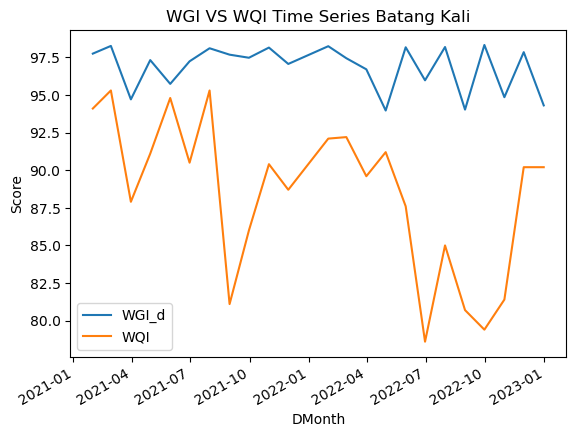

<AxesSubplot:xlabel='DMonth'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Kuala Kubu Bharu')

Text(0, 0.5, 'Score')

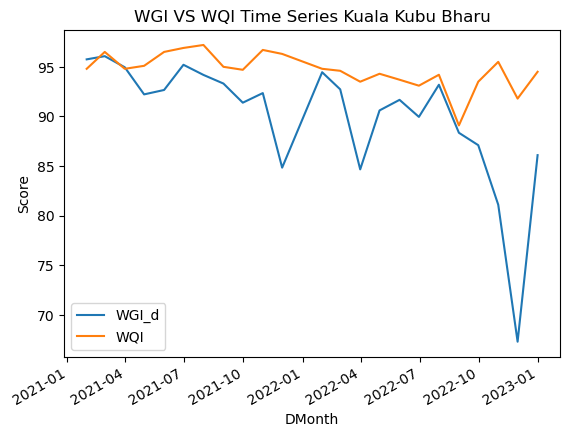

<AxesSubplot:xlabel='DMonth'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rantau Panjang New')

Text(0, 0.5, 'Score')

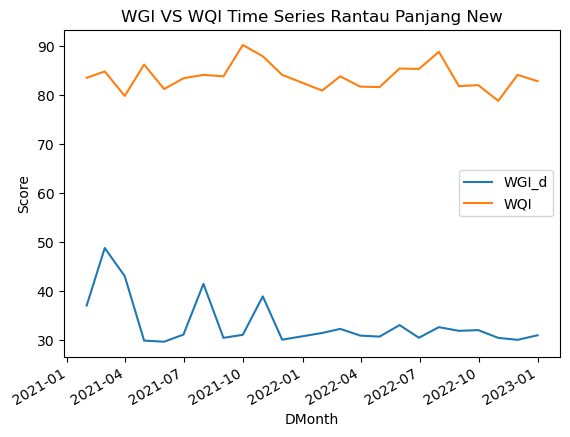

<AxesSubplot:xlabel='DMonth'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rantau Panjang Old')

Text(0, 0.5, 'Score')

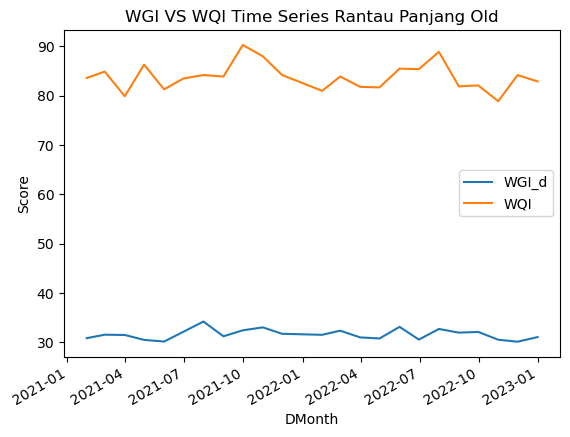

<AxesSubplot:xlabel='DMonth'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Rasa')

Text(0, 0.5, 'Score')

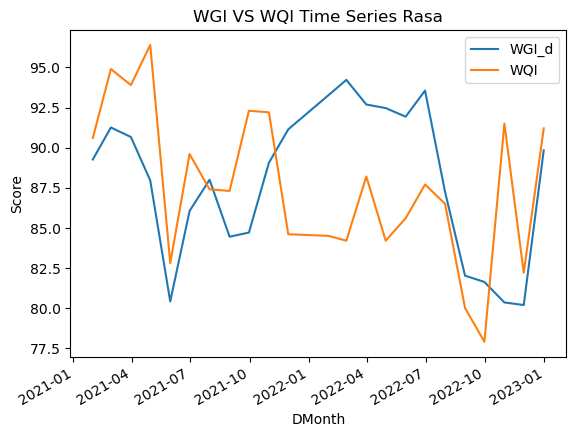

<AxesSubplot:xlabel='DMonth'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Rangkap')

Text(0, 0.5, 'Score')

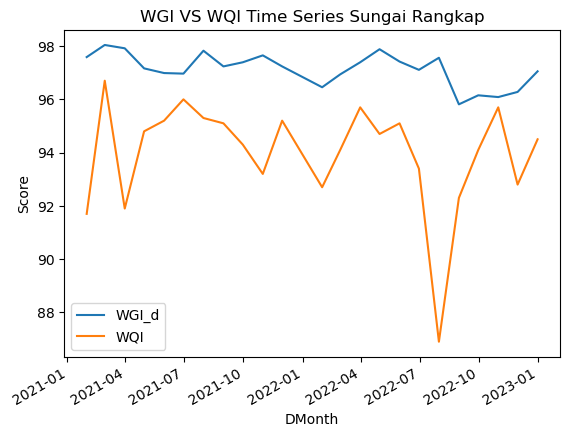

<AxesSubplot:xlabel='DMonth'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 1')

Text(0, 0.5, 'Score')

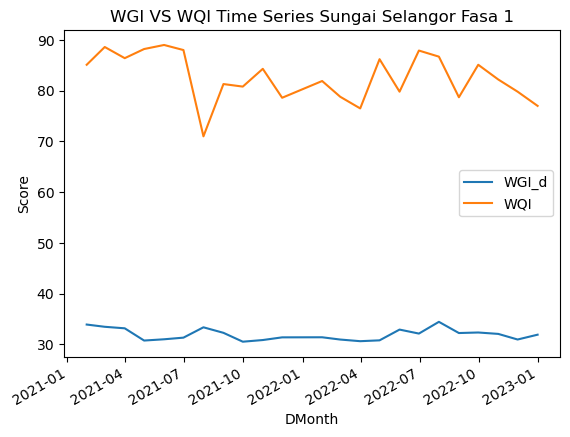

<AxesSubplot:xlabel='DMonth'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 2 Stream C')

Text(0, 0.5, 'Score')

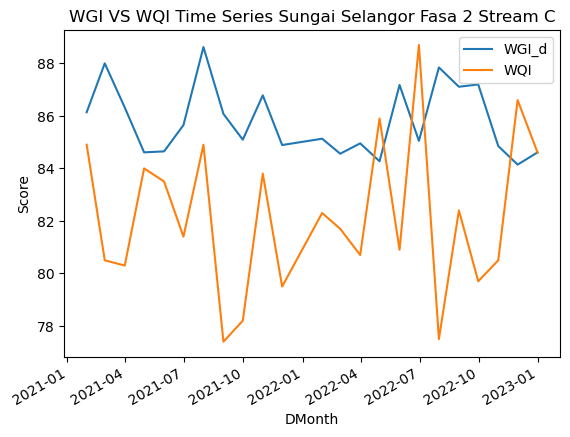

<AxesSubplot:xlabel='DMonth'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 2 Stream D')

Text(0, 0.5, 'Score')

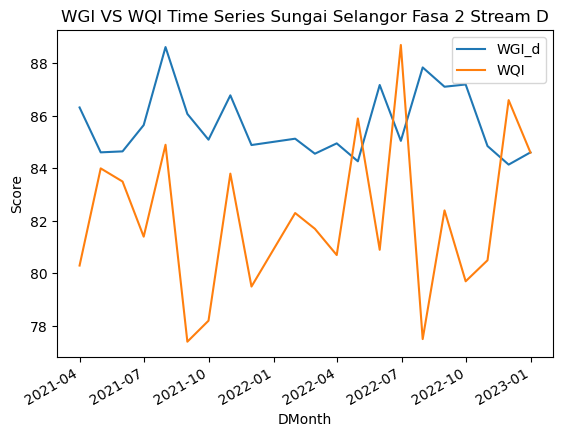

<AxesSubplot:xlabel='DMonth'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 3 Stage 1')

Text(0, 0.5, 'Score')

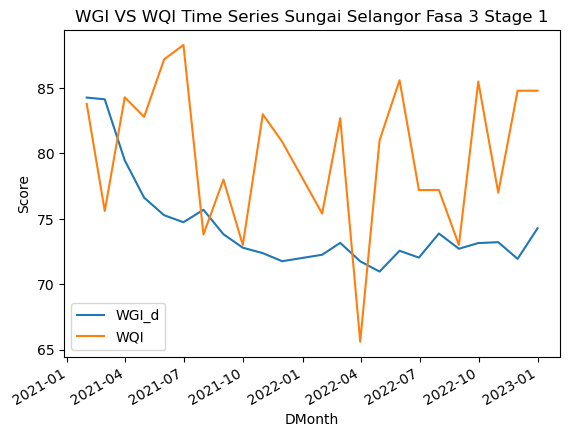

<AxesSubplot:xlabel='DMonth'>

Text(0.5, 1.0, 'WGI VS WQI Time Series Sungai Selangor Fasa 3 Stage 2')

Text(0, 0.5, 'Score')

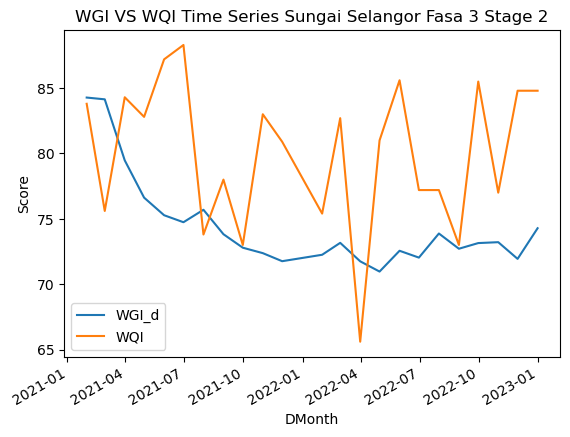

In [31]:
## General Plot to see how the WQI & WGI Differences
for i in c[c['Lembangan'] == 'Sg Selangor']['wtp'].unique():
    c[c['wtp']==i].plot(x='DMonth',y=['WGI_d','WQI'])
    plt.title(f'WGI VS WQI Time Series {i}')
    plt.ylabel('Score')
    plt.show()

### WGI/WQI VS Actual Monthly Chemical Consumption (Linear Correlation)

In [32]:
## Loading Chemical File & Perform Data Regrouping
chedf = pd.read_csv('checons.csv')
chedf = chedf.rename(columns={'Flopam AH 912 PWG (25kg / bag).1':'Flopam AH 912 PWG (25kg / bag)'})
mdict = dict(zip(chedf['Month'].unique(),np.array(range(1,13,1))))
chedf['Month'] = chedf['Month'].apply(lambda x: mdict.get(x))
cgr = pd.read_csv("C.Grouping.csv")
cgr = cgr.rename(columns={'Chemical Name':'Chem'})

In [33]:
newdb = pd.merge(pd.DataFrame({'Chem':chedf.columns}),cgr,on='Chem',how='inner')
coa = newdb[newdb['Correct Grouping']=='Coagulant']['Chem'].unique()
pha = newdb[newdb['Correct Grouping']=='pH Adjuster']['Chem'].unique()
dis = newdb[newdb['Correct Grouping']=='Disinfectant']['Chem'].unique()

In [34]:
chedf['Coagulant'] = chedf[coa].sum(axis=1)
chedf['pH Adjuster'] = chedf[pha].sum(axis=1)
chedf['Disinfectant'] = chedf[dis].sum(axis=1)

### Using 2022 & 2021 data

In [35]:
#Read the 2022 Chem Data


jam7 = pd.read_csv('CP_data\ChemPare_SgSel_2021_NEW_2022_Rasa_SSP1.csv', index_col=None, header=0)
jam7 = jam7.drop('Unnamed: 0', axis=1)

chem = [
        'Soda_Ash',
        'Liquid_Chlorine',
        'Liquid_Polyaluminium_Chloride',
        'Hydrated_Lime',
        'Aluminium_Sulphate']

wtp_exclude_lst = ['Bernam River Headworks (Old)',
 'Bukit Tampoi New',
 'Salak Tinggi',
 'Sungai Serai',
 'Bernam River Headworks (New)']

jam8 = jam7.copy().fillna(0)

for i in wtp_exclude_lst:
    jam8 = jam8[(jam8['wtp'] != i) ]

jam8['Soda_Ash'] = jam8.apply(lambda row: row['Soda_Ash_T'] + row['Soda Ash'], axis=1)
jam8['Liquid_Chlorine'] = jam8.apply(lambda row: row['Liquid_Chlorine_T'] + row['Liquid Chlorine'], axis=1)
jam8['Liquid_Polyaluminium_Chloride'] = jam8.apply(lambda row: row['Liquid Polyaluminium Chloride (mg/L)'] + row['Liquid Polyaluminium Chloride'], axis=1)
jam8['Hydrated_Lime'] = jam8.apply(lambda row: row['Hydrated Lime'] + row['Hydrated_Lime_Pow_T'], axis=1)
jam8['Aluminium_Sulphate'] = jam8.apply(lambda row: row['Liquid Aluminium Sulphate'] + row['Kibbled Aluminium Sulphate'], axis=1)
jam8['Sodium_Silico_Fluoride'] = jam8.apply(lambda row: row['Sodium Silico Fluoride'] , axis=1)

jam8 = jam8.drop(['Sodium Aluminosilicate','Flopam FA 920 PWG','Raw Water Polyelectrolyte 4290 PWG / 4190 PWG / AN910 (mg/L)','Flopam FO 4290 PWG','Sodium_Silico_Fluoride','Microsand','Sodium Silico Fluoride','Kibbled Aluminium Sulphate','Liquid Aluminium Sulphate','Hydrated Lime','Hydrated_Lime_Pow_T','Soda_Ash_T','Soda Ash','Liquid_Chlorine_T','Liquid Chlorine','Liquid Polyaluminium Chloride (mg/L)','Liquid Polyaluminium Chloride'],axis = 1)
# jam8['Date'] = pd.to_datetime(jam8['Date'])  # Convert to datetime format
# jam8['Year'] = jam8['Date'].dt.year  
# jam8_2021 = jam8[jam8['Year'] == 2021]
# jam8_2022 = jam8[jam8['Year'] == 2022]
# # Columns to check for outliers
# columns_to_check = [
#     'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg',
#     'Ammonia_avg', 'Manganese_avg', 'Soda_Ash', 'Liquid_Chlorine',
#     'Liquid_Polyaluminium_Chloride', 'Hydrated_Lime', 'Aluminium_Sulphate'
# ]

# def remove_outliers(df, group_col, value_col):
#     Q1 = df.groupby(group_col)[value_col].quantile(0.25)
#     Q3 = df.groupby(group_col)[value_col].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     return df[df.apply(lambda row: lower_bound[row[group_col]] <= row[value_col] <= upper_bound[row[group_col]], axis=1)]
# #Apply the remove_outliers function for each column and update the DataFrame
# for column in columns_to_check:
#     jam8_2021 = remove_outliers(jam8_2021, 'wtp', column)

# for column in columns_to_check:
#     jam8_2022 = remove_outliers(jam8_2022, 'wtp', column)

# jam8 = pd.concat([jam8_2021, jam8_2022])
# #jam8 = jam8[jam8['Date'] < '2022-01-01']
# #Columns to check for outliers
# columns_to_check = [
#     'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg',
#     'Ammonia_avg', 'Manganese_avg', 'Soda_Ash', 'Liquid_Chlorine',
#     'Liquid_Polyaluminium_Chloride', 'Hydrated_Lime', 'Aluminium_Sulphate'
# ]

# def remove_outliers(df, group_col, value_col):
#     Q1 = df.groupby(group_col)[value_col].quantile(0.25)
#     Q3 = df.groupby(group_col)[value_col].quantile(0.75)
#     IQR = Q3 - Q1

#     lower_bound = Q1 - 1.5 * IQR
#     upper_bound = Q3 + 1.5 * IQR

#     return df[df.apply(lambda row: lower_bound[row[group_col]] <= row[value_col] <= upper_bound[row[group_col]], axis=1)]
# # Apply the remove_outliers function for each column and update the DataFrame
# for column in columns_to_check:
#     jam8 = remove_outliers(jam8, 'wtp', column)

In [36]:
to_score['Date'] = pd.to_datetime(to_score['Date'])
jam8['Date'] = pd.to_datetime(jam8['Date'])
jam8['Month'] = jam8['Date'].dt.strftime('%m-%Y')
fcl = ['Month', 'wtp', 'Soda_Ash',	'Liquid_Chlorine',	'Liquid_Polyaluminium_Chloride',	'Hydrated_Lime',	'Aluminium_Sulphate',]
sum_jam8 = jam8.groupby(['wtp','Month'])['Soda_Ash','Liquid_Chlorine','Liquid_Polyaluminium_Chloride','Hydrated_Lime','Aluminium_Sulphate'].sum().reset_index()
db1 = sum_jam8[fcl].copy()
c2 = pd.merge(c[c['Lembangan']== 'Sg Selangor'],db1,on=['wtp','Month'],how='left')

In [37]:
f= pd.merge(jam8[['wtp','Date', 'Soda_Ash', 'Liquid_Chlorine', 'Liquid_Polyaluminium_Chloride', 'Hydrated_Lime', 'Aluminium_Sulphate']],to_score,on = ['wtp','Date'],how = 'left')

In [38]:
c2['all_chem'] = c2['Soda_Ash'] +c2['Liquid_Chlorine'] + c2['Liquid_Polyaluminium_Chloride'] +	c2['Hydrated_Lime'] +c2['Aluminium_Sulphate']

In [39]:
## General Correlation Between Chemical Products & WGI/WQI
out_corr_pd = pd.DataFrame()
onew = 0
for i in c2['wtp'].unique():
    x = c2[c2['wtp']== i][['wtp','WQI','WGI_d','all_chem','Soda_Ash',	'Liquid_Chlorine',	'Liquid_Polyaluminium_Chloride',	'Hydrated_Lime',	'Aluminium_Sulphate']].corr()
    x['wtp'] = [i,i,i,i,i,i,i,i]
    if onew == 0:
        out_corr_pd = out_corr_pd.append(x)
    else:
        out_corr_pd = pd.concat([out_corr_pd,x], ignore_index=False)
    onew = onew + 1



In [40]:
out_corr_pd.to_csv('Plot/Result/WGI_WQI_Chem_Corr_27Apr.csv')

<AxesSubplot:>

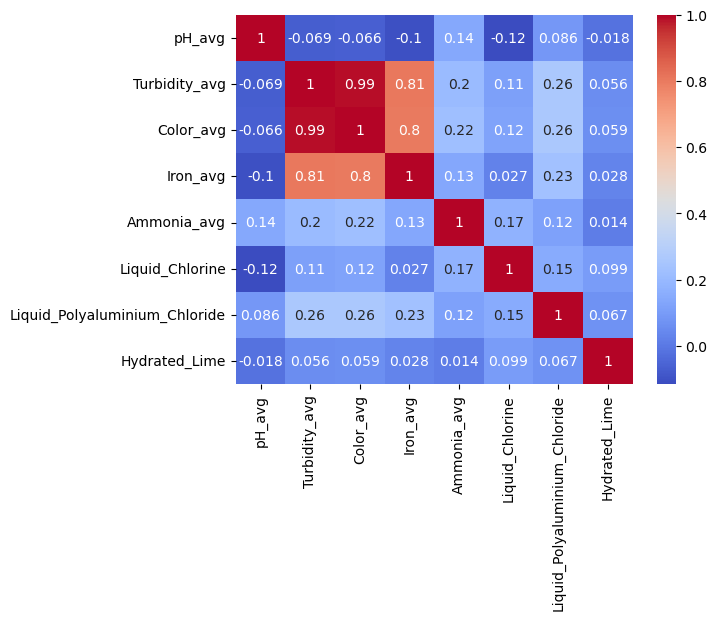

In [41]:
core = jam8[jam8['wtp'] == 'Sungai Selangor Fasa 1'][[ 'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg',
 'Liquid_Chlorine',
 'Liquid_Polyaluminium_Chloride',
 'Hydrated_Lime']].corr()

sns.heatmap(core, annot=True, cmap='coolwarm')

<AxesSubplot:>

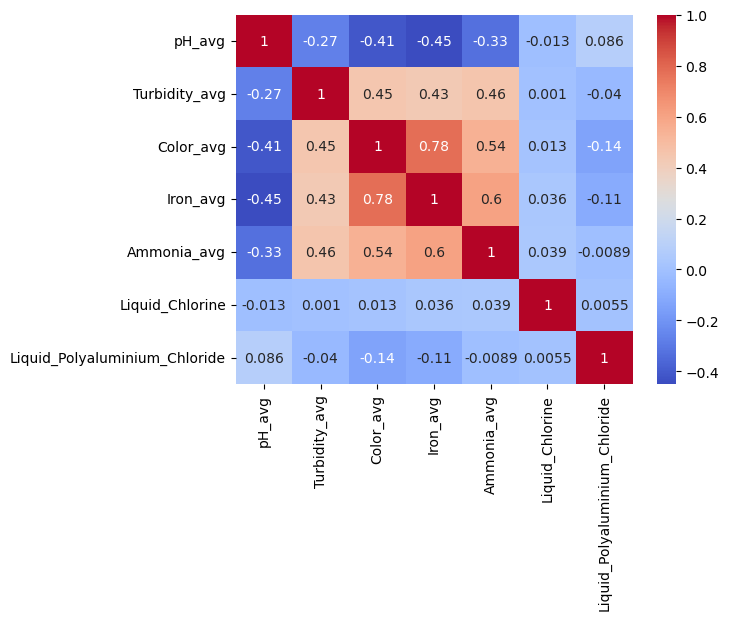

In [42]:
core = jam8[jam8['wtp'] == 'Rasa'][[ 'pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg', 'Ammonia_avg',
 'Liquid_Chlorine',
 'Liquid_Polyaluminium_Chloride']].corr()

sns.heatmap(core, annot=True, cmap='coolwarm')

In [43]:
chem = ['Soda_Ash',
 'Liquid_Chlorine',
 'Liquid_Polyaluminium_Chloride',
 'Hydrated_Lime',
 'Aluminium_Sulphate',
 'all_chem']

In [44]:
c2['Month'] = pd.to_datetime(c2['Month'], format='%m-%Y')
#c2 = c2[(c2['Month'] > '12-2021') ]

               WQI     WGI_d  all_chem
WQI       1.000000  0.213270 -0.489406
WGI_d     0.213270  1.000000 -0.395139
all_chem -0.489406 -0.395139  1.000000


Text(0.5, 0, 'Month')

Text(0, 0.5, 'WGI')

(93.967511278431, 98.3243108097462)

Text(0.5, 1.0, 'WGI VS Total Chem. Dosage Time Series Batang Kali Corr WGI:-0.4')

Text(0, 0.5, 'Total Chem (mg/l)')

(412.84000000000003, 630.38)

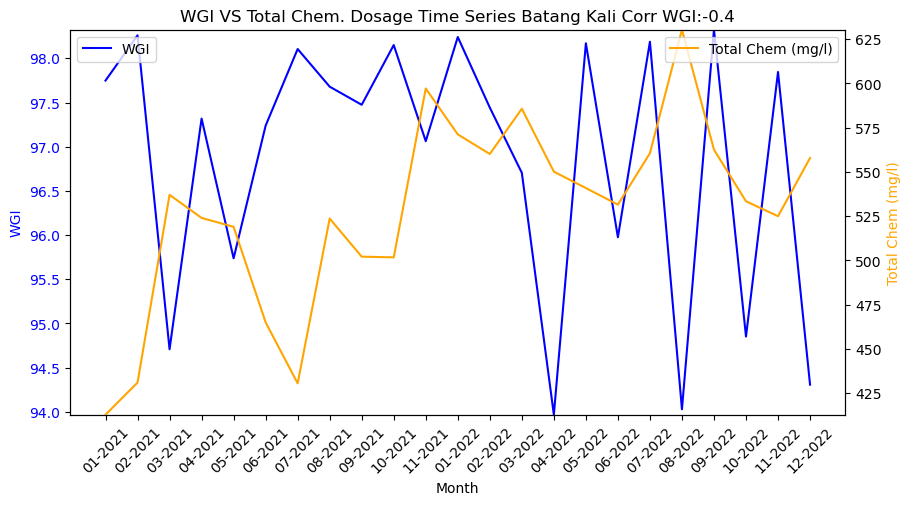

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WGI')

(78.6, 95.3)

NameError: name 'corr_val2' is not defined

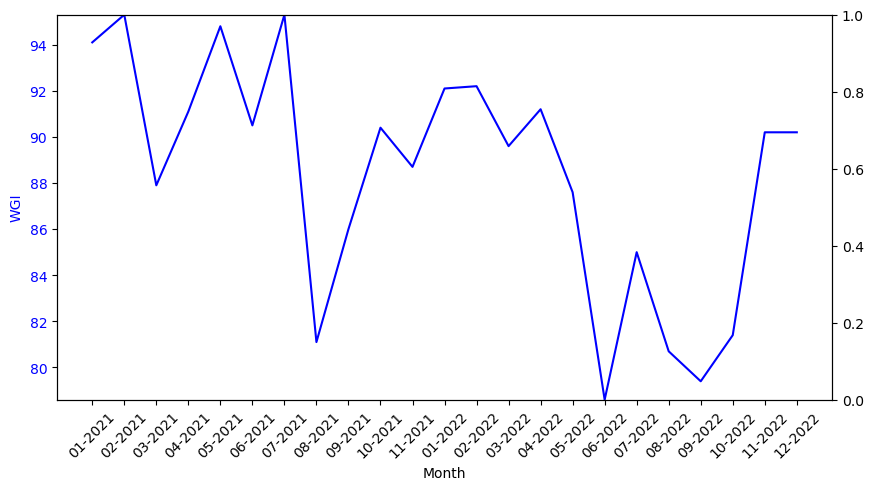

In [45]:

columns_target = 'wtp'
core_unit_wgi = []
core_unit_wqi = []
wtp_corr = []
columns_target = 'wtp'

for i in c2[columns_target].unique():
    for j in ['all_chem']:
     
        core = c2[c2[columns_target] == i][['WQI','WGI_d',j]].corr()
        core_unit_wgi.append(core[j][1])
        corr_val =round(core[j][1],2)
        corr_val_WQI =round(core[j][0],2)
        core_unit_wqi.append(core[j][0])
        print(core)
      
        a = c2[c2['wtp']==i].copy()
 
        # get x, y1, and y2 data from the DataFrame
        #a['Month'] = pd.to_datetime(a['Month'], format="%b-%y").dt.strftime('%m-%Y')
        a = a.sort_values('Month')
        x = pd.to_datetime(a['Month'], format="%b-%y").dt.strftime('%m-%Y')
        y1 = a['WGI_d']
        y2 = a['all_chem']

        # create figure and axis objects
        fig, ax1 = plt.subplots(figsize=(10, 5))

        # plot the first variable on the left y axis
        ax1.plot(x, y1, color='blue')
        ax1.set_xlabel('Month')
        ax1.set_ylabel('WGI', color='blue')
        ax1.tick_params(axis='x', rotation=45)

        # set the color of the tick labels on the left y-axis
        ax1.tick_params(axis='y', labelcolor='blue')

        # set the limits for the y-axis on the left
        ax1.set_ylim([y1.min(), y1.max()])

        # create a second y axis that shares the same x axis
        ax2 = ax1.twinx()
        # add a title to the plot
        #ax1.set_title('Title of the Plot', fontsize=12)
        ax1.set_title(f'WGI VS Total Chem. Dosage Time Series {i} Corr WGI:{corr_val}')
        # plot the second variable on the right y axis
        ax2.plot(x, y2, color='orange')
        ax2.set_ylabel('Total Chem (mg/l)', color='orange')

        # set the limits for the y-axis on the right
        ax2.set_ylim([y2.min(), y2.max()])

        # add a legend to the plot
        ax1.legend(['WGI'], loc='upper left')
        ax2.legend(['Total Chem (mg/l)'], loc='upper right')

        # show the plot
        plt.show()

        y1 = a['WQI']

        # create figure and axis objects
        fig, ax1 = plt.subplots(figsize=(10, 5))

        # plot the first variable on the left y axis
        ax1.plot(x, y1, color='blue')
        ax1.set_xlabel('Month')
        ax1.set_ylabel('WGI', color='blue')
        ax1.tick_params(axis='x', rotation=45)

        # set the color of the tick labels on the left y-axis
        ax1.tick_params(axis='y', labelcolor='blue')

        # set the limits for the y-axis on the left
        ax1.set_ylim([y1.min(), y1.max()])

        # create a second y axis that shares the same x axis
        ax2 = ax1.twinx()
        # add a title to the plot
        #ax1.set_title('Title of the Plot', fontsize=12)
        ax1.set_title(f'WQI VS Total Chem. Dosage Time Series {i} Corr WQI:{corr_val2}')
        # plot the second variable on the right y axis
        ax2.plot(x, y2, color='orange')
        ax2.set_ylabel('Total Chem (mg/l)', color='orange')

        # set the limits for the y-axis on the right
        ax2.set_ylim([y2.min(), y2.max()])

        # add a legend to the plot
        ax1.legend(['WQI'], loc='upper left')
        ax2.legend(['Total Chem (mg/l)'], loc='upper right')

        # show the plot
        plt.show()
        # scaler = MinMaxScaler(feature_range=(a['WGI_d'].min(), a['WGI_d'].max()))
        # a[j] = scaler.fit_transform(a[[j]])
        # #a['WQI'] = scaler.fit_transform(a[['WQI']])
        # a.plot(x='Month',y=['WGI_d',j])
        # plt.title(f'WGI VS Total Chem. Dosage Time Series {i} Corr WGI:{corr_val}')
        # plt.ylabel('Score')
        # scaler2 = MinMaxScaler(feature_range=(a['WQI'].min(), a['WQI'].max()))
        # a[j] = scaler2.fit_transform(a[[j]])
        # a.plot(x='Month',y=['WQI',j])
        # plt.title(f'WQI VS Total Chem. Dosage Time Series {i} Corr WQI:{corr_val_WQI}')
        # plt.ylabel('Score')
      
      
        # plt.show()
        wtp_corr.append(i) 
        # sns.heatmap(core, annot=True, cmap='coolwarm')
        # plt.title(i)
        # plt.show()

data = {'wtp': wtp_corr,
        'corr_wgi_unit': core_unit_wgi,
        'corr_wqi_unit': core_unit_wqi}
  
# Create DataFrame
corr_df = pd.DataFrame(data)

In [ ]:
print(corr_df.sort_values('corr_wgi_unit'))

In [46]:
jam8.columns

Index(['wtp', 'pH_avg', 'Date', 'Turbidity_avg', 'Color_avg', 'Iron_avg',
       'Ammonia_avg', 'Manganese_avg', 'Month', 'Flopam FO 4190 PWG',
       'Soda_Ash', 'Liquid_Chlorine', 'Liquid_Polyaluminium_Chloride',
       'Hydrated_Lime', 'Aluminium_Sulphate'],
      dtype='object')

### Problem investigating

In [47]:
jam8.columns

Index(['wtp', 'pH_avg', 'Date', 'Turbidity_avg', 'Color_avg', 'Iron_avg',
       'Ammonia_avg', 'Manganese_avg', 'Month', 'Flopam FO 4190 PWG',
       'Soda_Ash', 'Liquid_Chlorine', 'Liquid_Polyaluminium_Chloride',
       'Hydrated_Lime', 'Aluminium_Sulphate'],
      dtype='object')

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Batang Kali, pH_avg ')

Text(0, 0.5, 'mg/l')

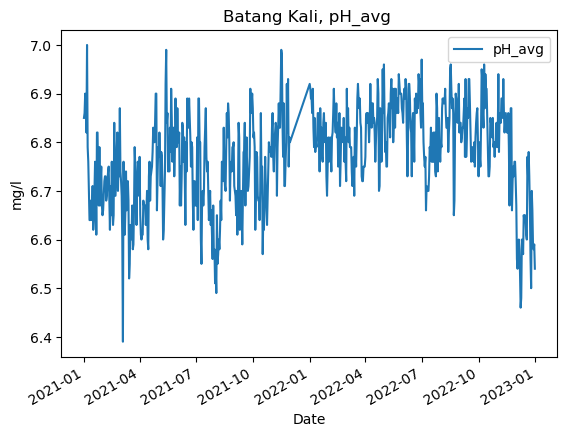

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Batang Kali, Turbidity_avg ')

Text(0, 0.5, 'mg/l')

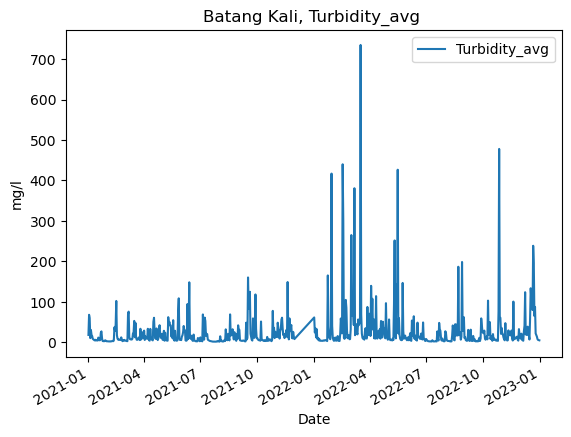

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Batang Kali, Color_avg ')

Text(0, 0.5, 'mg/l')

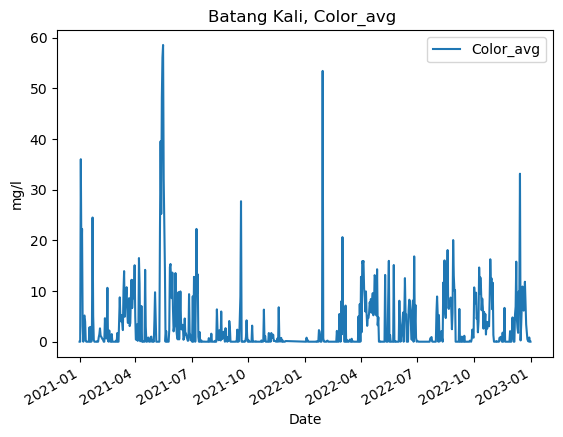

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Batang Kali, Iron_avg ')

Text(0, 0.5, 'mg/l')

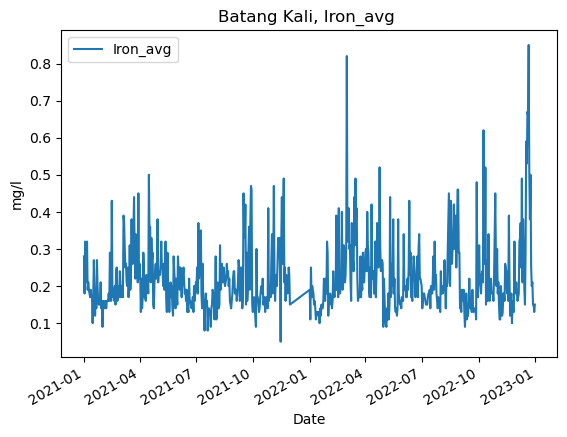

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Batang Kali, Ammonia_avg ')

Text(0, 0.5, 'mg/l')

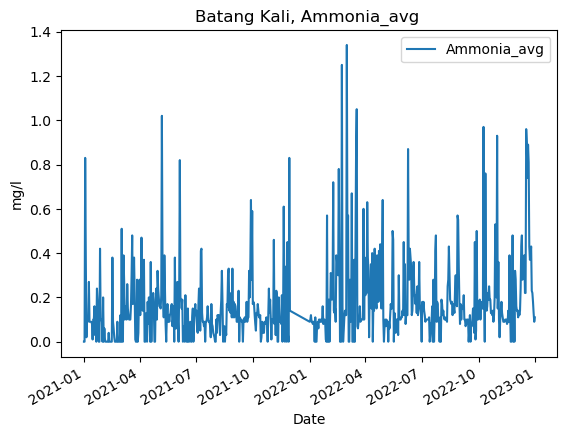

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Batang Kali, Manganese_avg ')

Text(0, 0.5, 'mg/l')

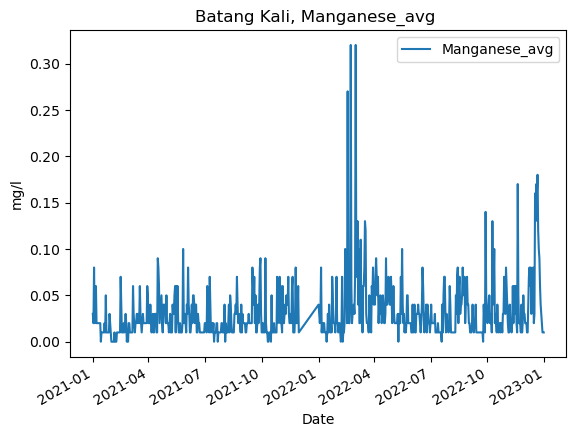

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Batang Kali, Soda_Ash ')

Text(0, 0.5, 'mg/l')

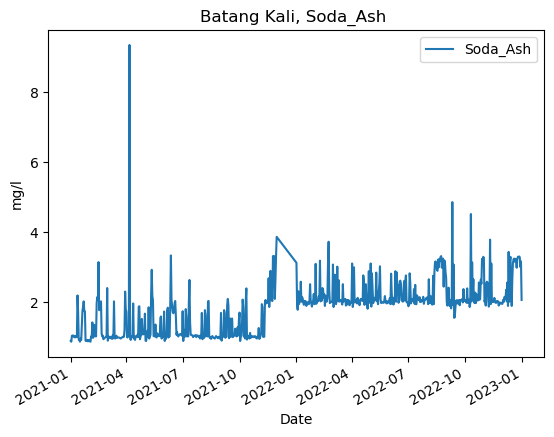

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Batang Kali, Liquid_Chlorine ')

Text(0, 0.5, 'mg/l')

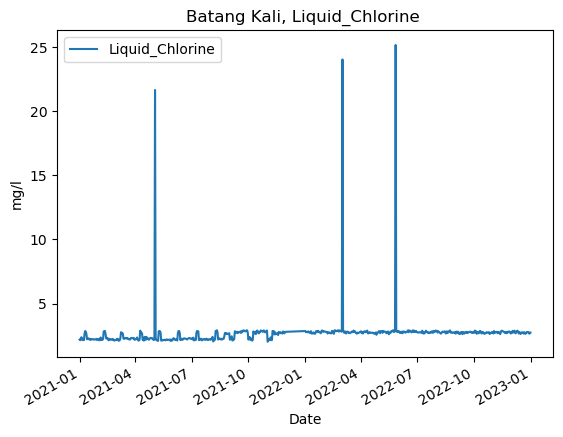

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Batang Kali, Liquid_Polyaluminium_Chloride ')

Text(0, 0.5, 'mg/l')

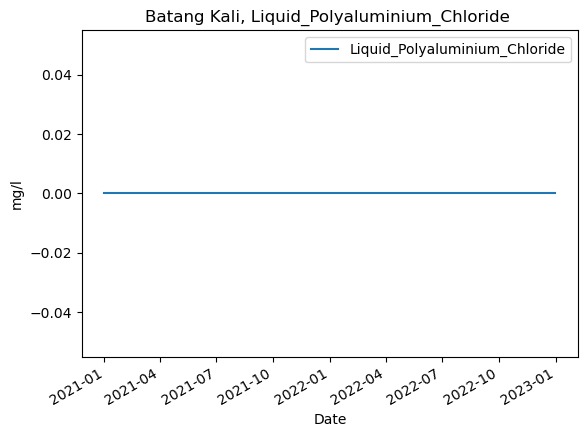

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Batang Kali, Hydrated_Lime ')

Text(0, 0.5, 'mg/l')

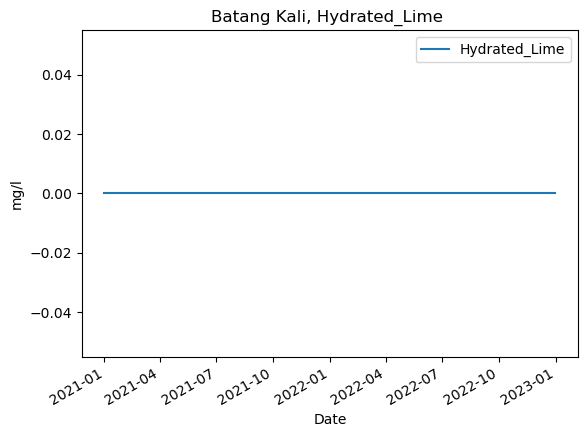

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Batang Kali, Aluminium_Sulphate ')

Text(0, 0.5, 'mg/l')

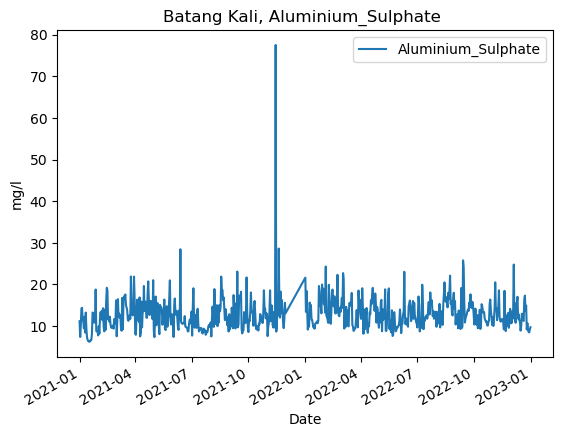

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang New, pH_avg ')

Text(0, 0.5, 'mg/l')

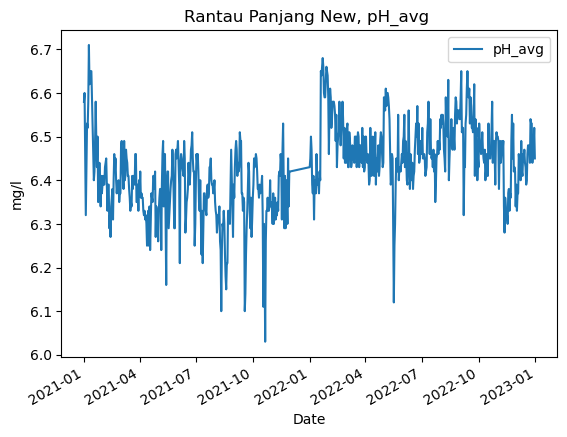

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang New, Turbidity_avg ')

Text(0, 0.5, 'mg/l')

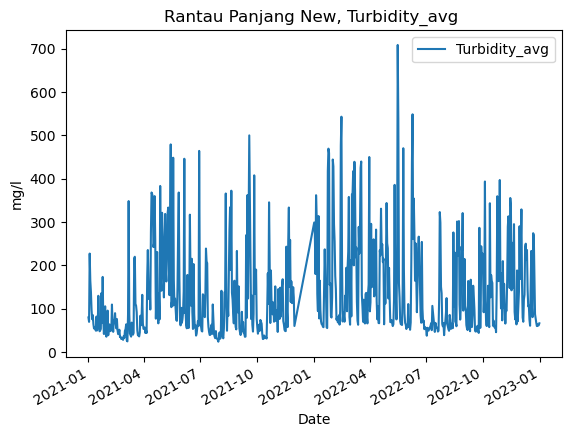

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang New, Color_avg ')

Text(0, 0.5, 'mg/l')

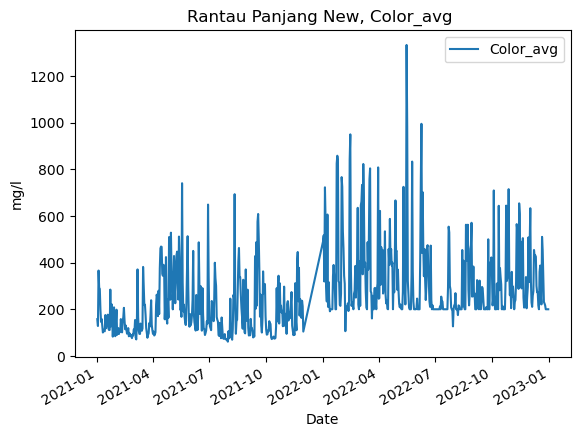

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang New, Iron_avg ')

Text(0, 0.5, 'mg/l')

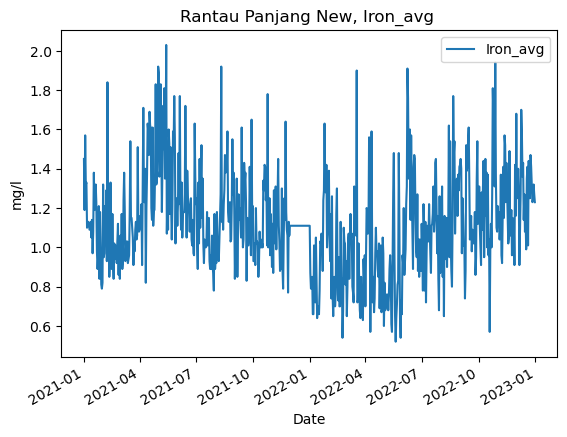

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang New, Ammonia_avg ')

Text(0, 0.5, 'mg/l')

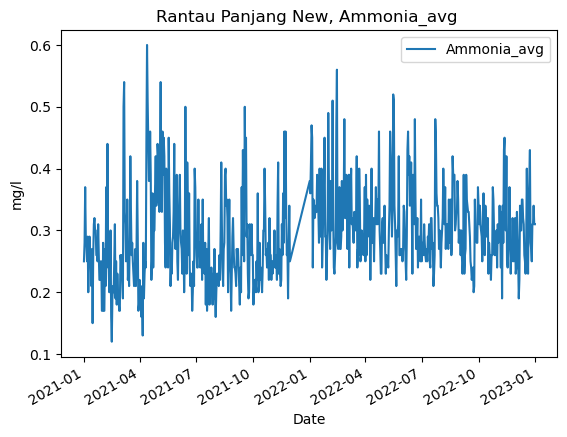

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang New, Manganese_avg ')

Text(0, 0.5, 'mg/l')

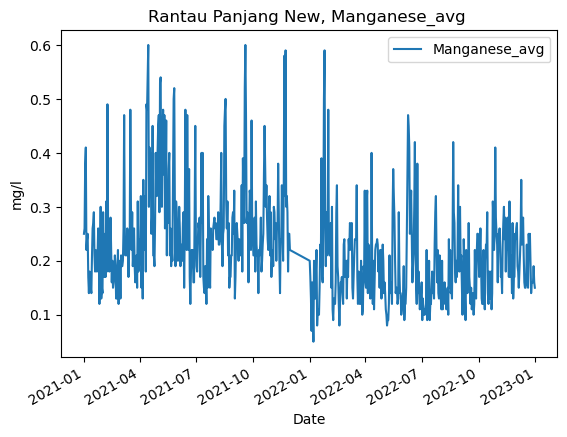

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang New, Soda_Ash ')

Text(0, 0.5, 'mg/l')

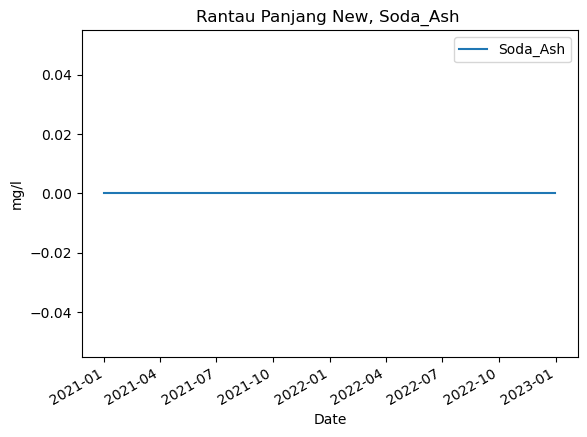

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang New, Liquid_Chlorine ')

Text(0, 0.5, 'mg/l')

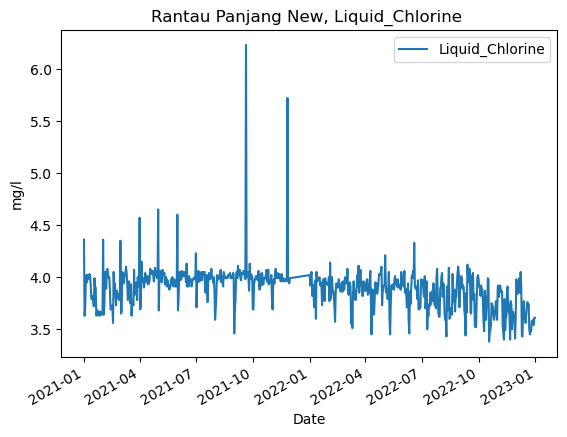

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang New, Liquid_Polyaluminium_Chloride ')

Text(0, 0.5, 'mg/l')

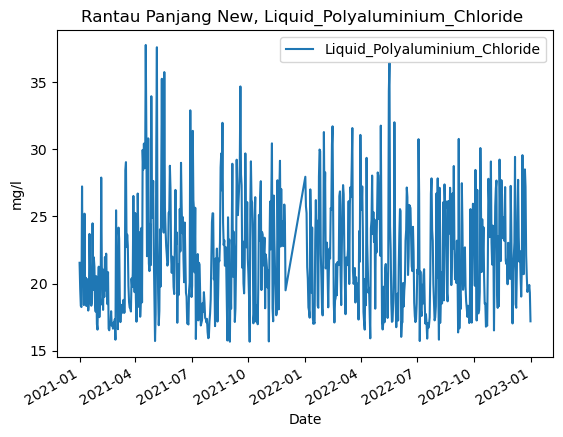

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang New, Hydrated_Lime ')

Text(0, 0.5, 'mg/l')

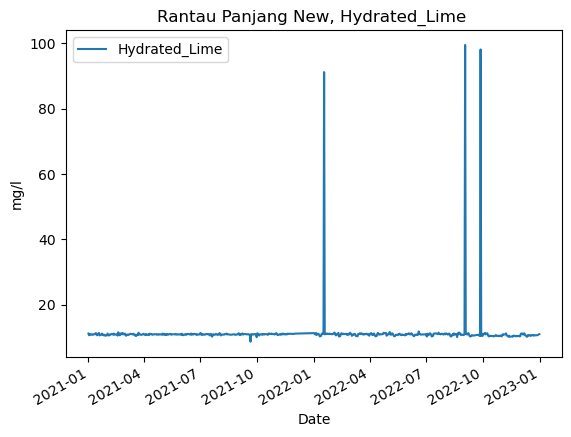

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang New, Aluminium_Sulphate ')

Text(0, 0.5, 'mg/l')

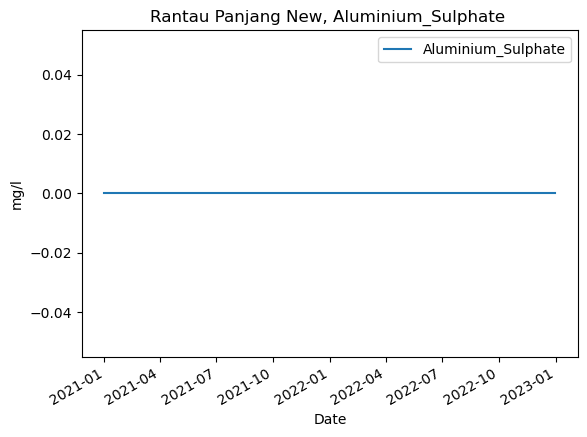

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang Old, pH_avg ')

Text(0, 0.5, 'mg/l')

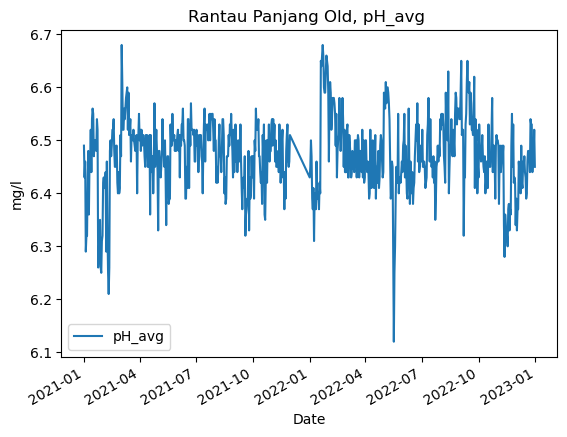

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang Old, Turbidity_avg ')

Text(0, 0.5, 'mg/l')

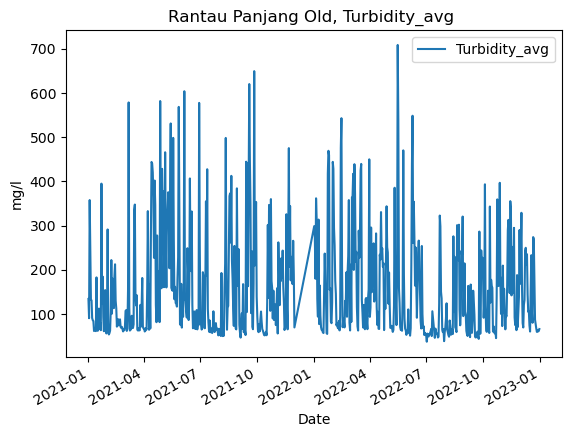

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang Old, Color_avg ')

Text(0, 0.5, 'mg/l')

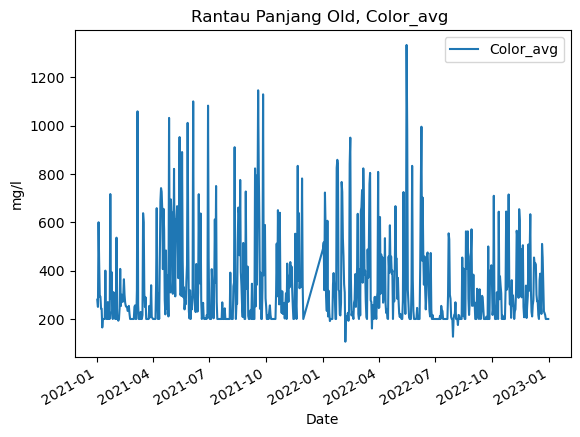

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang Old, Iron_avg ')

Text(0, 0.5, 'mg/l')

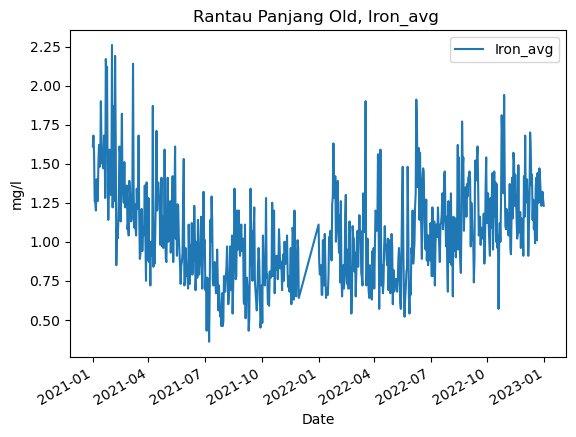

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang Old, Ammonia_avg ')

Text(0, 0.5, 'mg/l')

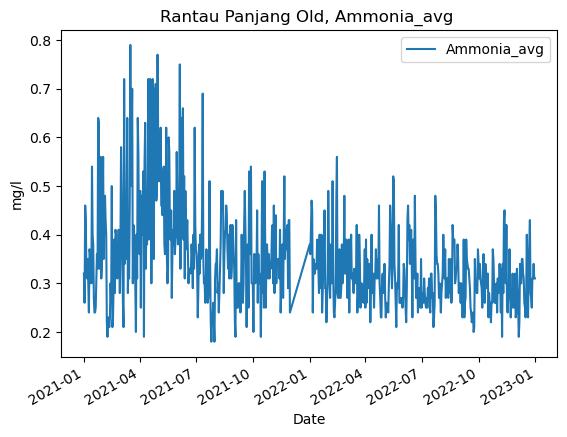

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang Old, Manganese_avg ')

Text(0, 0.5, 'mg/l')

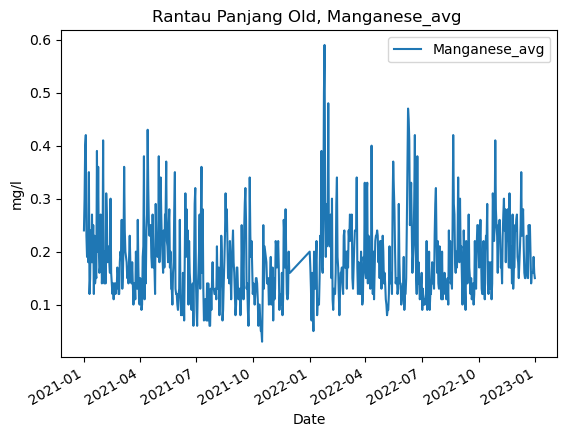

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang Old, Soda_Ash ')

Text(0, 0.5, 'mg/l')

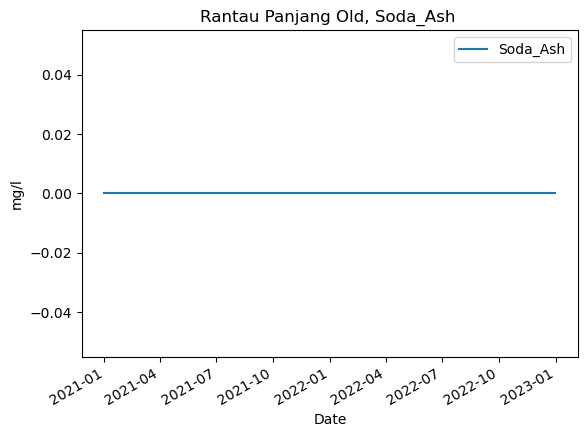

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang Old, Liquid_Chlorine ')

Text(0, 0.5, 'mg/l')

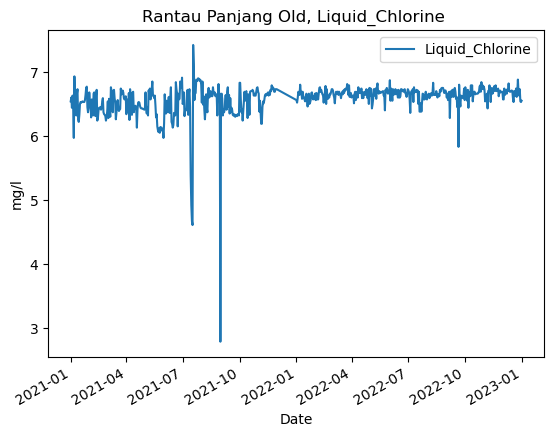

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang Old, Liquid_Polyaluminium_Chloride ')

Text(0, 0.5, 'mg/l')

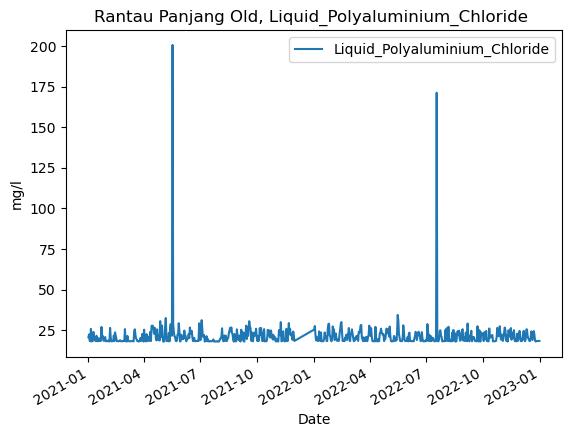

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang Old, Hydrated_Lime ')

Text(0, 0.5, 'mg/l')

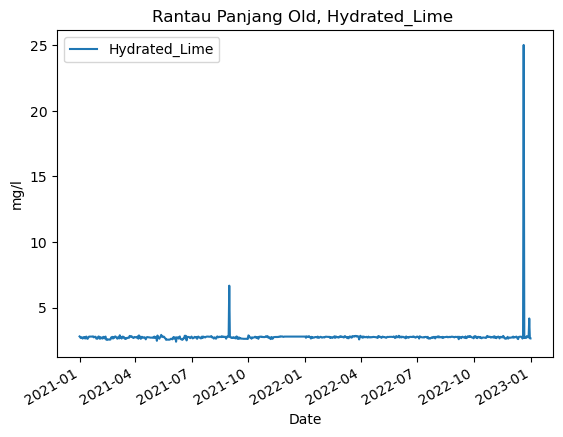

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rantau Panjang Old, Aluminium_Sulphate ')

Text(0, 0.5, 'mg/l')

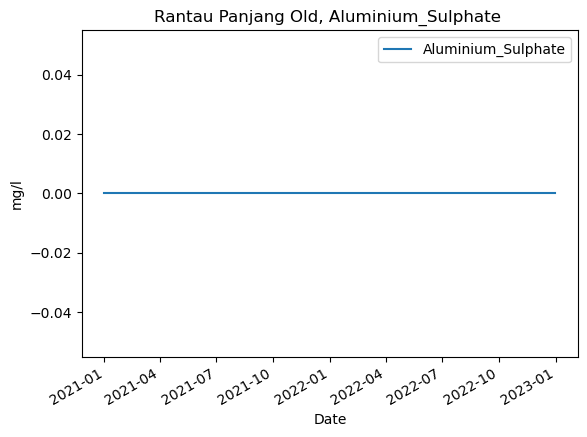

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Rangkap, pH_avg ')

Text(0, 0.5, 'mg/l')

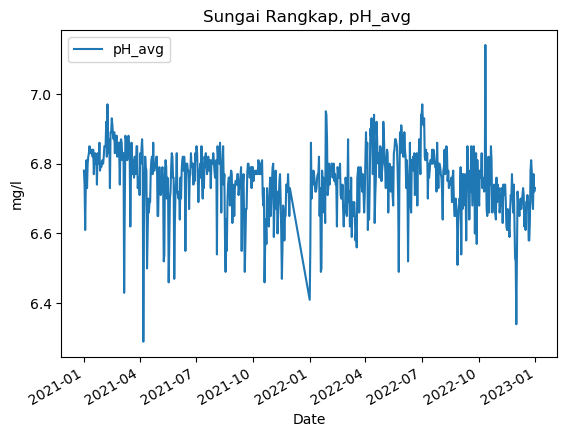

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Rangkap, Turbidity_avg ')

Text(0, 0.5, 'mg/l')

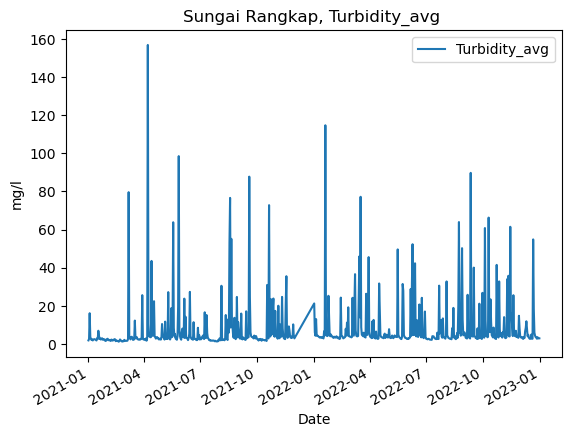

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Rangkap, Color_avg ')

Text(0, 0.5, 'mg/l')

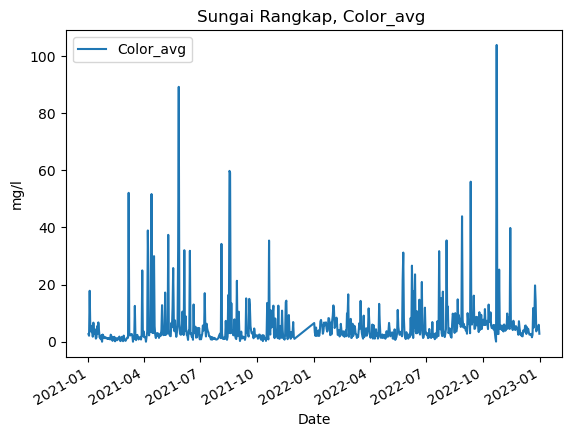

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Rangkap, Iron_avg ')

Text(0, 0.5, 'mg/l')

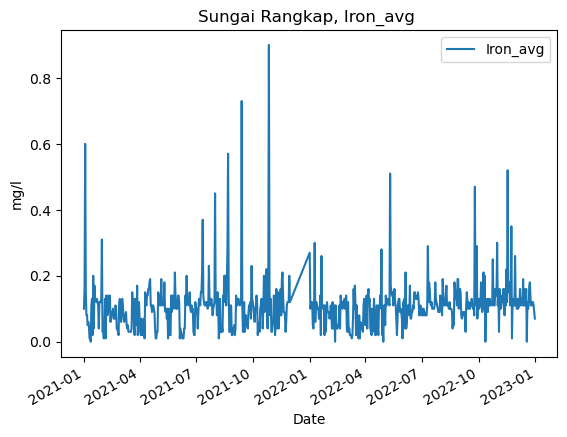

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Rangkap, Ammonia_avg ')

Text(0, 0.5, 'mg/l')

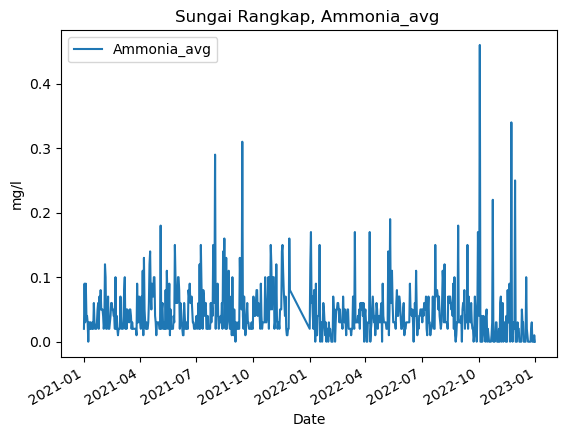

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Rangkap, Manganese_avg ')

Text(0, 0.5, 'mg/l')

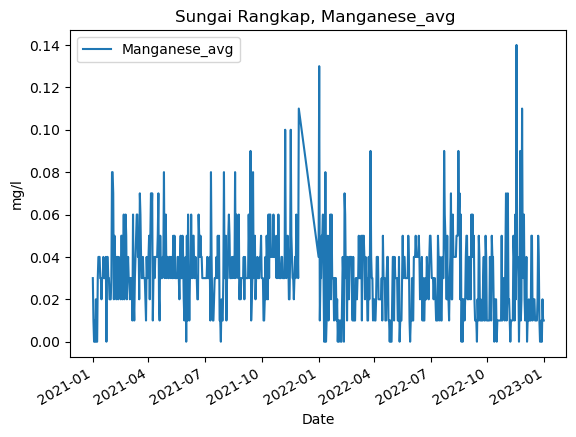

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Rangkap, Soda_Ash ')

Text(0, 0.5, 'mg/l')

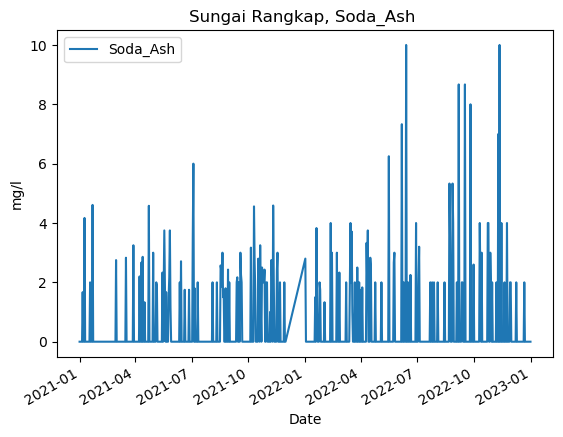

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Rangkap, Liquid_Chlorine ')

Text(0, 0.5, 'mg/l')

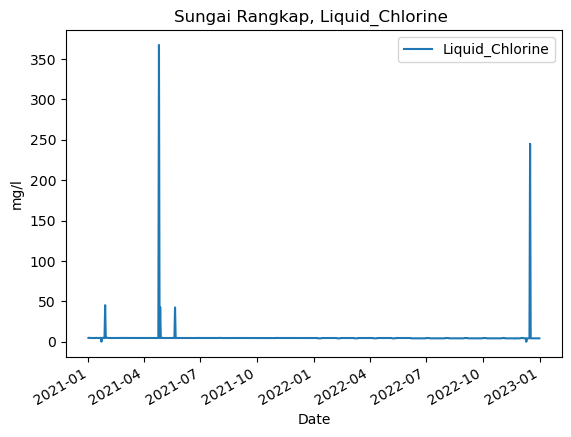

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Rangkap, Liquid_Polyaluminium_Chloride ')

Text(0, 0.5, 'mg/l')

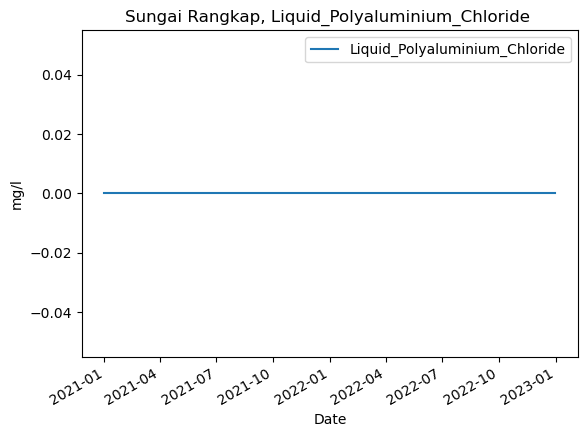

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Rangkap, Hydrated_Lime ')

Text(0, 0.5, 'mg/l')

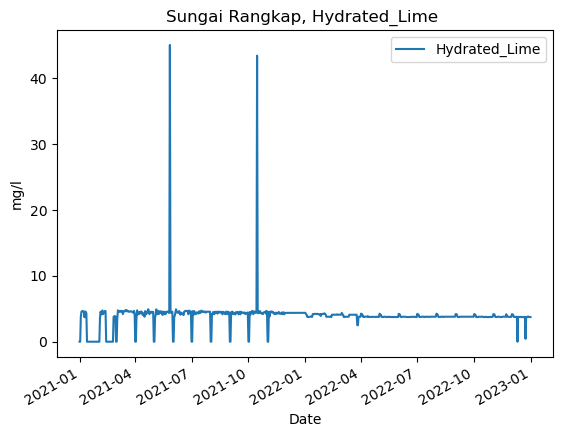

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Rangkap, Aluminium_Sulphate ')

Text(0, 0.5, 'mg/l')

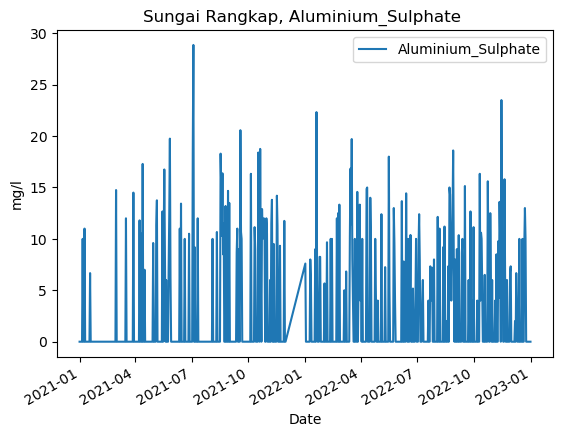

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Kuala Kubu Bharu, pH_avg ')

Text(0, 0.5, 'mg/l')

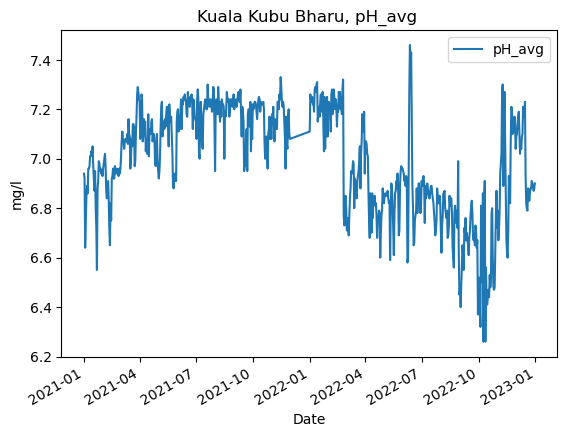

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Kuala Kubu Bharu, Turbidity_avg ')

Text(0, 0.5, 'mg/l')

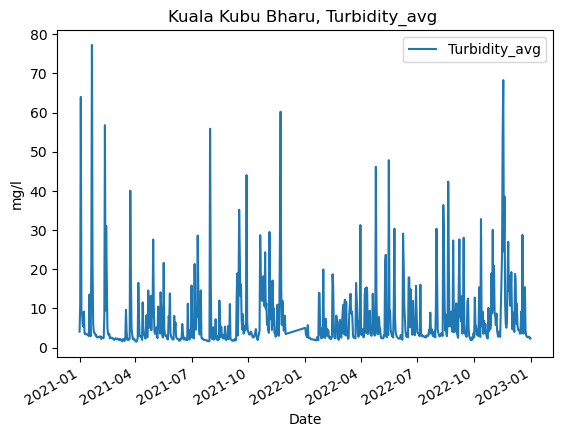

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Kuala Kubu Bharu, Color_avg ')

Text(0, 0.5, 'mg/l')

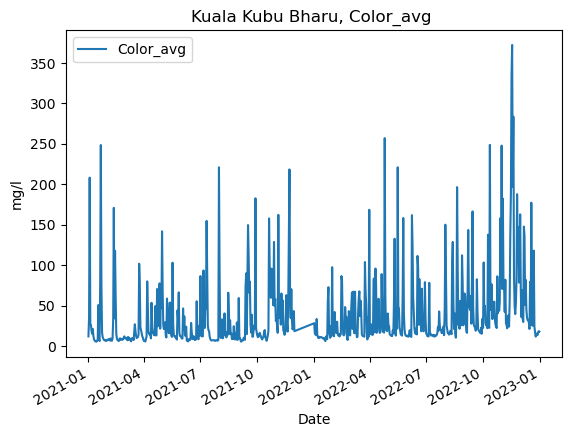

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Kuala Kubu Bharu, Iron_avg ')

Text(0, 0.5, 'mg/l')

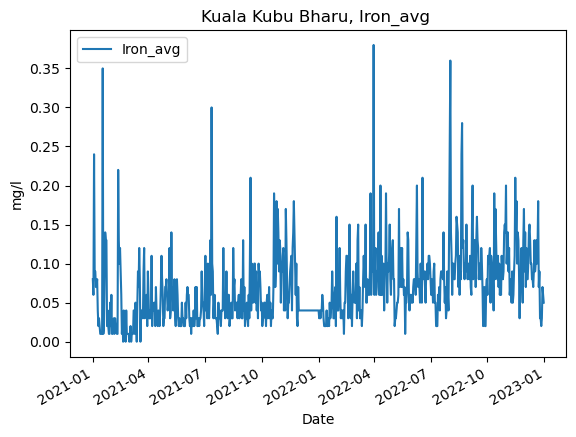

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Kuala Kubu Bharu, Ammonia_avg ')

Text(0, 0.5, 'mg/l')

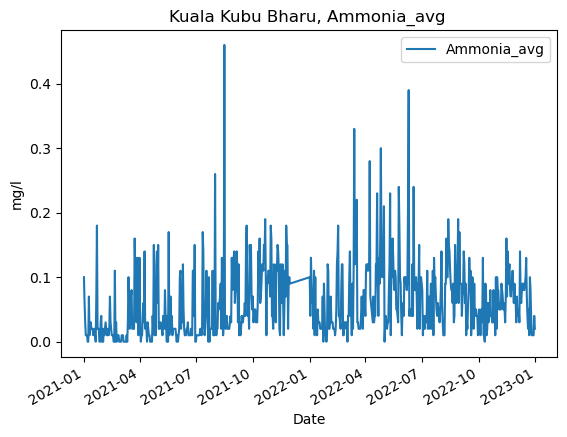

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Kuala Kubu Bharu, Manganese_avg ')

Text(0, 0.5, 'mg/l')

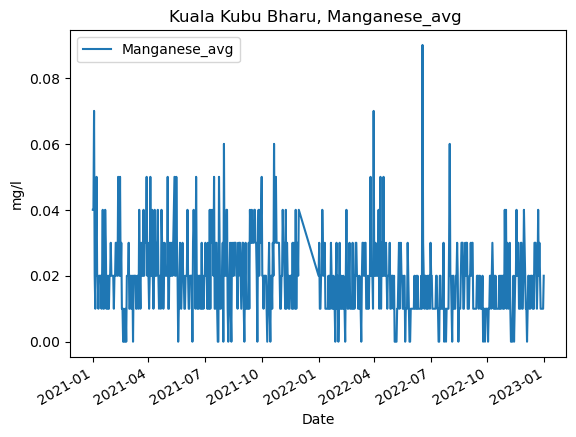

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Kuala Kubu Bharu, Soda_Ash ')

Text(0, 0.5, 'mg/l')

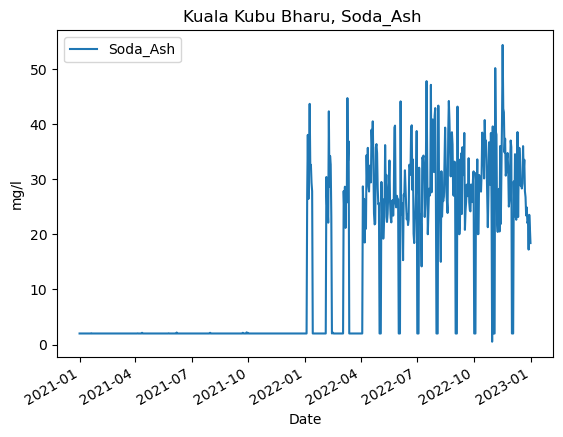

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Kuala Kubu Bharu, Liquid_Chlorine ')

Text(0, 0.5, 'mg/l')

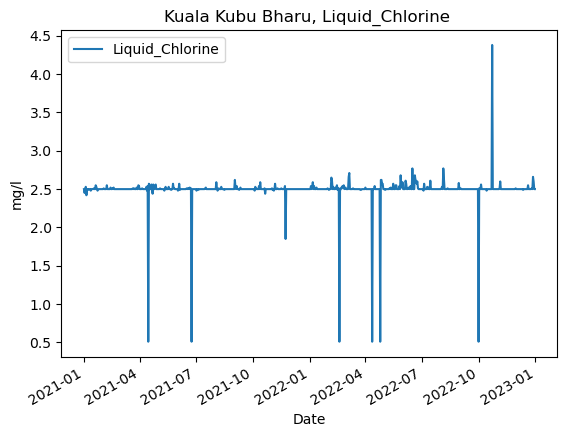

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Kuala Kubu Bharu, Liquid_Polyaluminium_Chloride ')

Text(0, 0.5, 'mg/l')

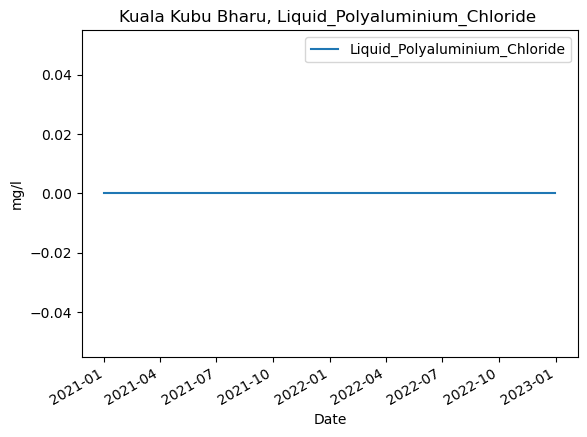

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Kuala Kubu Bharu, Hydrated_Lime ')

Text(0, 0.5, 'mg/l')

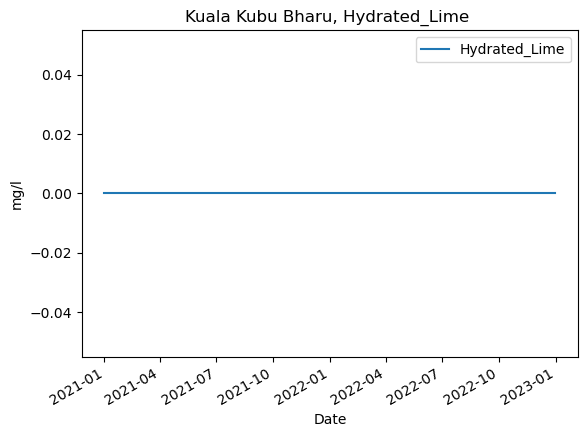

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Kuala Kubu Bharu, Aluminium_Sulphate ')

Text(0, 0.5, 'mg/l')

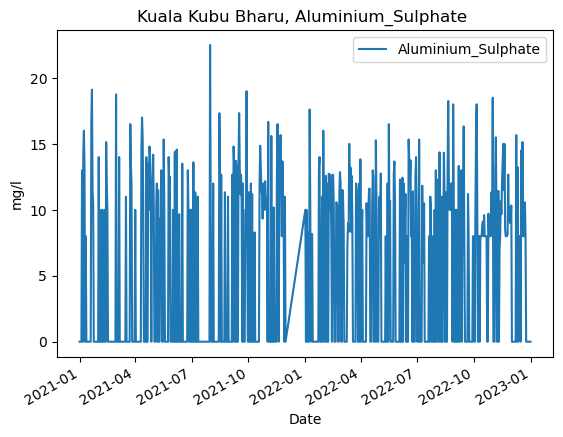

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rasa, pH_avg ')

Text(0, 0.5, 'mg/l')

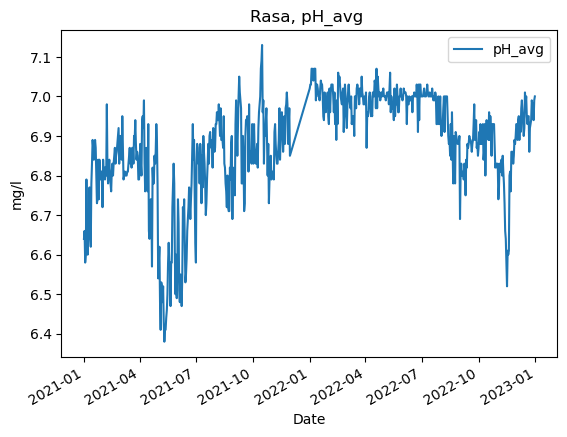

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rasa, Turbidity_avg ')

Text(0, 0.5, 'mg/l')

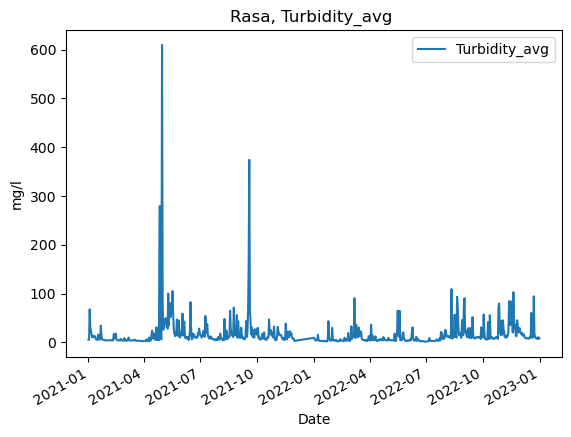

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rasa, Color_avg ')

Text(0, 0.5, 'mg/l')

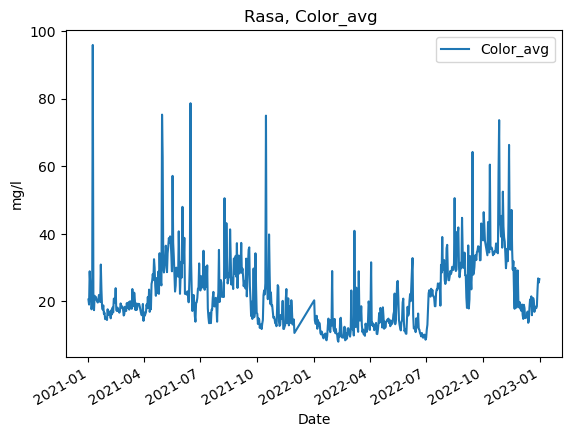

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rasa, Iron_avg ')

Text(0, 0.5, 'mg/l')

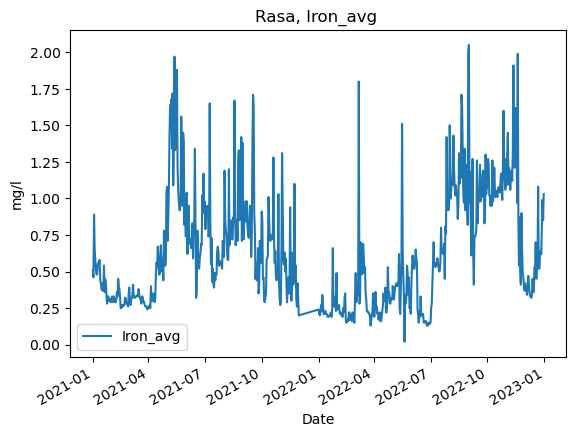

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rasa, Ammonia_avg ')

Text(0, 0.5, 'mg/l')

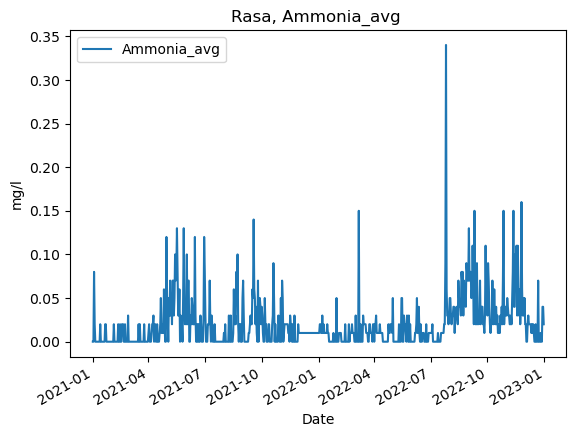

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rasa, Manganese_avg ')

Text(0, 0.5, 'mg/l')

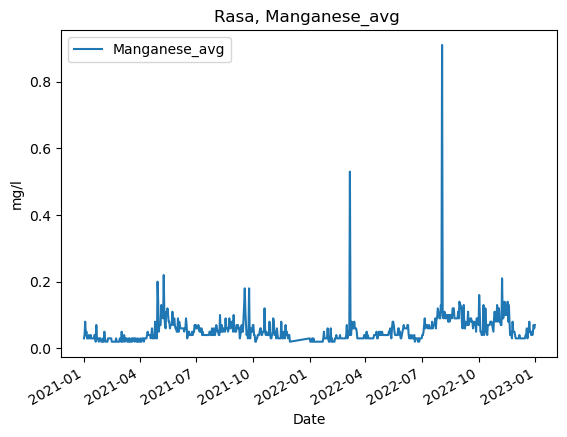

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rasa, Soda_Ash ')

Text(0, 0.5, 'mg/l')

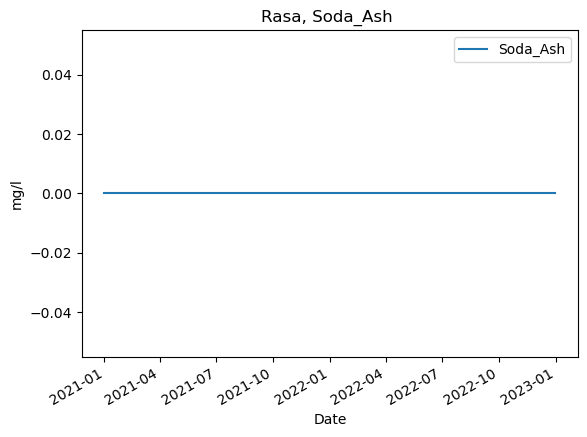

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rasa, Liquid_Chlorine ')

Text(0, 0.5, 'mg/l')

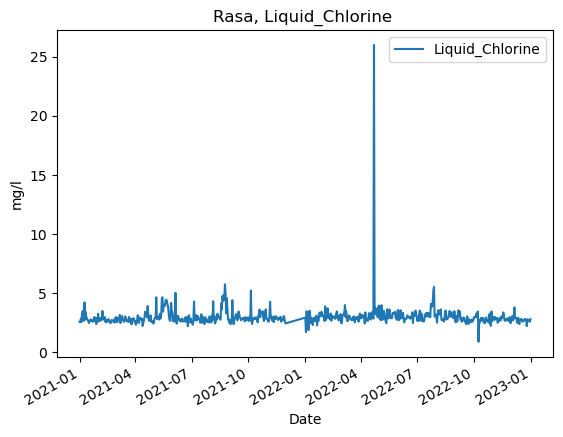

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rasa, Liquid_Polyaluminium_Chloride ')

Text(0, 0.5, 'mg/l')

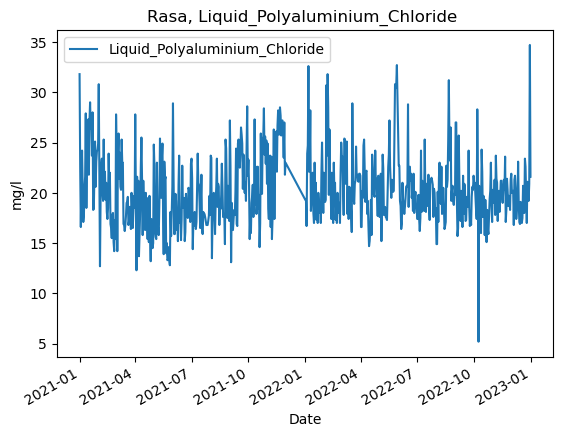

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rasa, Hydrated_Lime ')

Text(0, 0.5, 'mg/l')

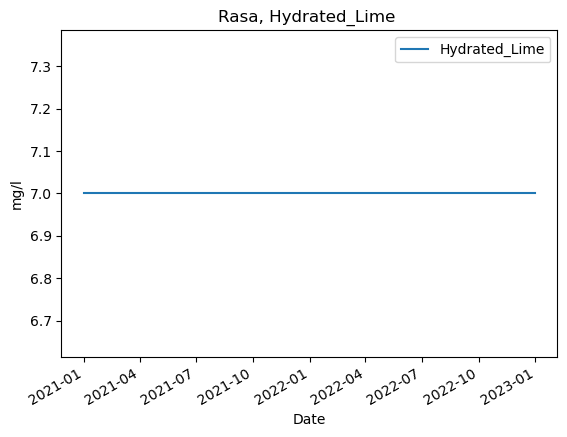

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Rasa, Aluminium_Sulphate ')

Text(0, 0.5, 'mg/l')

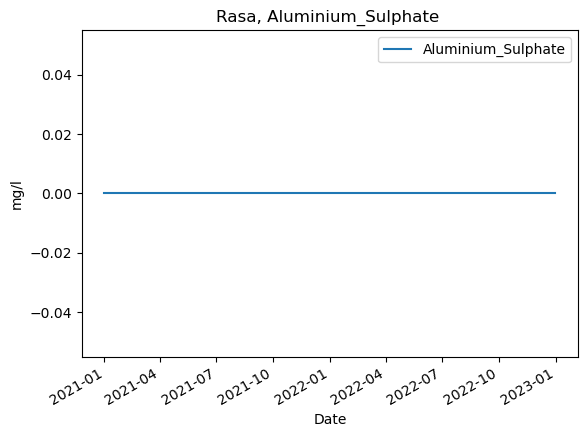

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1, pH_avg ')

Text(0, 0.5, 'mg/l')

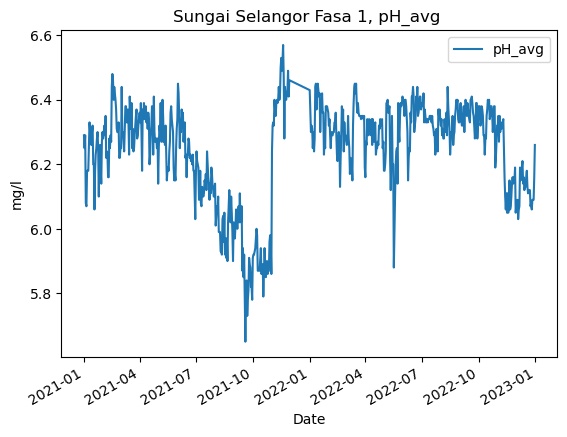

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1, Turbidity_avg ')

Text(0, 0.5, 'mg/l')

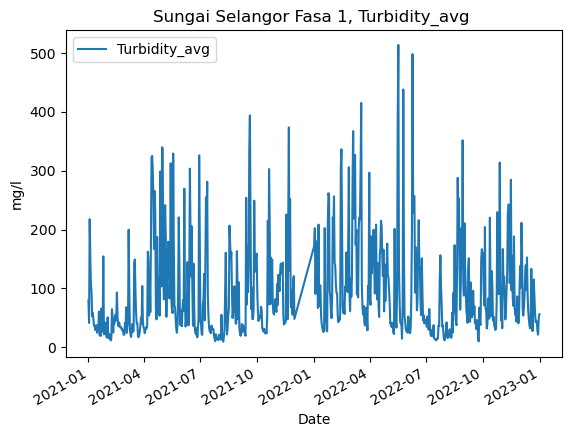

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1, Color_avg ')

Text(0, 0.5, 'mg/l')

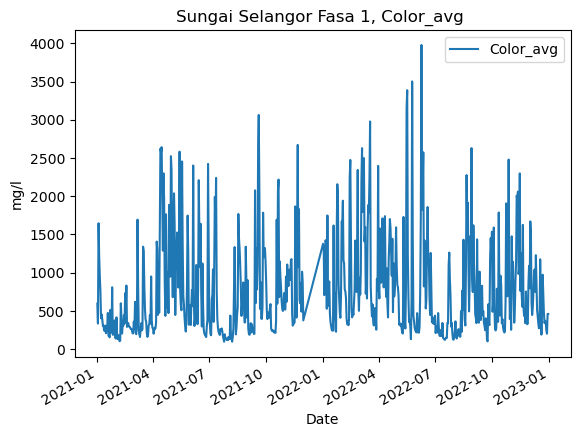

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1, Iron_avg ')

Text(0, 0.5, 'mg/l')

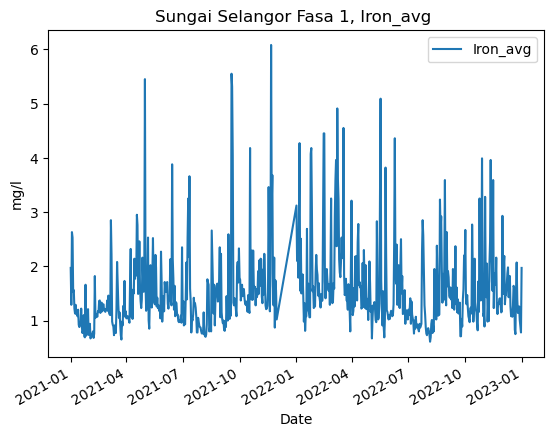

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1, Ammonia_avg ')

Text(0, 0.5, 'mg/l')

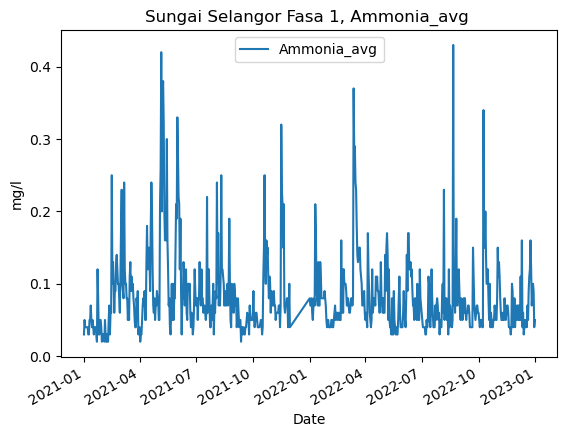

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1, Manganese_avg ')

Text(0, 0.5, 'mg/l')

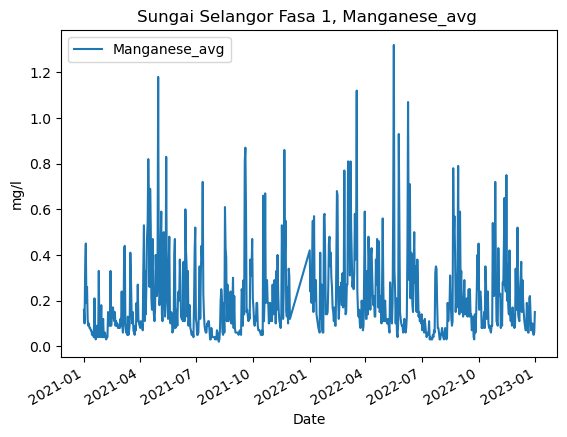

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1, Soda_Ash ')

Text(0, 0.5, 'mg/l')

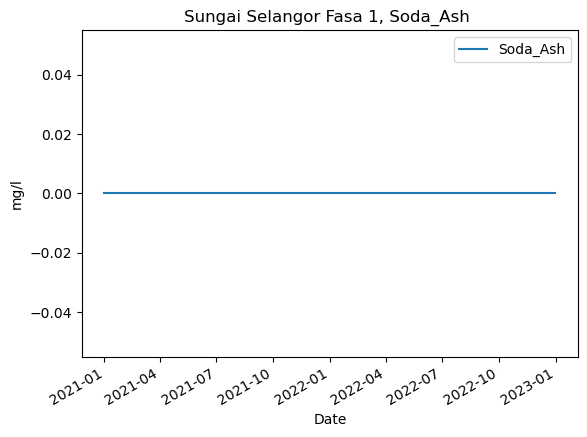

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1, Liquid_Chlorine ')

Text(0, 0.5, 'mg/l')

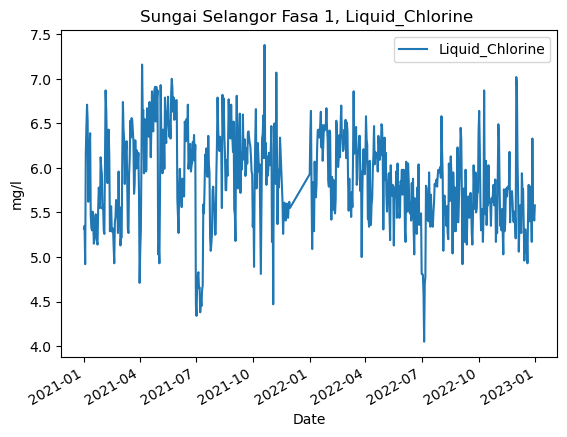

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1, Liquid_Polyaluminium_Chloride ')

Text(0, 0.5, 'mg/l')

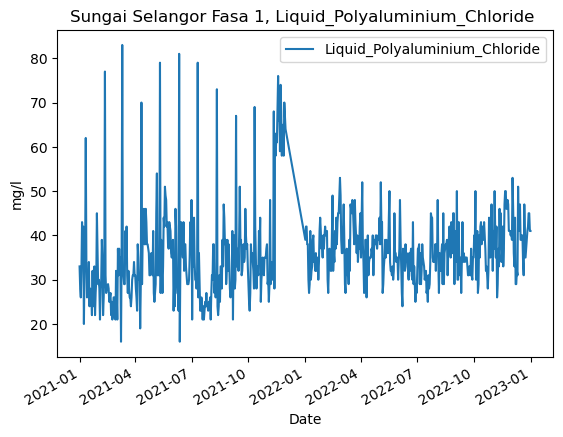

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1, Hydrated_Lime ')

Text(0, 0.5, 'mg/l')

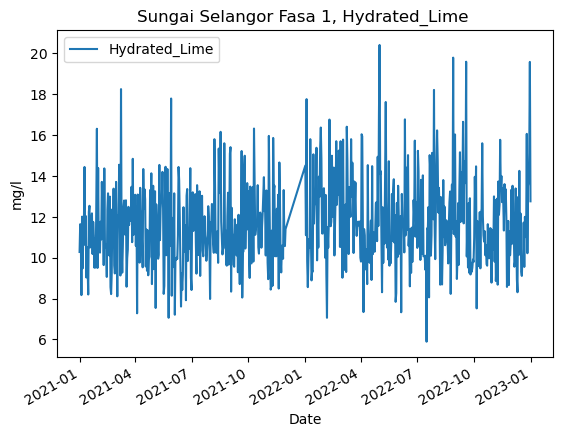

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1, Aluminium_Sulphate ')

Text(0, 0.5, 'mg/l')

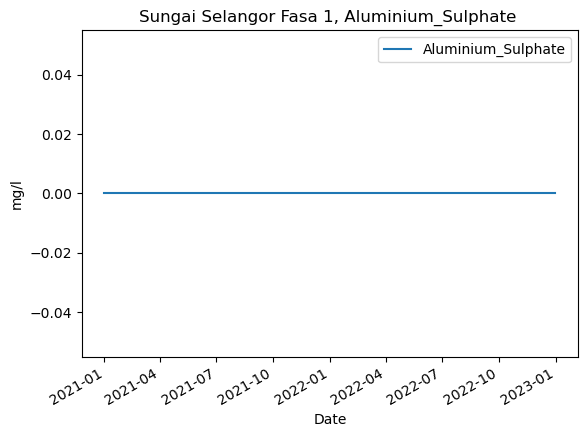

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C, pH_avg ')

Text(0, 0.5, 'mg/l')

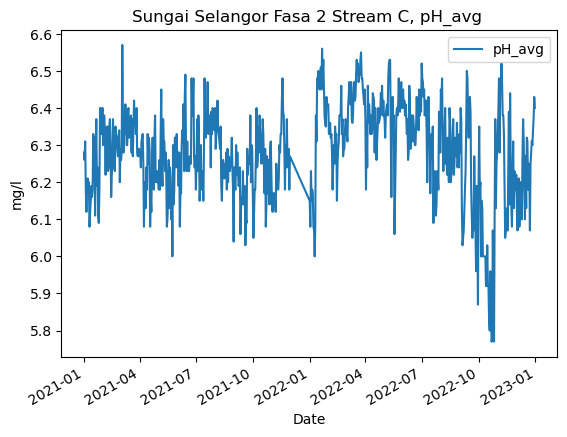

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C, Turbidity_avg ')

Text(0, 0.5, 'mg/l')

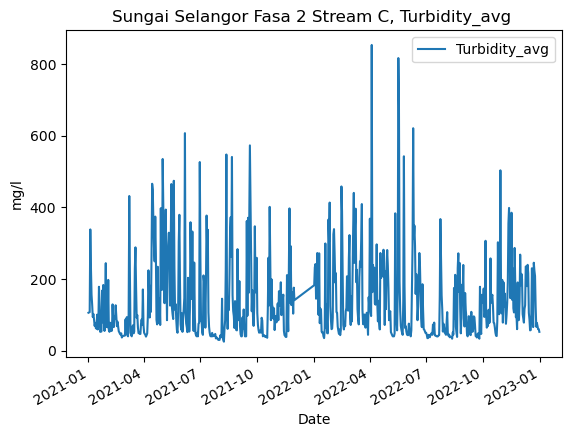

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C, Color_avg ')

Text(0, 0.5, 'mg/l')

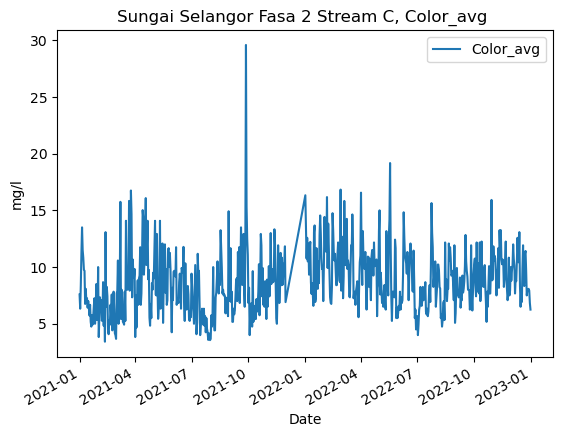

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C, Iron_avg ')

Text(0, 0.5, 'mg/l')

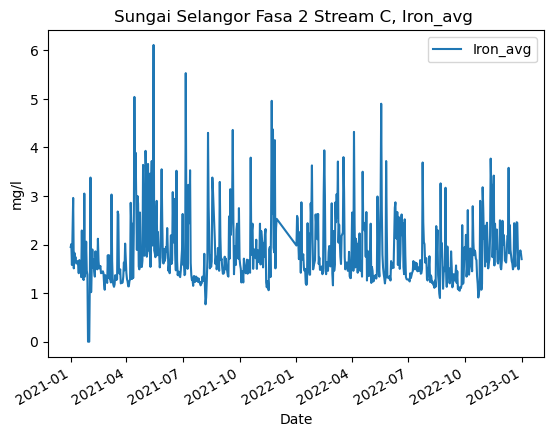

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C, Ammonia_avg ')

Text(0, 0.5, 'mg/l')

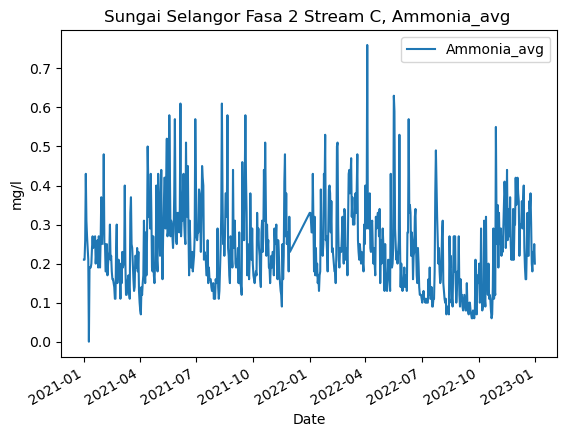

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C, Manganese_avg ')

Text(0, 0.5, 'mg/l')

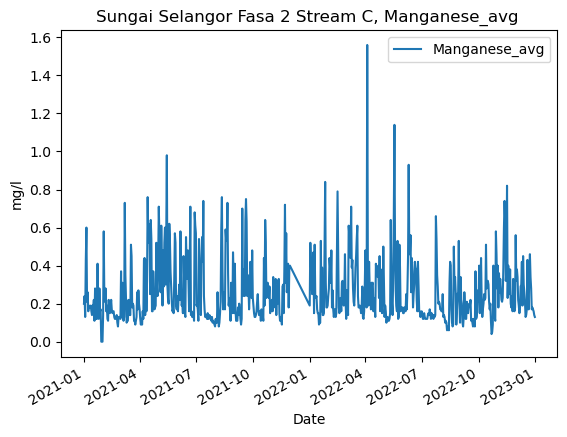

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C, Soda_Ash ')

Text(0, 0.5, 'mg/l')

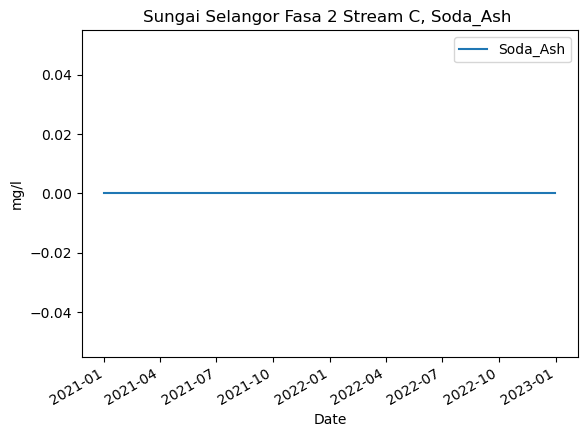

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C, Liquid_Chlorine ')

Text(0, 0.5, 'mg/l')

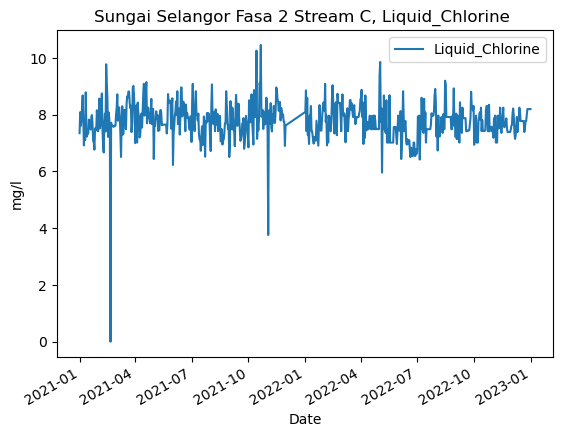

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C, Liquid_Polyaluminium_Chloride ')

Text(0, 0.5, 'mg/l')

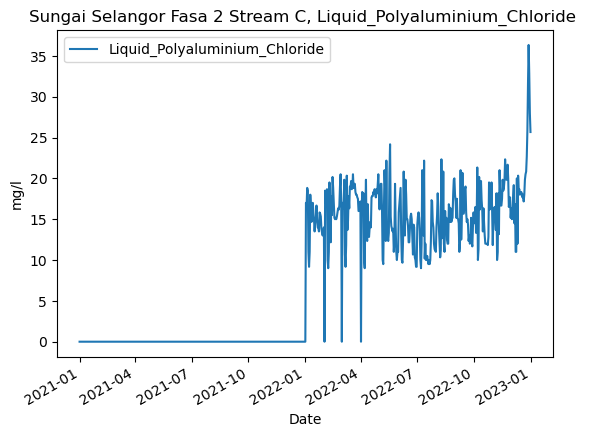

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C, Hydrated_Lime ')

Text(0, 0.5, 'mg/l')

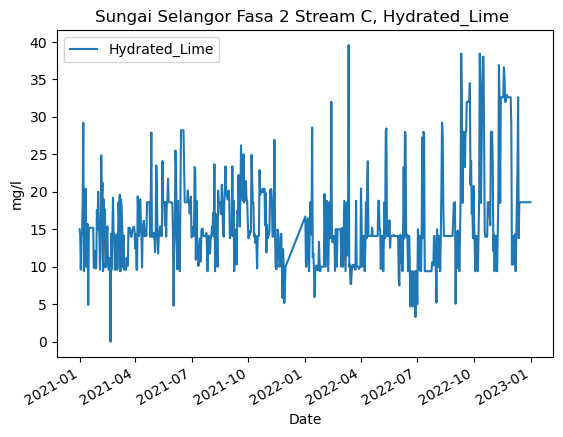

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C, Aluminium_Sulphate ')

Text(0, 0.5, 'mg/l')

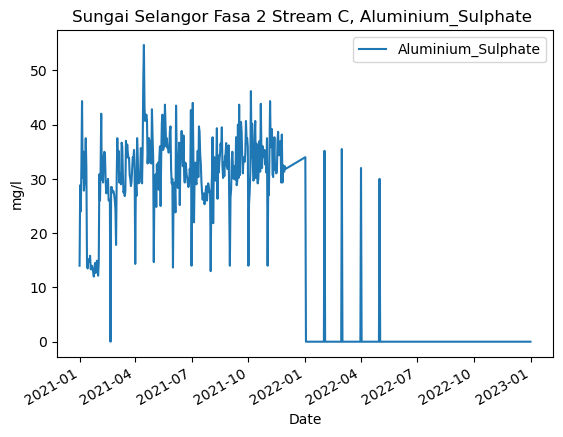

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 1, pH_avg ')

Text(0, 0.5, 'mg/l')

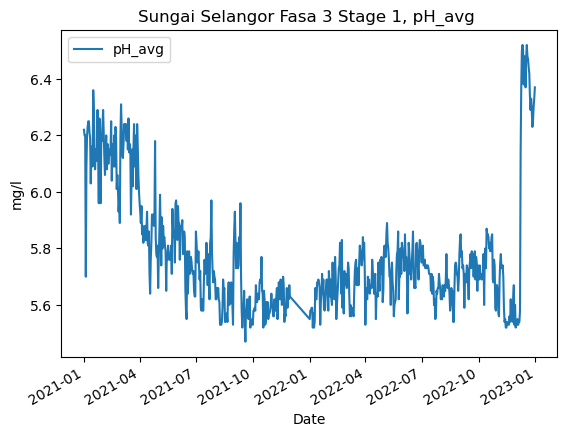

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 1, Turbidity_avg ')

Text(0, 0.5, 'mg/l')

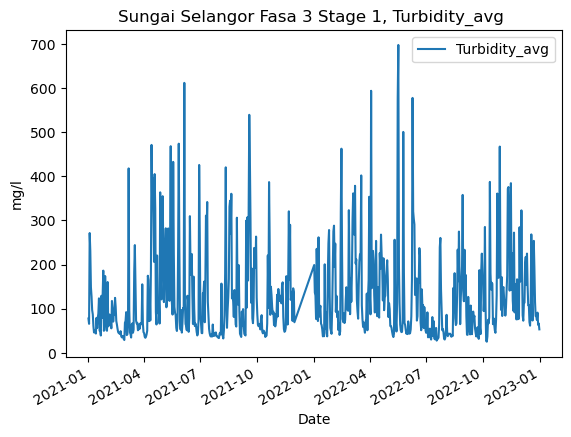

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 1, Color_avg ')

Text(0, 0.5, 'mg/l')

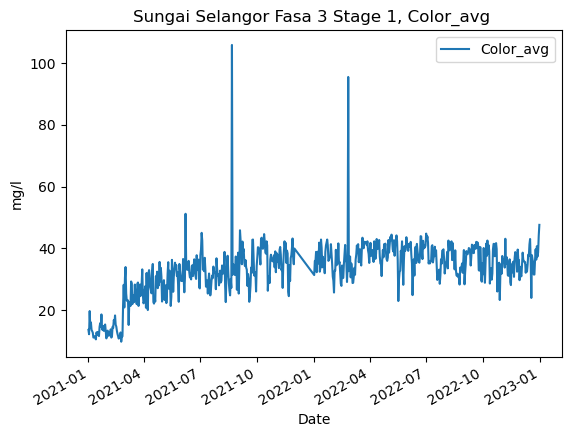

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 1, Iron_avg ')

Text(0, 0.5, 'mg/l')

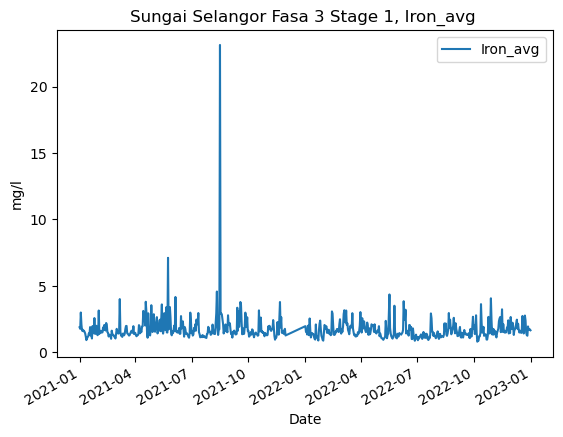

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 1, Ammonia_avg ')

Text(0, 0.5, 'mg/l')

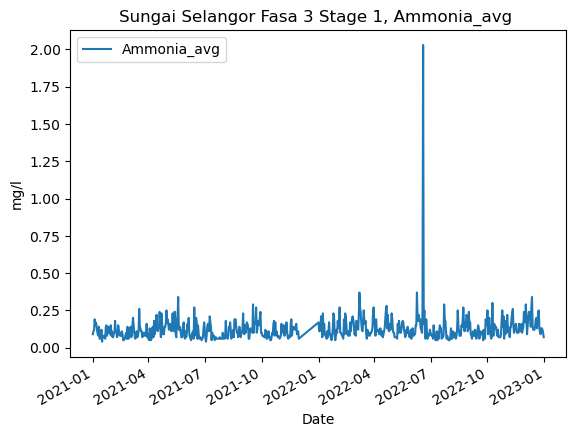

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 1, Manganese_avg ')

Text(0, 0.5, 'mg/l')

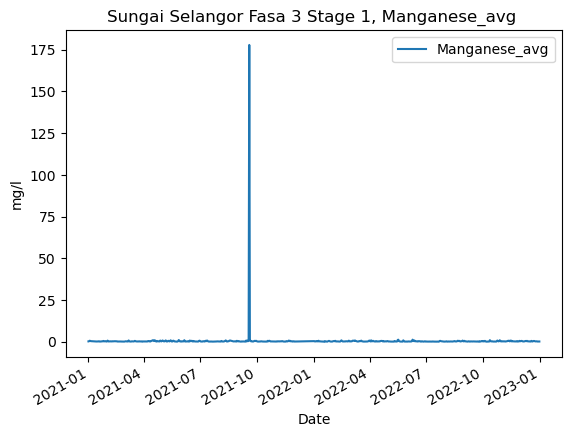

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 1, Soda_Ash ')

Text(0, 0.5, 'mg/l')

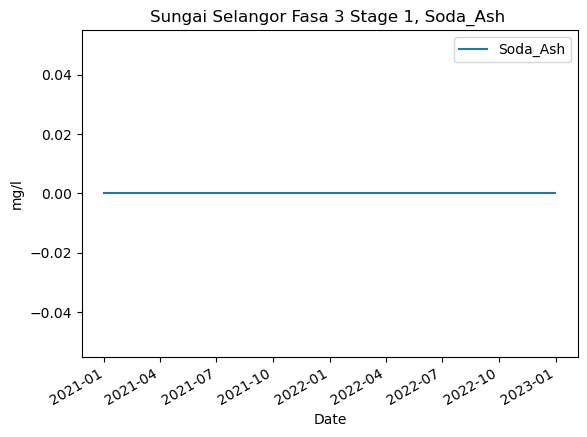

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 1, Liquid_Chlorine ')

Text(0, 0.5, 'mg/l')

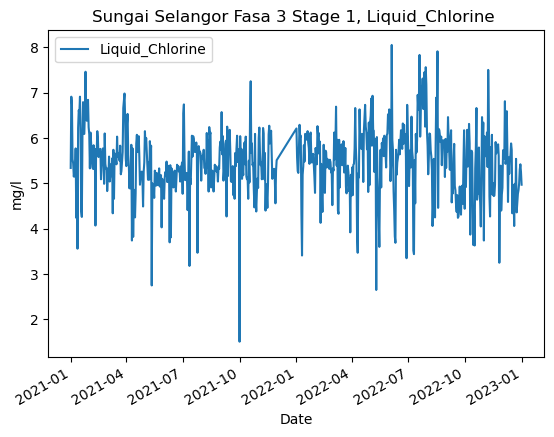

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 1, Liquid_Polyaluminium_Chloride ')

Text(0, 0.5, 'mg/l')

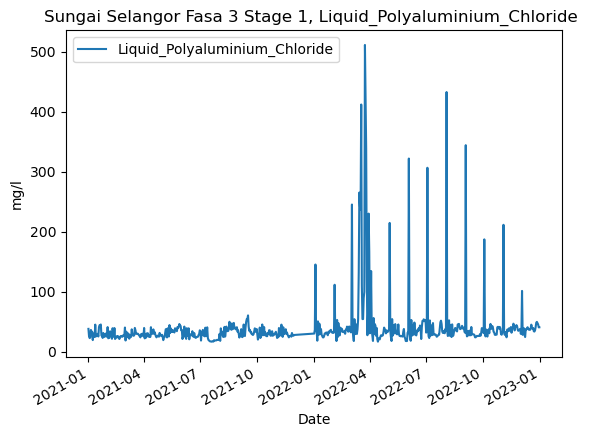

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 1, Hydrated_Lime ')

Text(0, 0.5, 'mg/l')

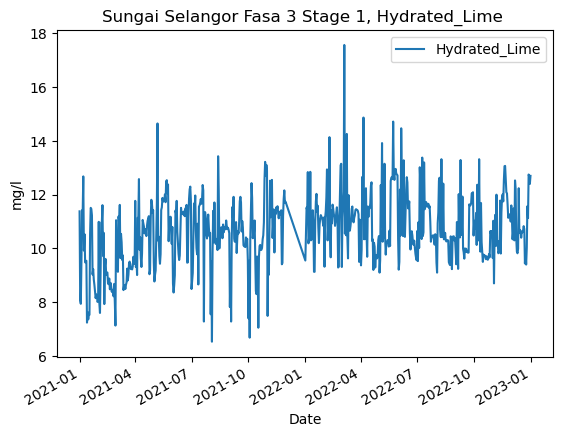

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 1, Aluminium_Sulphate ')

Text(0, 0.5, 'mg/l')

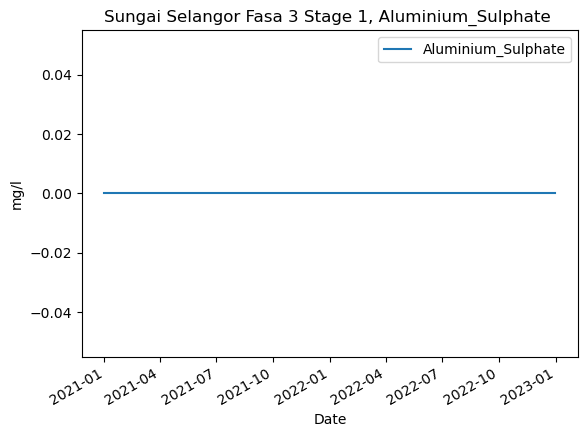

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 2, pH_avg ')

Text(0, 0.5, 'mg/l')

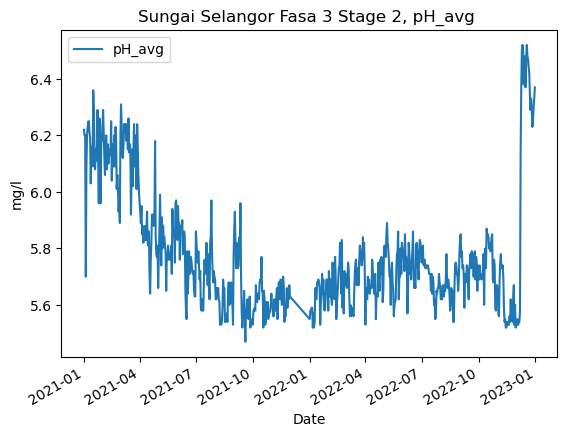

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 2, Turbidity_avg ')

Text(0, 0.5, 'mg/l')

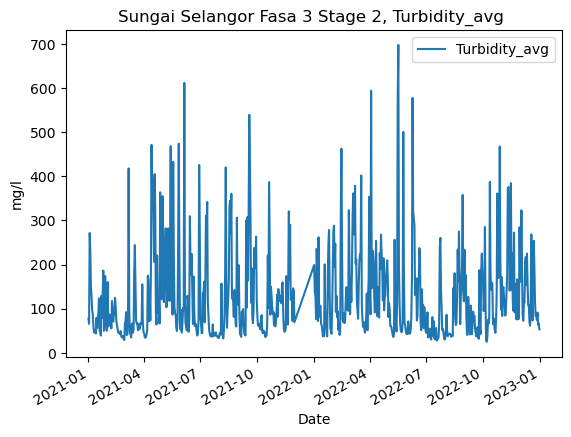

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 2, Color_avg ')

Text(0, 0.5, 'mg/l')

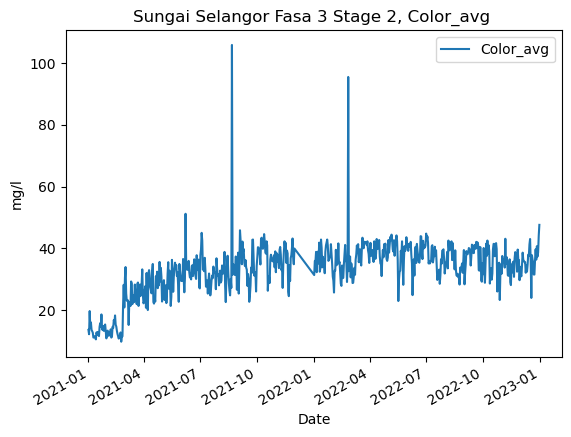

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 2, Iron_avg ')

Text(0, 0.5, 'mg/l')

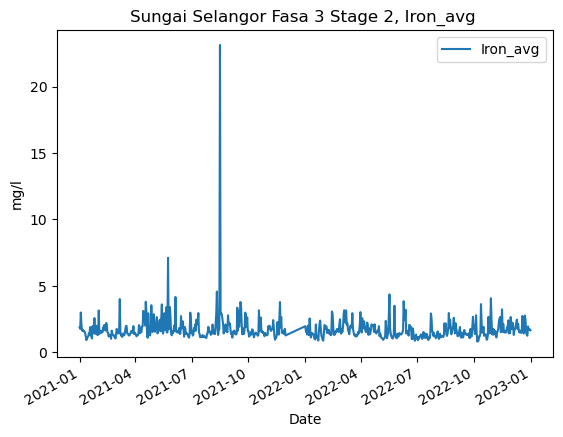

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 2, Ammonia_avg ')

Text(0, 0.5, 'mg/l')

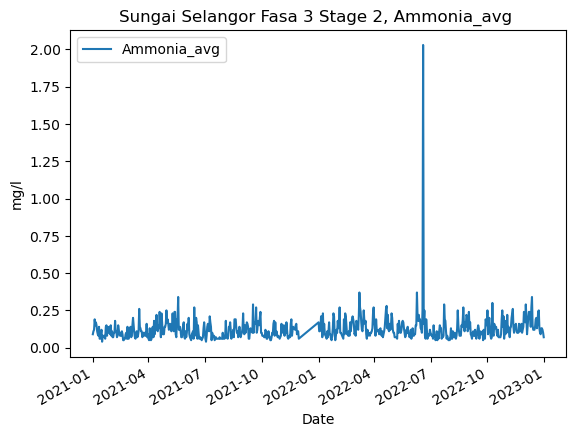

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 2, Manganese_avg ')

Text(0, 0.5, 'mg/l')

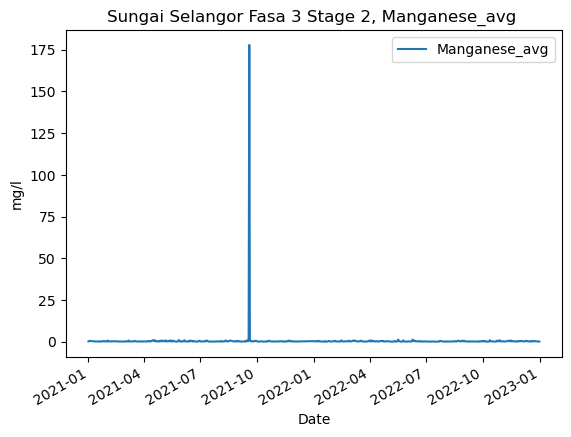

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 2, Soda_Ash ')

Text(0, 0.5, 'mg/l')

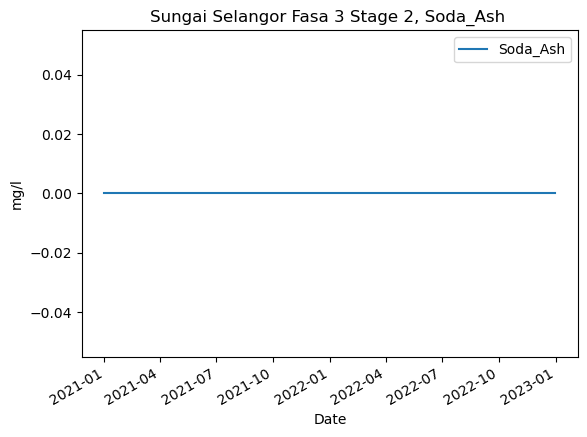

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 2, Liquid_Chlorine ')

Text(0, 0.5, 'mg/l')

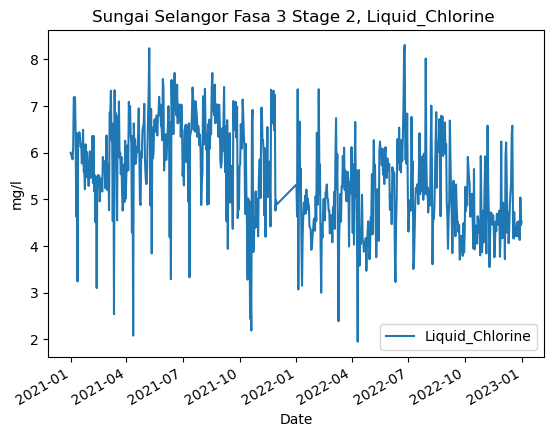

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 2, Liquid_Polyaluminium_Chloride ')

Text(0, 0.5, 'mg/l')

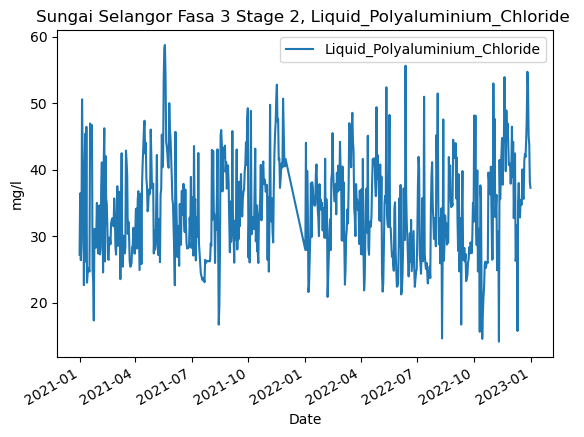

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 2, Hydrated_Lime ')

Text(0, 0.5, 'mg/l')

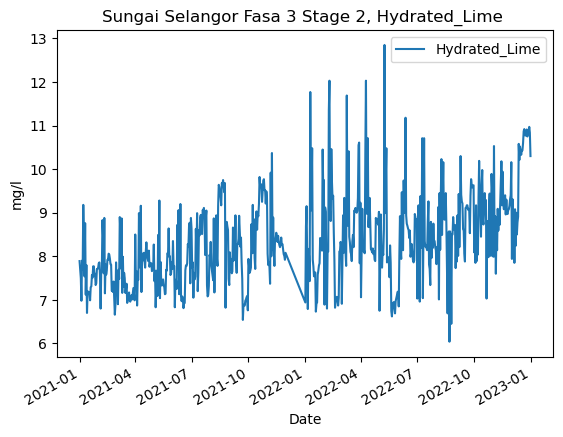

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 2, Aluminium_Sulphate ')

Text(0, 0.5, 'mg/l')

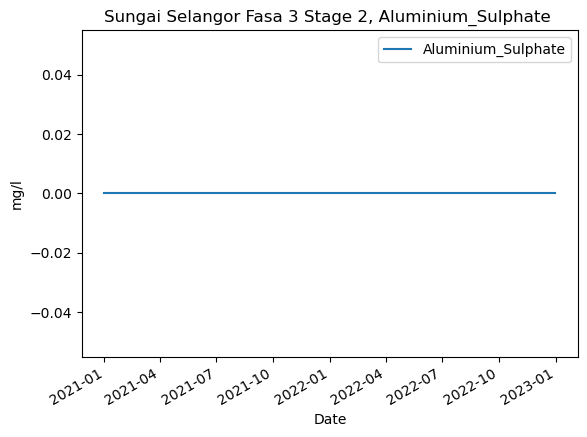

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream D, pH_avg ')

Text(0, 0.5, 'mg/l')

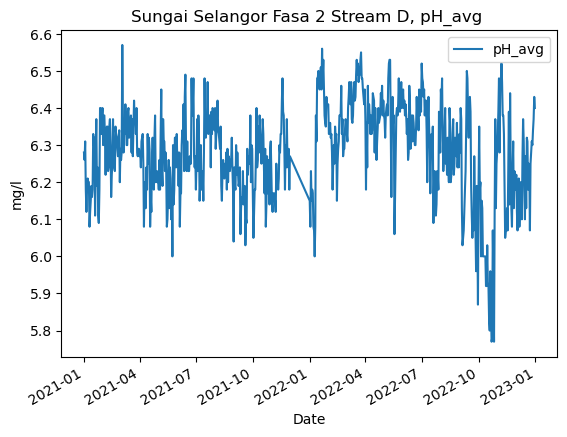

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream D, Turbidity_avg ')

Text(0, 0.5, 'mg/l')

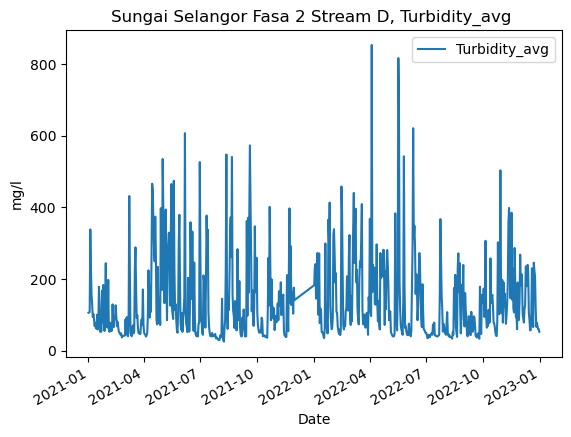

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream D, Color_avg ')

Text(0, 0.5, 'mg/l')

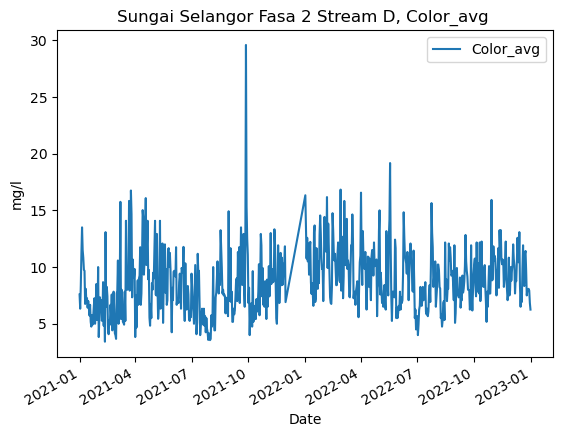

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream D, Iron_avg ')

Text(0, 0.5, 'mg/l')

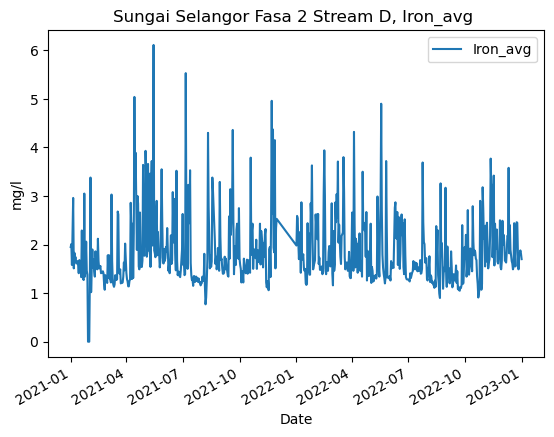

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream D, Ammonia_avg ')

Text(0, 0.5, 'mg/l')

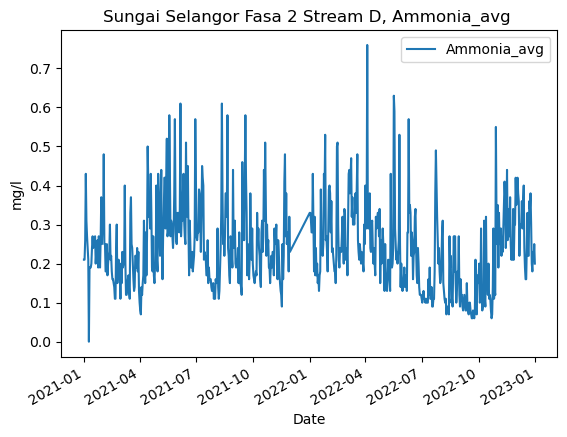

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream D, Manganese_avg ')

Text(0, 0.5, 'mg/l')

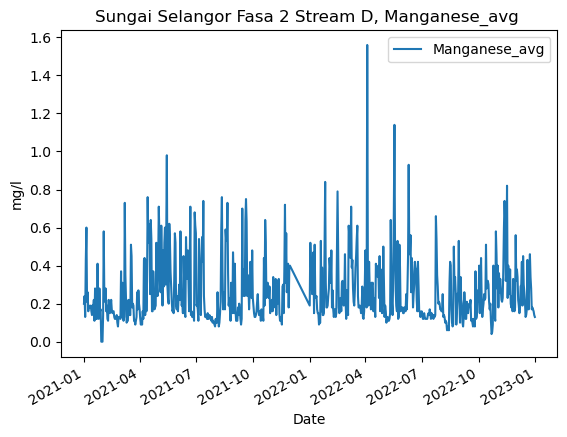

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream D, Soda_Ash ')

Text(0, 0.5, 'mg/l')

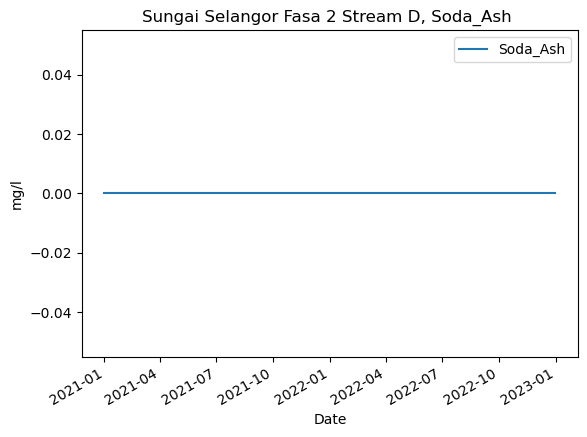

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream D, Liquid_Chlorine ')

Text(0, 0.5, 'mg/l')

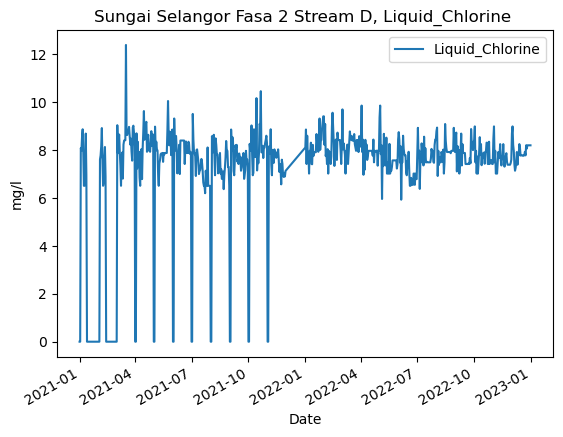

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream D, Liquid_Polyaluminium_Chloride ')

Text(0, 0.5, 'mg/l')

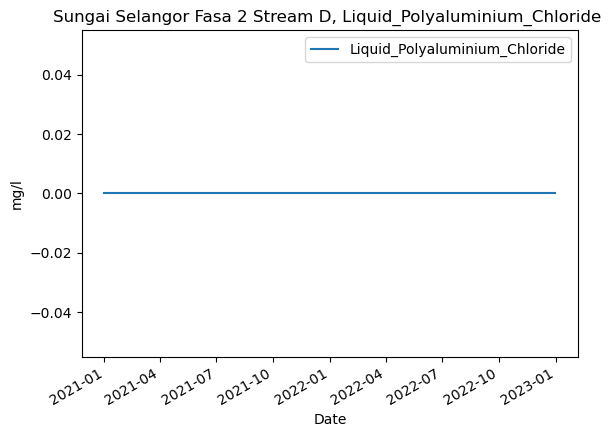

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream D, Hydrated_Lime ')

Text(0, 0.5, 'mg/l')

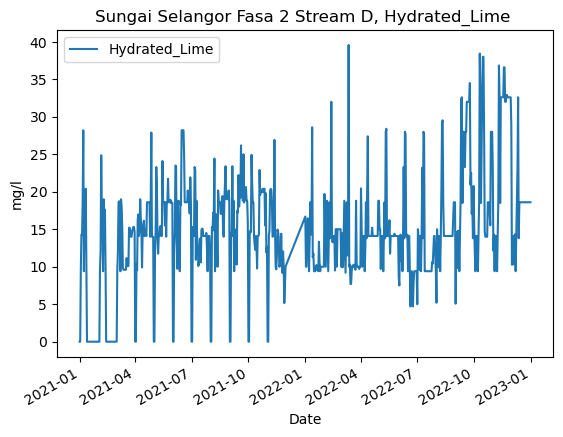

<AxesSubplot:xlabel='Date'>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream D, Aluminium_Sulphate ')

Text(0, 0.5, 'mg/l')

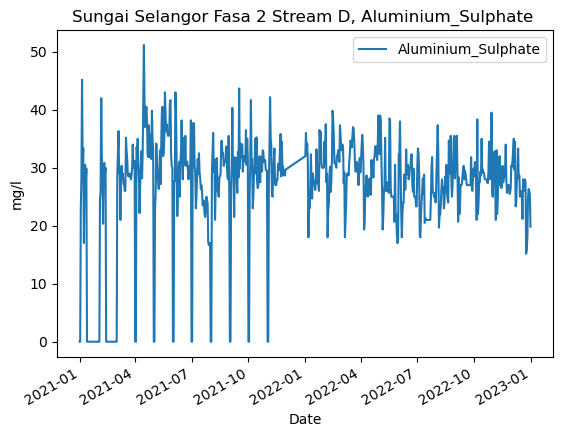

In [48]:
  
hi = ['pH_avg', 'Turbidity_avg', 'Color_avg', 'Iron_avg',
       'Ammonia_avg', 'Manganese_avg',
       'Soda_Ash', 'Liquid_Chlorine',
       'Liquid_Polyaluminium_Chloride', 'Hydrated_Lime', 'Aluminium_Sulphate']
for i in jam8['wtp'].unique():
    for j in hi:
        a = jam8[jam8['wtp']==i].copy()
        a['Date'] = pd.to_datetime(a['Date'])
        #db['Month'] = db['Date'].dt.strftime('%m-%Y')

        a.plot(x='Date',y=[j])
        plt.title(f'{i}, {j} ')
        plt.ylabel('mg/l')


        plt.show()


## Unit Cost Comparison

In [54]:
uc = pd.read_csv('unit_cost_v2.csv')
uc = uc.rename(columns={'n_wtp':'wtp','UnitCost (cent per m3)':'Unit_cost'})
uc['Month'] = pd.to_datetime(uc['Month'].astype(str) + uc['Year'].astype(str), format='%m%Y').dt.strftime('%m-%Y')
#c2['Month'] = pd.to_datetime(c2['Month'].astype(str) + c2['Year'].astype(str), format='%m%Y').dt.strftime('%m-%Y')
uc1 = uc[uc['Year']==2021].copy()

In [55]:
ud = pd.read_csv('unit_cost_v2_2022.csv')
ud['Year'] = 2022
ud['Month'] = pd.to_datetime(ud['Month'], format="%b-%y").dt.strftime('%m-%Y')
uc1 = pd.concat([uc1,ud],axis = 0)
#print(uc1[uc1['wtp'] == 'Sungai Selangor Fasa 2 Stream D'])

In [56]:
c2['Month'] = pd.to_datetime(c2['Month'], format="%m-%Y")
uc1['Month'] = pd.to_datetime(uc1['Month'], format="%m-%Y")
fc = pd.merge(c2,uc1[['wtp','Month','Unit_cost']],on=['wtp','Month'],how='left')
fc['Month'] = pd.to_datetime(fc['Month'], format="%m-%Y")

In [57]:
fc = fc[(fc['Month'] < '10-2022')]#& (fc['Month'] < '10-2022')


## Graph

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WGI')

(93.967511278431, 98.3243108097462)

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Batang Kali')

Text(0, 0.5, 'Unit Cost')

(12.5939883, 25.97722112)

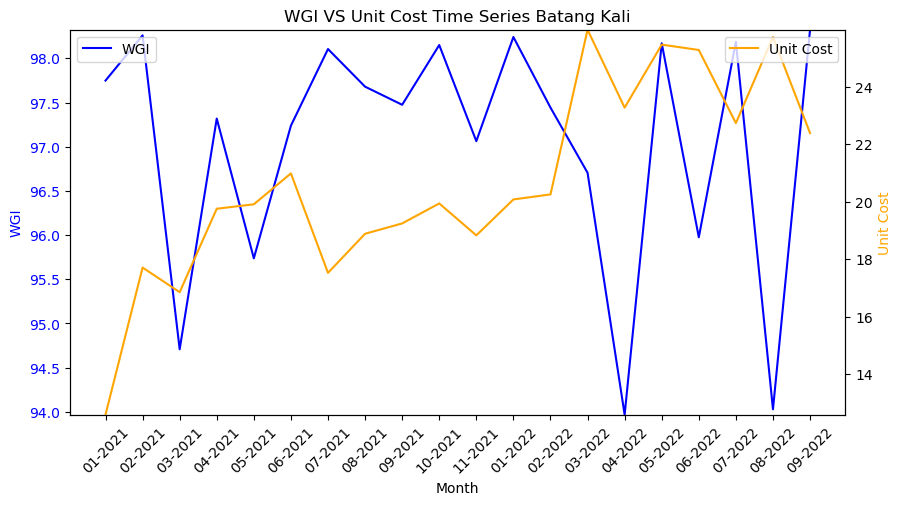

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WQI')

(78.6, 95.3)

Text(0.5, 1.0, 'WQI VS Unit Cost Time Series Batang Kali')

Text(0, 0.5, 'Unit Cost')

(12.5939883, 25.97722112)

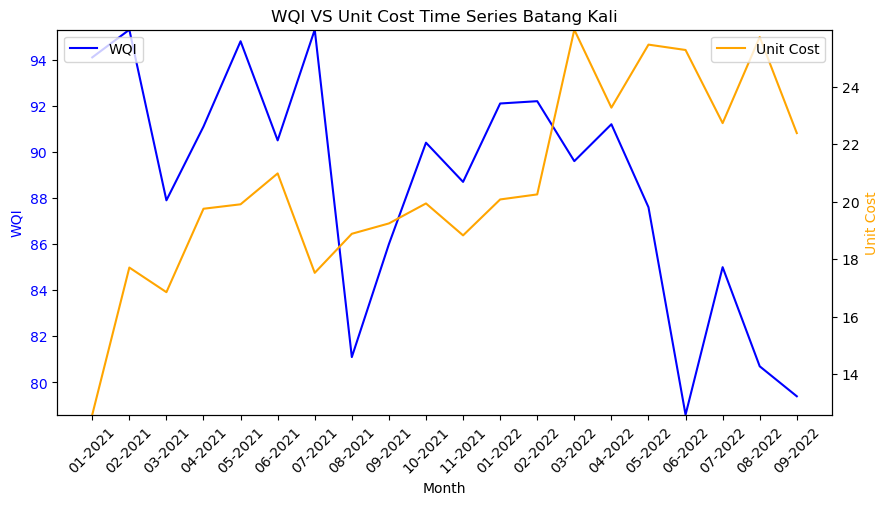

<AxesSubplot:>

Text(0.5, 1.0, 'Batang Kali')

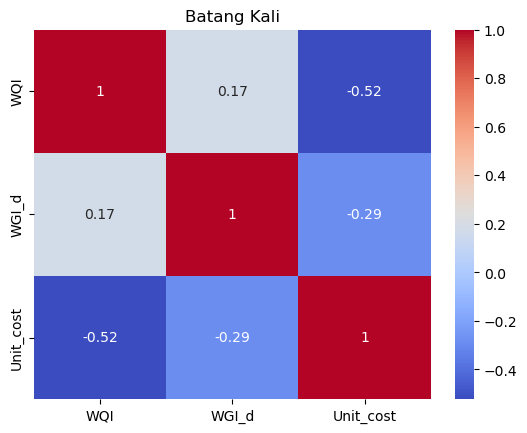

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WGI')

(84.67233382080968, 96.07243492915799)

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Kuala Kubu Bharu')

Text(0, 0.5, 'Unit Cost')

(4.04567384, 5.602269926)

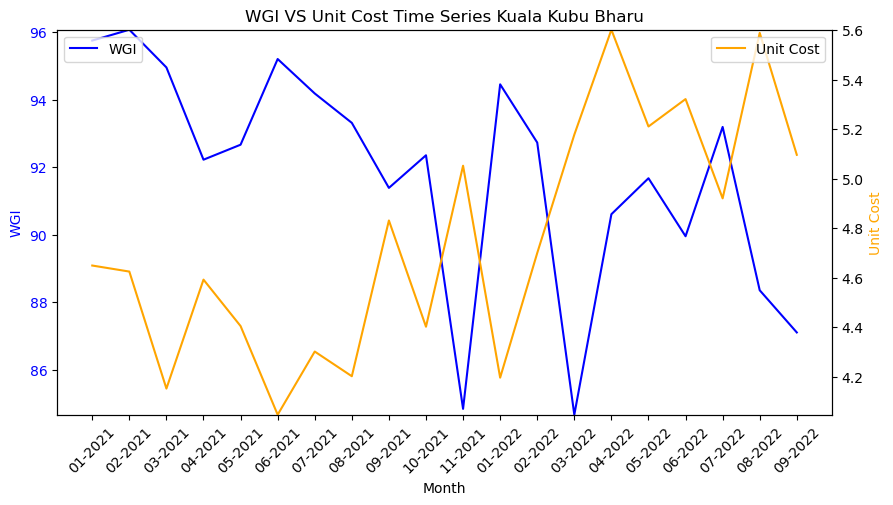

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WQI')

(89.1, 97.2)

Text(0.5, 1.0, 'WQI VS Unit Cost Time Series Kuala Kubu Bharu')

Text(0, 0.5, 'Unit Cost')

(4.04567384, 5.602269926)

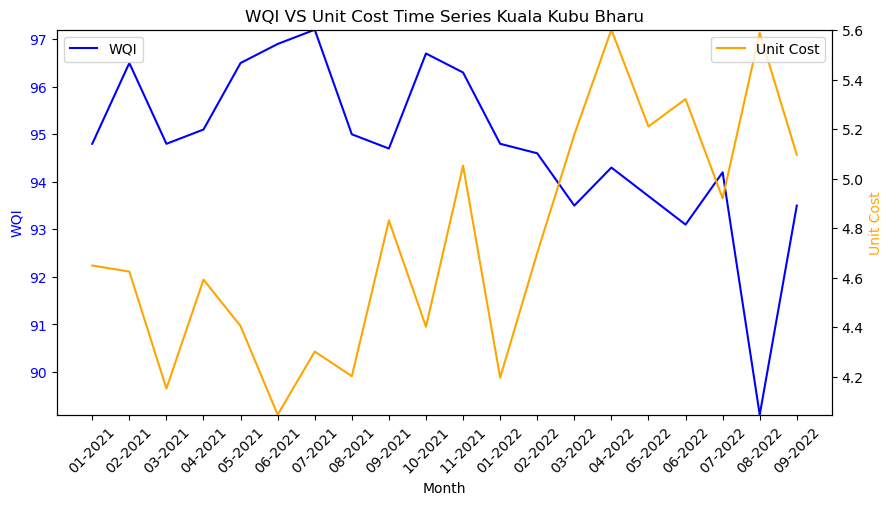

<AxesSubplot:>

Text(0.5, 1.0, 'Kuala Kubu Bharu')

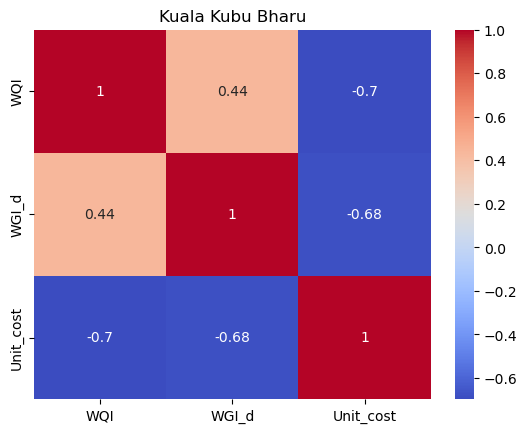

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WGI')

(29.736686069334333, 48.85181739108239)

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Rantau Panjang New')

Text(0, 0.5, 'Unit Cost')

(4.398378643, 6.28399948)

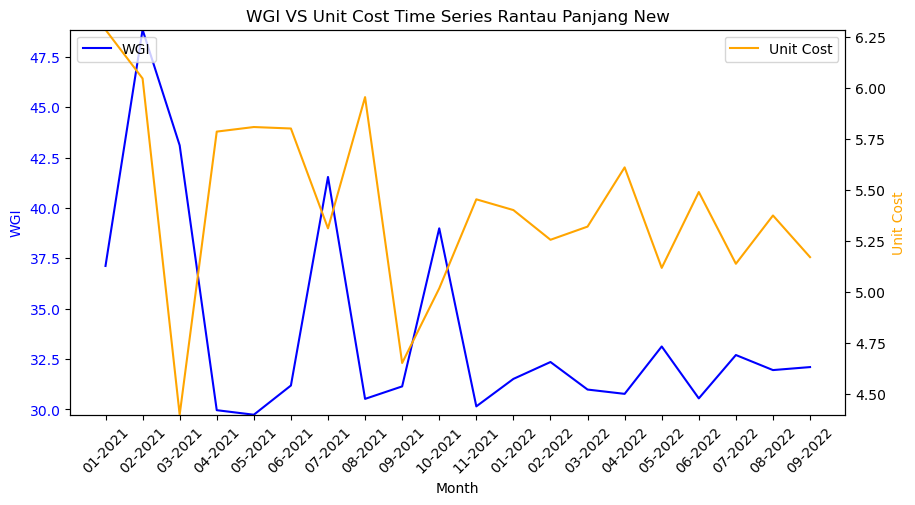

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WQI')

(79.9, 90.3)

Text(0.5, 1.0, 'WQI VS Unit Cost Time Series Rantau Panjang New')

Text(0, 0.5, 'Unit Cost')

(4.398378643, 6.28399948)

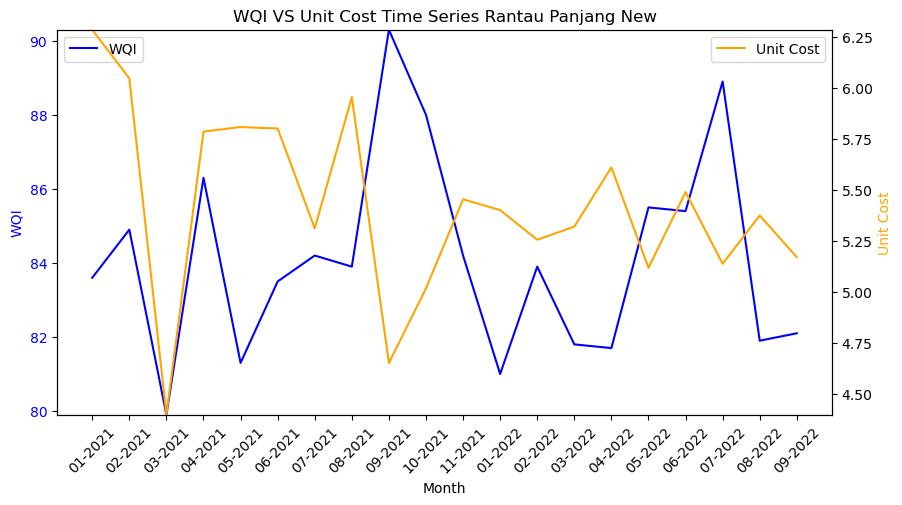

<AxesSubplot:>

Text(0.5, 1.0, 'Rantau Panjang New')

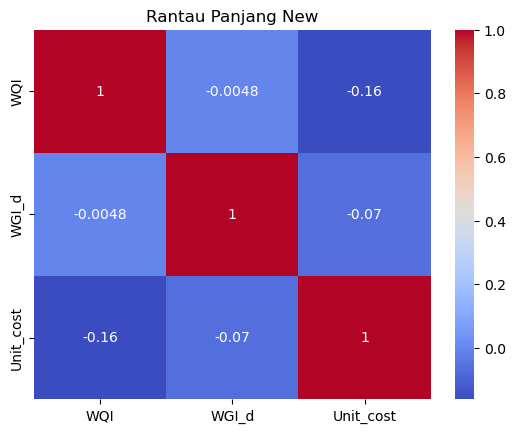

<AxesSubplot:>

Text(0.5, 1.0, 'Rantau Panjang Old')

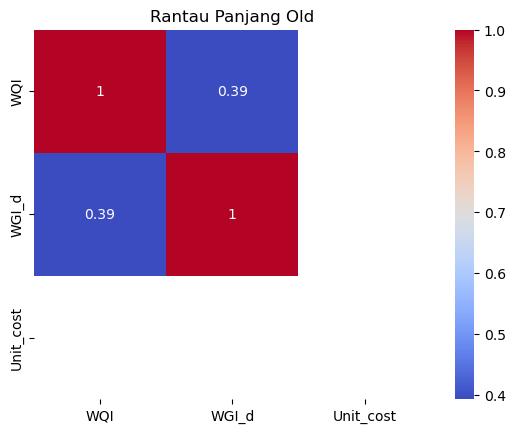

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WGI')

(80.41029623281683, 94.2236205334415)

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Rasa')

Text(0, 0.5, 'Unit Cost')

(0.005531281, 3.132712903)

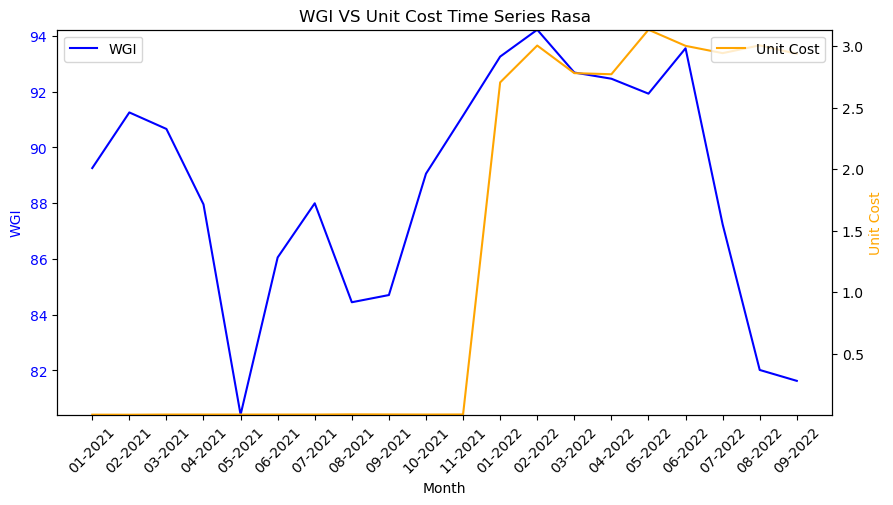

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WQI')

(77.9, 96.4)

Text(0.5, 1.0, 'WQI VS Unit Cost Time Series Rasa')

Text(0, 0.5, 'Unit Cost')

(0.005531281, 3.132712903)

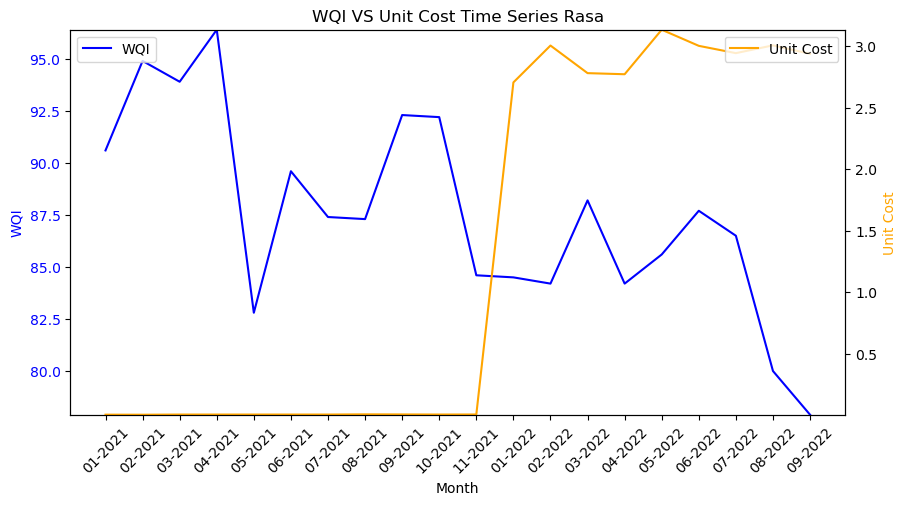

<AxesSubplot:>

Text(0.5, 1.0, 'Rasa')

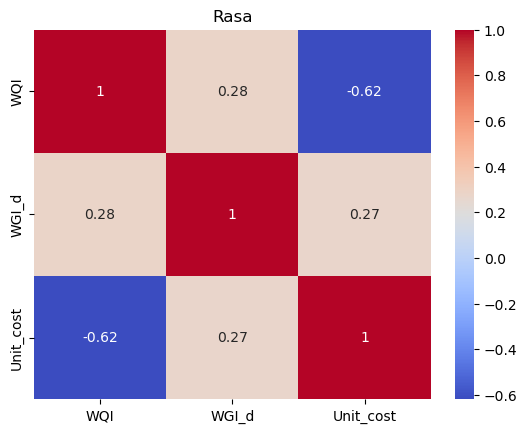

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WGI')

(95.81325561812147, 98.04235647623192)

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Rangkap')

Text(0, 0.5, 'Unit Cost')

(3.550558378, 6.179885627)

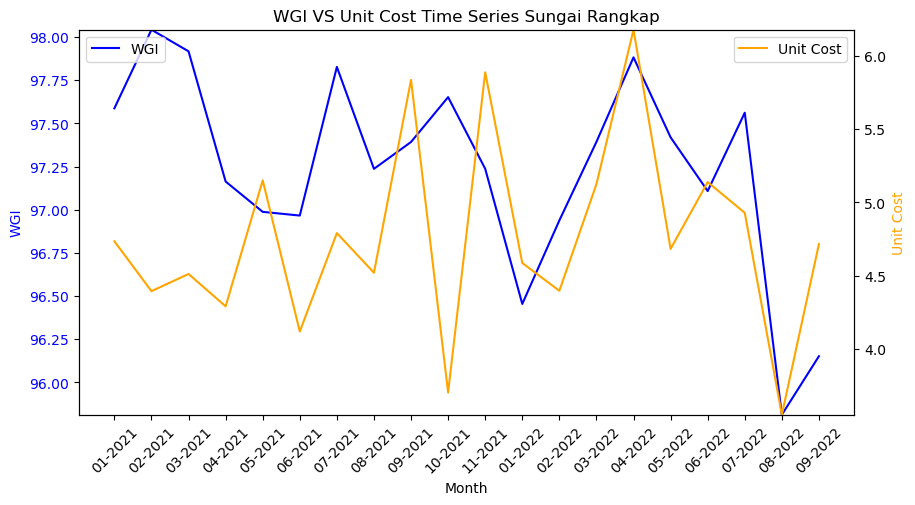

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WQI')

(86.9, 96.7)

Text(0.5, 1.0, 'WQI VS Unit Cost Time Series Sungai Rangkap')

Text(0, 0.5, 'Unit Cost')

(3.550558378, 6.179885627)

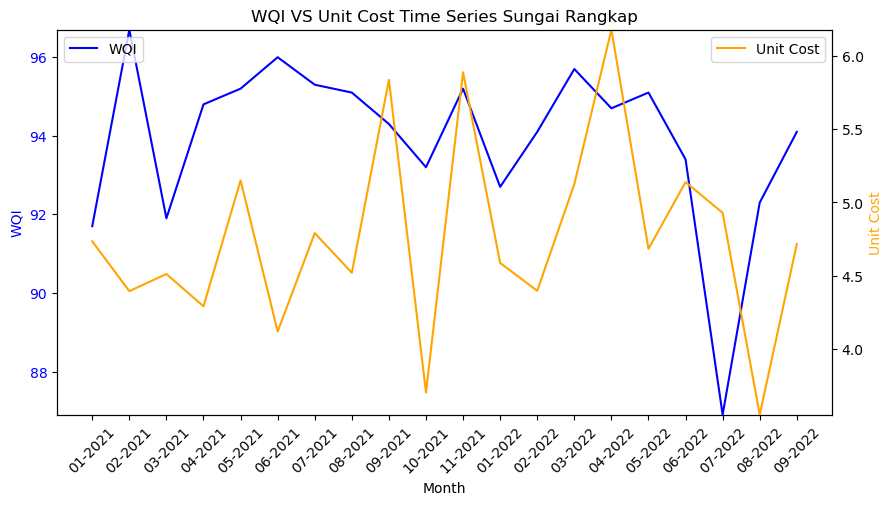

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Rangkap')

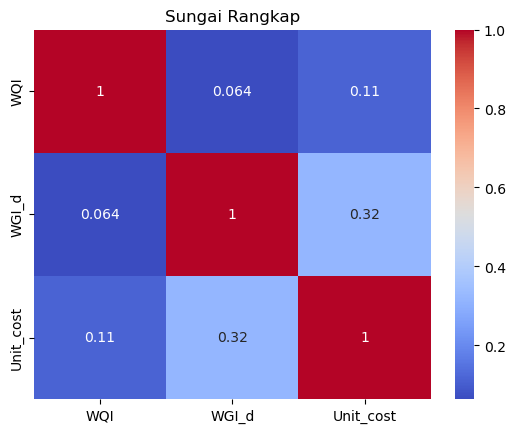

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WGI')

(30.542164108688105, 34.455114951762646)

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 1')

Text(0, 0.5, 'Unit Cost')

(1.23253825, 5.26513347)

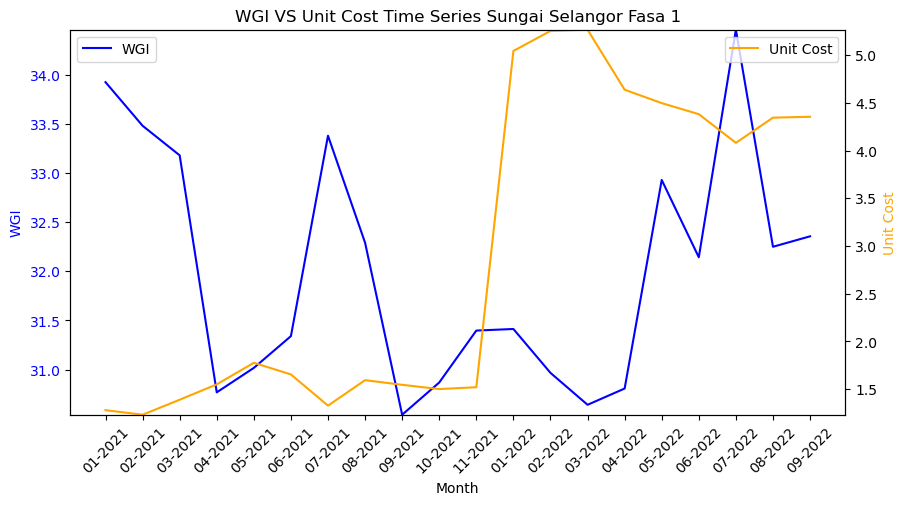

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WQI')

(71.0, 89.0)

Text(0.5, 1.0, 'WQI VS Unit Cost Time Series Sungai Selangor Fasa 1')

Text(0, 0.5, 'Unit Cost')

(1.23253825, 5.26513347)

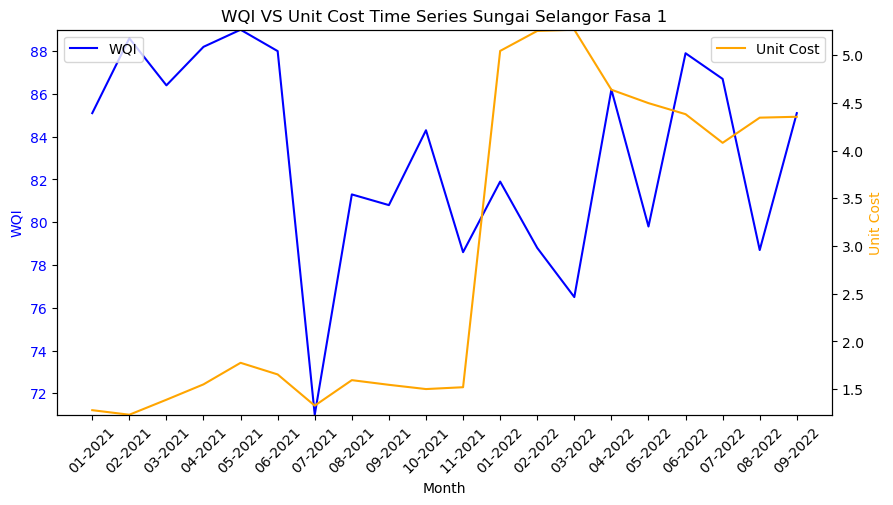

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 1')

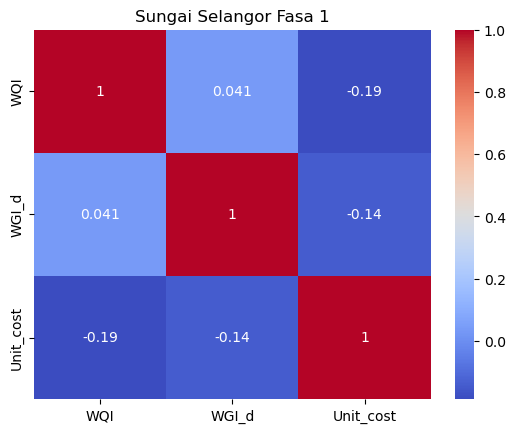

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WGI')

(84.2703644940725, 88.61991894434682)

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 2 Stream C')

Text(0, 0.5, 'Unit Cost')

(4.097549847, 5.32976419)

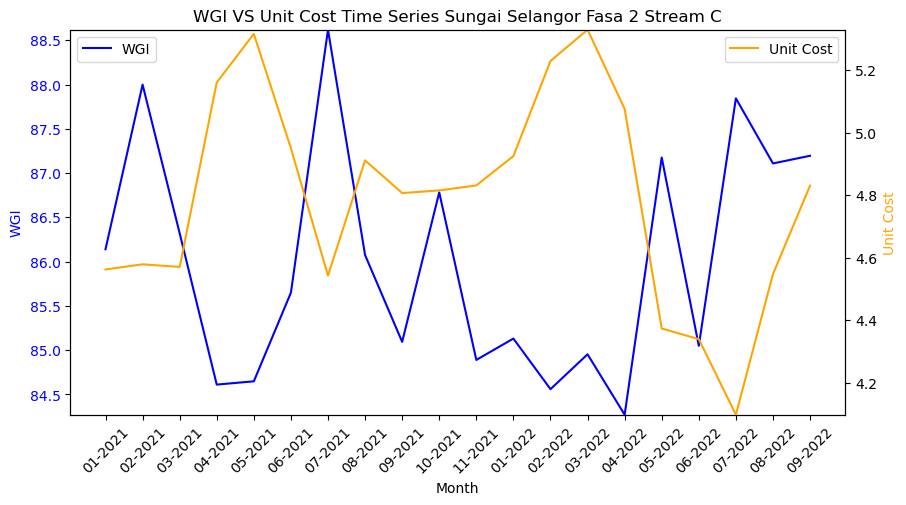

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WQI')

(77.4, 88.7)

Text(0.5, 1.0, 'WQI VS Unit Cost Time Series Sungai Selangor Fasa 2 Stream C')

Text(0, 0.5, 'Unit Cost')

(4.097549847, 5.32976419)

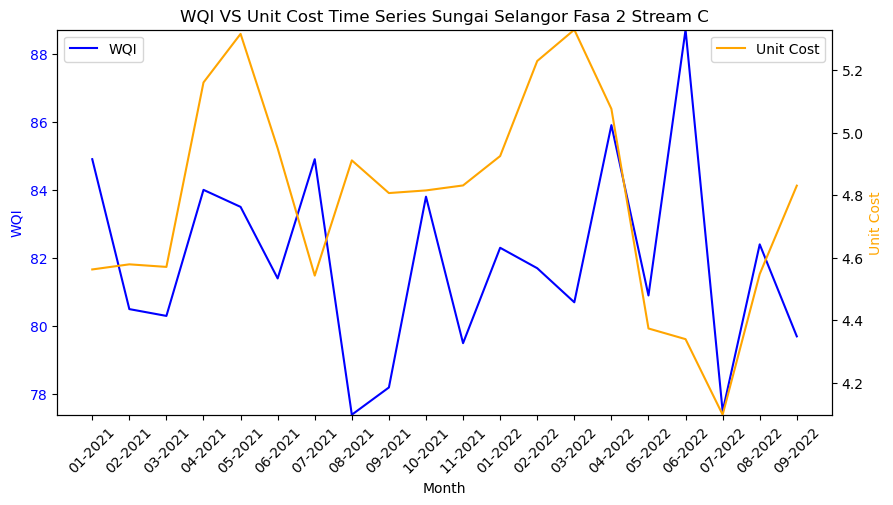

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream C')

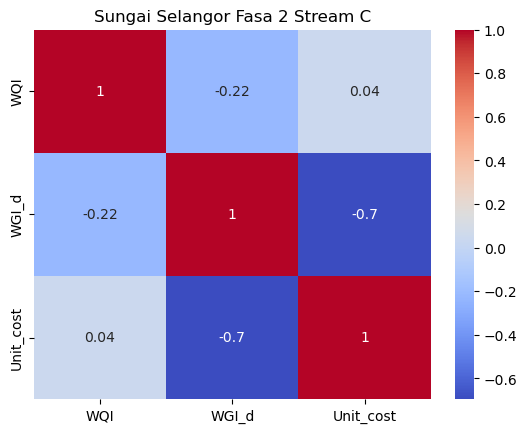

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WGI')

(84.2703644940725, 88.61991894434682)

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 2 Stream D')

Text(0, 0.5, 'Unit Cost')

(4.097549847, 5.32976419)

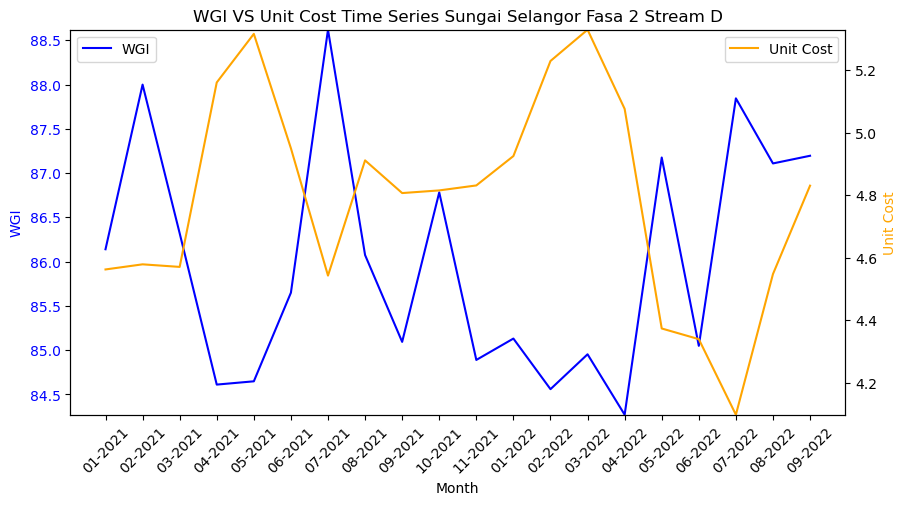

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WQI')

(77.4, 88.7)

Text(0.5, 1.0, 'WQI VS Unit Cost Time Series Sungai Selangor Fasa 2 Stream D')

Text(0, 0.5, 'Unit Cost')

(4.097549847, 5.32976419)

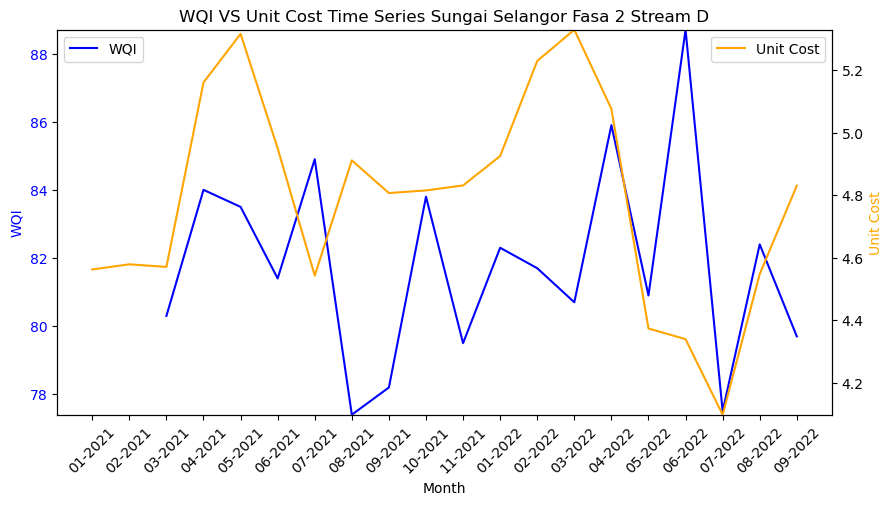

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 2 Stream D')

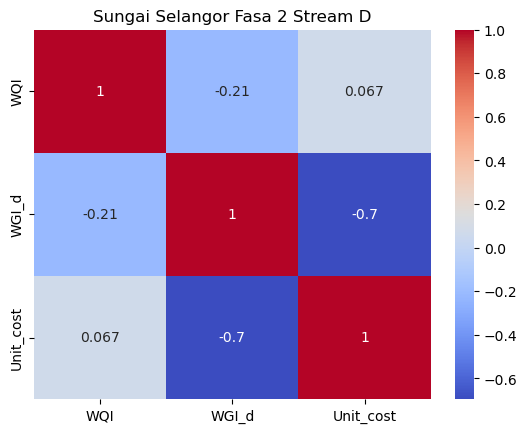

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WGI')

(70.9648698841468, 84.27728211294072)

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 3 Stage 1')

Text(0, 0.5, 'Unit Cost')

(4.340702424, 5.343844175)

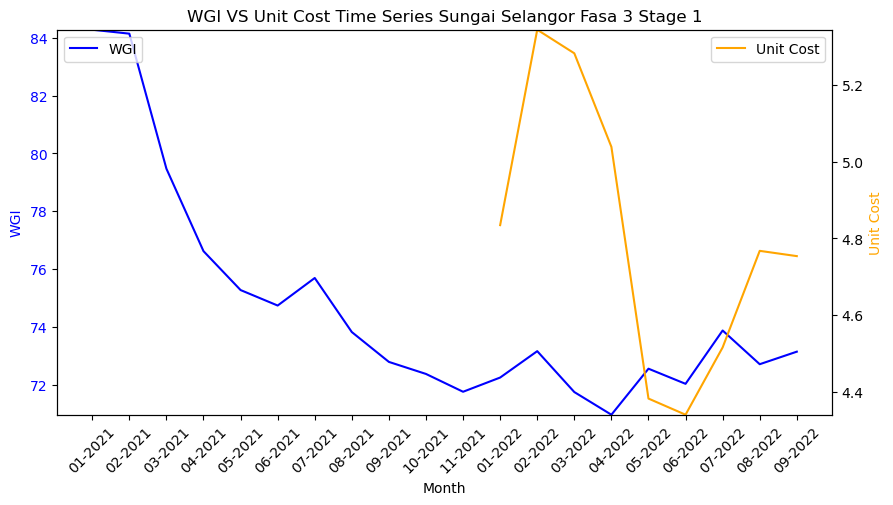

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WQI')

(65.6, 88.3)

Text(0.5, 1.0, 'WQI VS Unit Cost Time Series Sungai Selangor Fasa 3 Stage 1')

Text(0, 0.5, 'Unit Cost')

(4.340702424, 5.343844175)

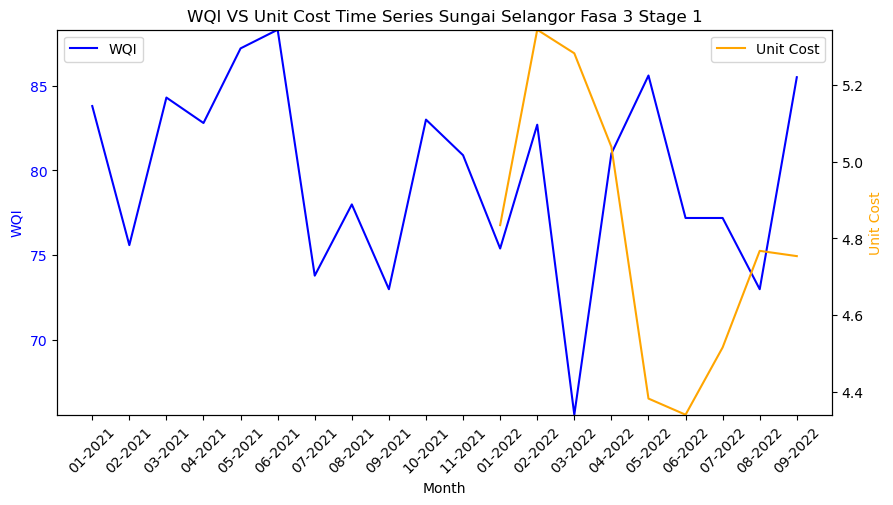

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 1')

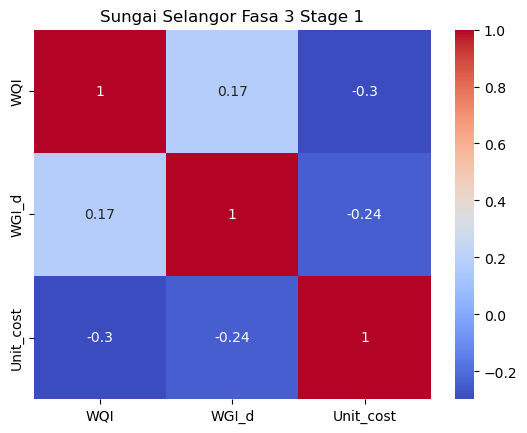

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WGI')

(70.9648698841468, 84.27728211294072)

Text(0.5, 1.0, 'WGI VS Unit Cost Time Series Sungai Selangor Fasa 3 Stage 2')

Text(0, 0.5, 'Unit Cost')

(4.340702424, 5.343844175)

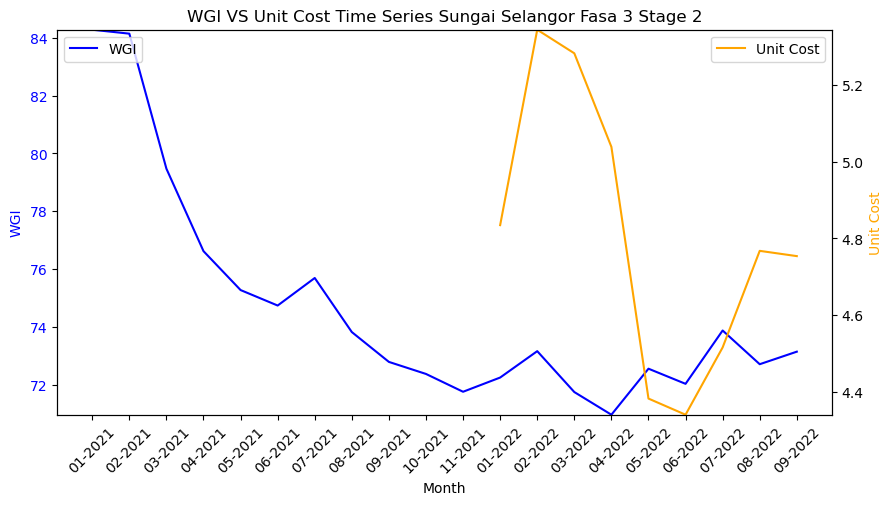

Text(0.5, 0, 'Month')

Text(0, 0.5, 'WQI')

(65.6, 88.3)

Text(0.5, 1.0, 'WQI VS Unit Cost Time Series Sungai Selangor Fasa 3 Stage 2')

Text(0, 0.5, 'Unit Cost')

(4.340702424, 5.343844175)

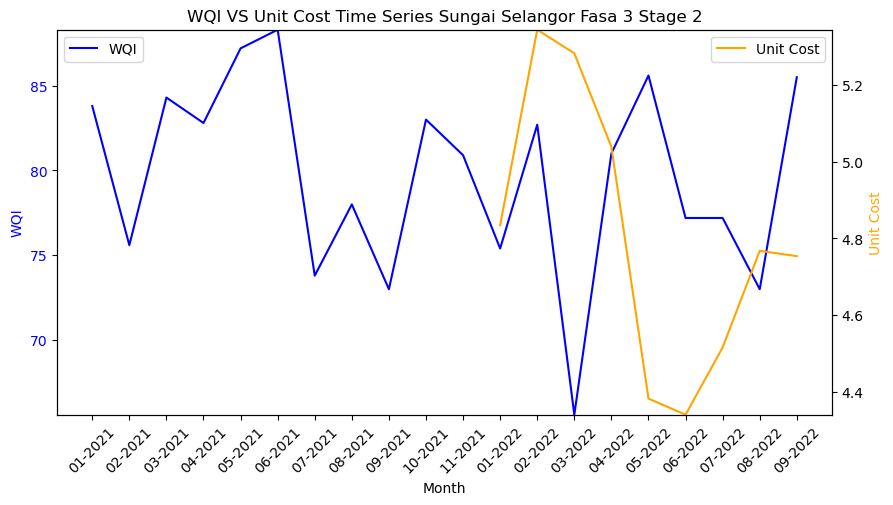

<AxesSubplot:>

Text(0.5, 1.0, 'Sungai Selangor Fasa 3 Stage 2')

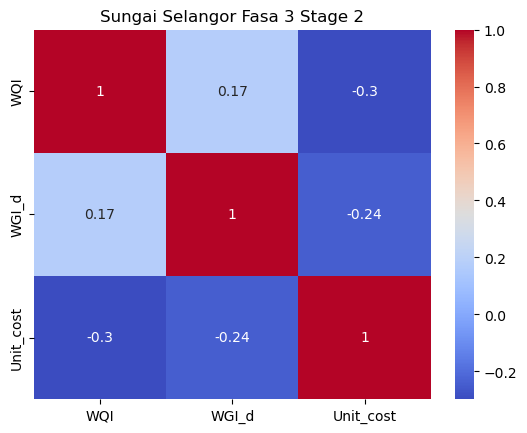

In [58]:
fr = pd.merge(fc,master_db[['wtp']],on = 'wtp',how = 'left')

fr = fr[(fr['Lembangan'] == 'Sg Selangor')]

columns_target = 'wtp'
core_unit_wgi = []
core_unit_wqi = []
wtp_corr = []

for i in fr[columns_target].unique():
    
    core = fr[fr[columns_target] == i][['WQI','WGI_d','Unit_cost']].corr()
    core_unit_wgi.append(core['Unit_cost'][1])
    corr_val =round(core['Unit_cost'][1],2)
    corr_val2 =round(core['Unit_cost'][0],2)
    core_unit_wqi.append(core['Unit_cost'][0])
    if i != 'Rantau Panjang Old':
        a = fr[fr['wtp']==i].copy()
    
        # get x, y1, and y2 data from the DataFrame
        #a['Month'] = pd.to_datetime(a['Month'], format="%b-%y").dt.strftime('%m-%Y')
        a = a.sort_values('Month')
        x = pd.to_datetime(a['Month'], format="%b-%y").dt.strftime('%m-%Y')
        y1 = a['WGI_d']
        y2 = a['Unit_cost']

        # create figure and axis objects
        fig, ax1 = plt.subplots(figsize=(10, 5))

        # plot the first variable on the left y axis
        ax1.plot(x, y1, color='blue')
        ax1.set_xlabel('Month')
        ax1.set_ylabel('WGI', color='blue')
        ax1.tick_params(axis='x', rotation=45)

        # set the color of the tick labels on the left y-axis
        ax1.tick_params(axis='y', labelcolor='blue')

        # set the limits for the y-axis on the left
        ax1.set_ylim([y1.min(), y1.max()])

        # create a second y axis that shares the same x axis
        ax2 = ax1.twinx()
        # add a title to the plot
        #ax1.set_title('Title of the Plot', fontsize=12)
        ax1.set_title(f'WGI VS Unit Cost Time Series {i}' )#Corr WGI:{corr_val}'
        # plot the second variable on the right y axis
        ax2.plot(x, y2, color='orange')
        ax2.set_ylabel('Unit Cost', color='orange')

        # set the limits for the y-axis on the right
        ax2.set_ylim([y2.min(), y2.max()])

        # add a legend to the plot
        ax1.legend(['WGI'], loc='upper left')
        ax2.legend(['Unit Cost'], loc='upper right')

        # show the plot
        plt.show()

        y1 = a['WQI']

        # create figure and axis objects
        fig, ax1 = plt.subplots(figsize=(10, 5))

        # plot the first variable on the left y axis
        ax1.plot(x, y1, color='blue')
        ax1.set_xlabel('Month')
        ax1.set_ylabel('WQI', color='blue')
        ax1.tick_params(axis='x', rotation=45)

        # set the color of the tick labels on the left y-axis
        ax1.tick_params(axis='y', labelcolor='blue')

        # set the limits for the y-axis on the left
        ax1.set_ylim([y1.min(), y1.max()])

        # create a second y axis that shares the same x axis
        ax2 = ax1.twinx()
        # add a title to the plot
        #ax1.set_title('Title of the Plot', fontsize=12)
        ax1.set_title(f'WQI VS Unit Cost Time Series {i}' )#Corr WGI:{corr_val}'
        # plot the second variable on the right y axis
        ax2.plot(x, y2, color='orange')
        ax2.set_ylabel('Unit Cost', color='orange')

        # set the limits for the y-axis on the right
        ax2.set_ylim([y2.min(), y2.max()])

        # add a legend to the plot
        ax1.legend(['WQI'], loc='upper left')
        ax2.legend(['Unit Cost'], loc='upper right')

        # show the plot
        plt.show()




        # scaler = MinMaxScaler(feature_range=(a['WGI_d'].min(), a['WGI_d'].max()))
        # scaler2 = MinMaxScaler(feature_range=(a['WQI'].min(), a['WQI'].max()))
        # a['Unit_cost'] = scaler.fit_transform(a[['Unit_cost']])
        # #a['WQI'] = scaler.fit_transform(a[['WQI']])
        # a.plot(x='Month',y=['WGI_d','Unit_cost'])
        # plt.title(f'WGI VS Unit Cost Time Series {i}' )#Corr WGI:{corr_val}'
        # plt.ylabel('Score')
        # plt.show()

        # a['Unit_cost'] = scaler2.fit_transform(a[['Unit_cost']])
        # a.plot(x='Month',y=['WQI','Unit_cost'])
        # plt.title(f'WQI VS Unit Cost Time Series {i} ')#Corr WQI:{corr_val2}
        # plt.ylabel('Score')
        # plt.show()
    wtp_corr.append(i) 
    sns.heatmap(core, annot=True, cmap='coolwarm')
    plt.title(i)
    plt.show()

data = {'wtp': wtp_corr,
        'corr_wgi_unit': core_unit_wgi,
        'corr_wqi_unit': core_unit_wqi}
  
# Create DataFrame
corr2_df = pd.DataFrame(data)

In [59]:
print(corr2_df.sort_values('corr_wgi_unit')) 
corr2_df.to_csv('Plot\Result\correlation_unified_weight_WGI_Sg_Selangor_27Apr_Clip.csv')

                                wtp  corr_wgi_unit  corr_wqi_unit
8   Sungai Selangor Fasa 2 Stream D      -0.695067       0.066686
7   Sungai Selangor Fasa 2 Stream C      -0.695067       0.040316
1                  Kuala Kubu Bharu      -0.683182      -0.697519
0                       Batang Kali      -0.288372      -0.522728
9    Sungai Selangor Fasa 3 Stage 1      -0.243674      -0.297631
10   Sungai Selangor Fasa 3 Stage 2      -0.243674      -0.297631
6            Sungai Selangor Fasa 1      -0.144207      -0.186184
2                Rantau Panjang New      -0.069608      -0.161098
4                              Rasa       0.272339      -0.618708
5                    Sungai Rangkap       0.319152       0.111240
3                Rantau Panjang Old            NaN            NaN
